# Final Project
You have almost finished the course, great job! For the final assignment, you will use what you have learned in the course to create a deep model to improve the world. You will be graded on a number of criteria:

- (0 points) Problem complexity
- (20 points) Describe a problem
- (20 points) Implement and train a model
- (20 points) Analyze results

# Problem Complexity (40 points total)

This is a very open-ended project. Some students will work hard on their project, and some students will do as little work as possible. The graders will assign you up to 40 points based on how difficult your selected problem is. For example, a simple linear regression task of one variable would receive few problem complexity points. A model that combines different types of neural networks (e.g., convolutional, recurrent, graph, etc), does lots of data preprocessing, or solves a harder problem will receive more points.

# Problem Description (20 points total)

- (10 points) High level problem
- (10 points) Technical description

Here, you must describe the problem setup in a text box. You should describe the high-level problem you are solving (e.g., predicting cancer from medical images). You must also explain *how* it improves the world. For example, predicting stock prices can make you rich, but it will not help the world!

You must also describe the techincal aspects of your model $f$. What are the inputs and outputs (i.e., $f: ? \mapsto ? $)? What are their shapes and domains? What loss function will you use? Why?

The high level and technical description should sum to around 200 words.

TODO: Write your problem description here

**High Level Problem**

Generative Adversarial Networks (GANs) are widely used in image generation but face critical challenges of training instability and mode collapse, which limit their practical applicability in complex real-world scenarios. This project addresses these issues by systematically comparing the original GAN, Wasserstein GAN (WGAN), and WGAN with Gradient Penalty (WGAN-GP) to identify robust solutions for stable and high-quality image generation. It benefits the world by advancing reliable generative models that enable data augmentation in fields like medical imaging (alleviating shortages of scarce labeled data) and creative design, while ensuring diverse and realistic outputs to drive trustworthy practical applications.

**Technical Description**

The model $f$ maps 100-dimensional random noise vectors $z$ ~ $N$(0, $I$) (multivariate standard normal distribution) to 28×28×1 grayscale synthetic images (pixel values normalized to \([-1, 1]\)). Inputs include the MNIST (70k handwritten digit images) and Fashion-MNIST (70k fashion item images) datasets for training. Loss functions differ by model: GAN uses JS divergence, WGAN employs Wasserstein distance with weight clipping, and WGAN-GP integrates Wasserstein distance with gradient penalty. These losses optimize alignment between generated and real distributions—Wasserstein variants resolve JS divergence’s gradient vanishing issue, enhancing training stability. Outputs include synthetic images, generator/discriminator loss curves, and FID scores (quantifying distribution similarity, lower values indicate better performance) for comprehensive evaluation.

# Implementation (20 points)

Use what you learned in this course to implement then train your model. Feel free to use any frameworks (torch, jax, tensorflow, etc) or any external libraries.

# GAN
The code and results of this part are in the GAN package.

In [ ]:
# GAN
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tqdm import tqdm
import time
import os


os.makedirs("outputs", exist_ok=True)


(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(-1, 28, 28, 1).astype('float32') / 127.5 - 1.0
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(1000).batch(128).cache().prefetch(
    tf.data.AUTOTUNE)



def build_generator(latent_dim=100):
    model = tf.keras.Sequential([
        layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(latent_dim,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        layers.Reshape((7, 7, 256)),
        layers.Conv2DTranspose(128, 5, strides=1, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(64, 5, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(1, 5, strides=2, padding='same', use_bias=False, activation='tanh')
    ])
    return model


def build_discriminator(is_wgan=False):
    model = tf.keras.Sequential([
        layers.Conv2D(64, 5, strides=2, padding='same', input_shape=(28, 28, 1)),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Conv2D(128, 5, strides=2, padding='same'),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1, activation=None if is_wgan else 'sigmoid')
    ])
    return model



class GANTrainer:
    def __init__(self, model_type="gan", latent_dim=100, lr=2e-4, clip_value=0.01, lambda_gp=10):
        self.model_type = model_type
        self.generator = build_generator(latent_dim)
        self.discriminator = build_discriminator(is_wgan=(model_type != "gan"))
        self.opt_gen = tf.keras.optimizers.Adam(lr, beta_1=0.5)
        self.opt_disc = tf.keras.optimizers.Adam(lr, beta_1=0.5)
        self.latent_dim = latent_dim
        self.clip_value = clip_value
        self.lambda_gp = lambda_gp
        self.history = {'g_loss': [], 'd_loss': [], 'diversity': []}
        self.model_name = model_type.upper()

    def gradient_penalty(self, real_images, fake_images):
        alpha = tf.random.uniform([len(real_images), 1, 1, 1], 0., 1.)
        interpolates = alpha * real_images + (1 - alpha) * fake_images
        with tf.GradientTape() as tape:
            tape.watch(interpolates)
            pred = self.discriminator(interpolates)
        gradients = tape.gradient(pred, interpolates)
        slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1, 2, 3]))
        return tf.reduce_mean(tf.square(slopes - 1.))

    def train_step(self, images):
        noise = tf.random.normal([images.shape[0], self.latent_dim])

        for _ in range(3 if self.model_type != "gan" else 1):
            with tf.GradientTape() as tape_d:
                fake_images = self.generator(noise, training=False)
                if self.model_type == "gan":
                    d_real = self.discriminator(images, training=True)
                    d_fake = self.discriminator(fake_images, training=True)
                    real_loss = tf.reduce_mean(
                        tf.keras.losses.binary_crossentropy(tf.ones_like(d_real), d_real))
                    fake_loss = tf.reduce_mean(
                        tf.keras.losses.binary_crossentropy(tf.zeros_like(d_fake), d_fake))
                    d_loss = (real_loss + fake_loss) / 2
                else:
                    d_loss = tf.reduce_mean(self.discriminator(fake_images)) - tf.reduce_mean(
                        self.discriminator(images))
                    if self.model_type == "wgan-gp":
                        d_loss += self.lambda_gp * self.gradient_penalty(images, fake_images)

            d_grads = tape_d.gradient(d_loss, self.discriminator.trainable_variables)
            self.opt_disc.apply_gradients(zip(d_grads, self.discriminator.trainable_variables))

            if self.model_type == "wgan":
                for var in self.discriminator.trainable_variables:
                    var.assign(tf.clip_by_value(var, -self.clip_value, self.clip_value))

        with tf.GradientTape() as tape_g:
            fake_images = self.generator(noise, training=True)
            if self.model_type == "gan":
                g_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(self.discriminator(fake_images)),
                                                        self.discriminator(fake_images)))
            else:
                g_loss = -tf.reduce_mean(self.discriminator(fake_images))

        g_grads = tape_g.gradient(g_loss, self.generator.trainable_variables)
        self.opt_gen.apply_gradients(zip(g_grads, self.generator.trainable_variables))

        return float(g_loss), float(d_loss)

    def calculate_diversity(self, num=100):
        samples = self.generator(tf.random.normal([num, self.latent_dim])).numpy()
        return float(np.mean(np.std(samples, axis=0)))

    def train(self, epochs=15):
        fixed_noise = tf.random.normal([25, self.latent_dim])
        start_time = time.time()

        for epoch in tqdm(range(epochs), desc=f"{self.model_name} Training"):
            g_losses, d_losses = [], []

            # 加一层 batch 进度条
            batch_bar = tqdm(train_dataset, desc=f"Epoch {epoch + 1}/{epochs}", leave=False)
            for batch in batch_bar:
                g_loss, d_loss = self.train_step(batch)
                g_losses.append(g_loss)
                d_losses.append(d_loss)
                batch_bar.set_postfix({"g_loss": f"{g_loss:.4f}", "d_loss": f"{d_loss:.4f}"})

            self.history['g_loss'].append(np.mean(g_losses))
            self.history['d_loss'].append(np.mean(d_losses))
            self.history['diversity'].append(self.calculate_diversity())

            if (epoch % 5 == 0) or (epoch == epochs - 1):
                self.save_generated_images(fixed_noise, epoch)

        self.save_final_report()

    def save_generated_images(self, noise, epoch):
        generated = self.generator(noise, training=False).numpy()
        fig, axes = plt.subplots(5, 5, figsize=(6, 6))
        for ax, img in zip(axes.flatten(), generated):
            ax.imshow(img.squeeze(), cmap='gray', vmin=-1, vmax=1)
            ax.axis('off')
        plt.suptitle(f"{self.model_name} | Epoch {epoch}")
        plt.tight_layout()
        plt.savefig(f"outputs/{self.model_name}_epoch{epoch}.png", dpi=300)
        plt.close()

    def save_final_report(self):
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(self.history['g_loss'], label='Generator Loss')
        plt.plot(self.history['d_loss'], label='Discriminator Loss')
        plt.title(f"{self.model_name} - Loss Curve")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.history['diversity'], 'r-o')
        plt.title(f"{self.model_name} - Diversity Curve")
        plt.xlabel('Epoch')
        plt.ylabel('Pixel STD')

        plt.tight_layout()
        plt.savefig(f"outputs/{self.model_name}_final_report.png", dpi=300)
        plt.close()



def train_gan():
    gan = GANTrainer(model_type="gan")
    print("\n=== Training GAN ===")
    gan.train(epochs=15)


def train_wgan():
    wgan = GANTrainer(model_type="wgan")
    print("\n=== Training WGAN ===")
    wgan.train(epochs=15)


def train_wgan_gp():
    wgan_gp = GANTrainer(model_type="wgan-gp", lambda_gp=10)
    print("\n=== Training WGAN-GP ===")
    wgan_gp.train(epochs=15)




train_gan()
# train_wgan()
#train_wgan_gp()



In [ ]:
# Fashion GAN
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tqdm import tqdm
import time
import os


os.makedirs("outputs", exist_ok=True)


(train_images, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
train_images = train_images.reshape(-1, 28, 28, 1).astype('float32') / 127.5 - 1.0
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(1000).batch(128).cache().prefetch(
    tf.data.AUTOTUNE)



def build_generator(latent_dim=100):
    model = tf.keras.Sequential([
        layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(latent_dim,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        layers.Reshape((7, 7, 256)),
        layers.Conv2DTranspose(128, 5, strides=1, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(64, 5, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(1, 5, strides=2, padding='same', use_bias=False, activation='tanh')
    ])
    return model


def build_discriminator(is_wgan=False):
    model = tf.keras.Sequential([
        layers.Conv2D(64, 5, strides=2, padding='same', input_shape=(28, 28, 1)),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Conv2D(128, 5, strides=2, padding='same'),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1, activation=None if is_wgan else 'sigmoid')
    ])
    return model



class GANTrainer:
    def __init__(self, model_type="gan", latent_dim=100, lr=2e-4, clip_value=0.01, lambda_gp=10):
        self.model_type = model_type
        self.generator = build_generator(latent_dim)
        self.discriminator = build_discriminator(is_wgan=(model_type != "gan"))
        self.opt_gen = tf.keras.optimizers.Adam(lr, beta_1=0.5)
        self.opt_disc = tf.keras.optimizers.Adam(lr, beta_1=0.5)
        self.latent_dim = latent_dim
        self.clip_value = clip_value
        self.lambda_gp = lambda_gp
        self.history = {'g_loss': [], 'd_loss': [], 'diversity': []}
        self.model_name = model_type.upper()

    def gradient_penalty(self, real_images, fake_images):
        alpha = tf.random.uniform([len(real_images), 1, 1, 1], 0., 1.)
        interpolates = alpha * real_images + (1 - alpha) * fake_images
        with tf.GradientTape() as tape:
            tape.watch(interpolates)
            pred = self.discriminator(interpolates)
        gradients = tape.gradient(pred, interpolates)
        slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1, 2, 3]))
        return tf.reduce_mean(tf.square(slopes - 1.))

    def train_step(self, images):
        noise = tf.random.normal([images.shape[0], self.latent_dim])

        for _ in range(3 if self.model_type != "gan" else 1):
            with tf.GradientTape() as tape_d:
                fake_images = self.generator(noise, training=False)
                if self.model_type == "gan":
                    d_real = self.discriminator(images, training=True)
                    d_fake = self.discriminator(fake_images, training=True)
                    real_loss = tf.reduce_mean(
                        tf.keras.losses.binary_crossentropy(tf.ones_like(d_real), d_real))
                    fake_loss = tf.reduce_mean(
                        tf.keras.losses.binary_crossentropy(tf.zeros_like(d_fake), d_fake))
                    d_loss = (real_loss + fake_loss) / 2
                else:
                    d_loss = tf.reduce_mean(self.discriminator(fake_images)) - tf.reduce_mean(
                        self.discriminator(images))
                    if self.model_type == "wgan-gp":
                        d_loss += self.lambda_gp * self.gradient_penalty(images, fake_images)

            d_grads = tape_d.gradient(d_loss, self.discriminator.trainable_variables)
            self.opt_disc.apply_gradients(zip(d_grads, self.discriminator.trainable_variables))

            if self.model_type == "wgan":
                for var in self.discriminator.trainable_variables:
                    var.assign(tf.clip_by_value(var, -self.clip_value, self.clip_value))

        with tf.GradientTape() as tape_g:
            fake_images = self.generator(noise, training=True)
            if self.model_type == "gan":
                g_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(self.discriminator(fake_images)),
                                                        self.discriminator(fake_images)))
            else:
                g_loss = -tf.reduce_mean(self.discriminator(fake_images))

        g_grads = tape_g.gradient(g_loss, self.generator.trainable_variables)
        self.opt_gen.apply_gradients(zip(g_grads, self.generator.trainable_variables))

        return float(g_loss), float(d_loss)

    def calculate_diversity(self, num=100):
        samples = self.generator(tf.random.normal([num, self.latent_dim])).numpy()
        return float(np.mean(np.std(samples, axis=0)))

    def train(self, epochs=15):
        fixed_noise = tf.random.normal([25, self.latent_dim])
        start_time = time.time()

        for epoch in tqdm(range(epochs), desc=f"{self.model_name} Training"):
            g_losses, d_losses = [], []

            batch_bar = tqdm(train_dataset, desc=f"Epoch {epoch + 1}/{epochs}", leave=False)
            for batch in batch_bar:
                g_loss, d_loss = self.train_step(batch)
                g_losses.append(g_loss)
                d_losses.append(d_loss)
                batch_bar.set_postfix({"g_loss": f"{g_loss:.4f}", "d_loss": f"{d_loss:.4f}"})

            self.history['g_loss'].append(np.mean(g_losses))
            self.history['d_loss'].append(np.mean(d_losses))
            self.history['diversity'].append(self.calculate_diversity())

            if (epoch % 5 == 0) or (epoch == epochs - 1):
                self.save_generated_images(fixed_noise, epoch)

        self.save_final_report()

    def save_generated_images(self, noise, epoch):
        generated = self.generator(noise, training=False).numpy()
        fig, axes = plt.subplots(5, 5, figsize=(6, 6))
        for ax, img in zip(axes.flatten(), generated):
            ax.imshow(img.squeeze(), cmap='gray', vmin=-1, vmax=1)
            ax.axis('off')
        plt.suptitle(f"{self.model_name} | Epoch {epoch}")
        plt.tight_layout()
        plt.savefig(f"outputs/{self.model_name}_epoch{epoch}.png", dpi=300)
        plt.close()

    def save_final_report(self):
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(self.history['g_loss'], label='Generator Loss')
        plt.plot(self.history['d_loss'], label='Discriminator Loss')
        plt.title(f"{self.model_name} - Loss Curve")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.history['diversity'], 'r-o')
        plt.title(f"{self.model_name} - Diversity Curve")
        plt.xlabel('Epoch')
        plt.ylabel('Pixel STD')

        plt.tight_layout()
        plt.savefig(f"outputs/{self.model_name}_final_report.png", dpi=300)
        plt.close()



def train_gan():
    gan = GANTrainer(model_type="gan")
    print("\n=== Training GAN ===")
    gan.train(epochs=15)


def train_wgan():
    wgan = GANTrainer(model_type="wgan")
    print("\n=== Training WGAN ===")
    wgan.train(epochs=15)


def train_wgan_gp():
    wgan_gp = GANTrainer(model_type="wgan-gp", lambda_gp=10)
    print("\n=== Training WGAN-GP ===")
    wgan_gp.train(epochs=15)




train_gan()
# train_wgan()
#train_wgan_gp()


# WGAN-mnist

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



=== 训练WGAN（MNIST数据集） ===


Streaming output truncated to the last 5000 lines.
WGAN_MNIST Training: 100%|██████████| 15/15 [58:10<00:00, 232.69s/it]


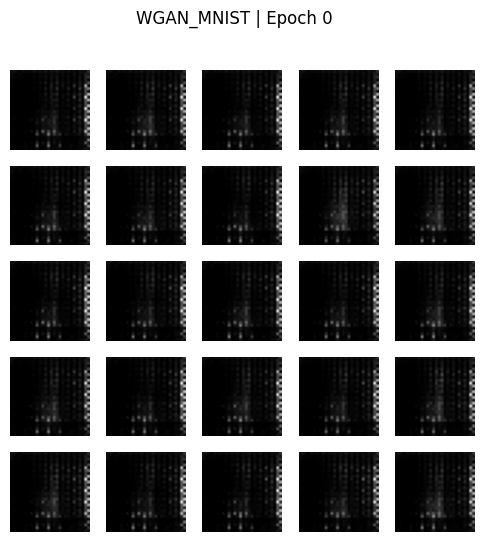

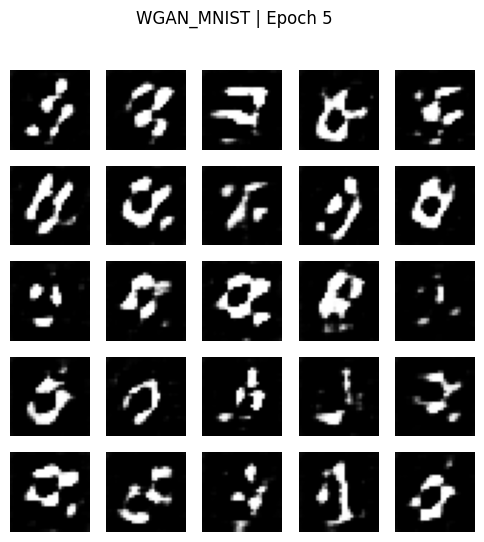

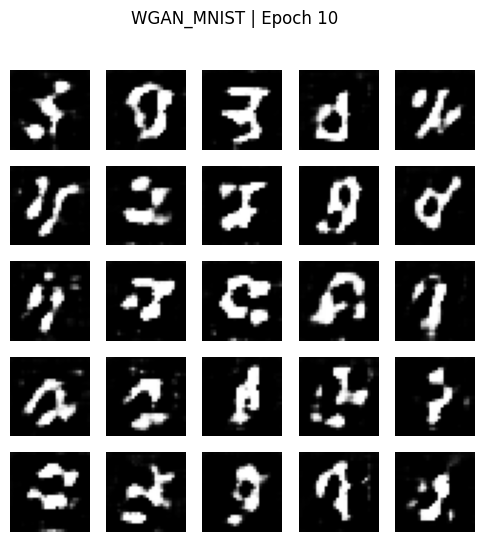

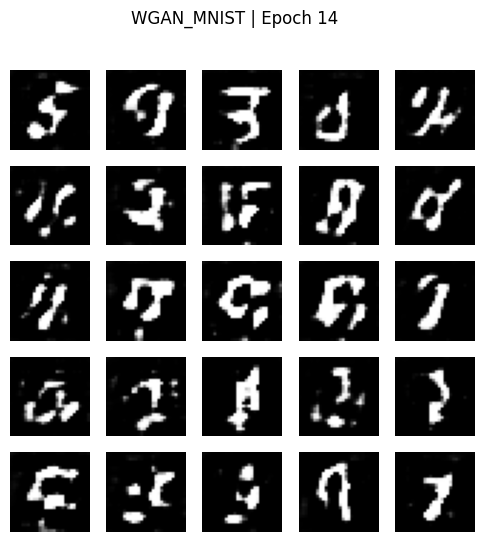

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tqdm import tqdm
import time
import os

# 建立保存图片文件夹
os.makedirs("outputs", exist_ok=True)

# 1. 数据准备
def load_dataset(dataset_name="mnist"):
    """
    加载MNIST或Fashion-MNIST数据集，返回预处理后的训练集
    参数:
        dataset_name: 数据集名称，可选"mnist"或"fashion_mnist"
    返回:
        train_dataset: TensorFlow Dataset对象（批量处理后）
    """
    # 加载对应数据集（TensorFlow自带接口，无需额外下载）
    if dataset_name == "mnist":
        (train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
    elif dataset_name == "fashion_mnist":
        (train_images, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
    else:
        raise ValueError("dataset_name仅支持'mnist'或'fashion_mnist'")

    # -------------------------- 预处理：与MNIST完全一致 --------------------------
    # 1. 调整形状为(样本数, 28, 28, 1)（单通道灰度图）
    # 2. 转换为float32类型
    # 3. 归一化到[-1, 1]（文档2要求：像素值范围归一化到[-1,1]）
    train_images = train_images.reshape(-1, 28, 28, 1).astype("float32") / 127.5 - 1.0

    # 构建Dataset对象（参数与原MNIST逻辑一致，保证批量处理公平）
    train_dataset = (
        tf.data.Dataset.from_tensor_slices(train_images)
        .shuffle(1000)  # 随机打乱（缓冲区1000）
        .batch(128)     # 批量大小128（文档1、2均指定batch_size=128）
        .cache()        # 缓存加速
        .prefetch(tf.data.AUTOTUNE)  # 预取优化
    )
    return train_dataset

# 2. 模型定义
def build_generator(latent_dim=100):
    model = tf.keras.Sequential([
        layers.Dense(7*7*256, use_bias=False, input_shape=(latent_dim,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        layers.Reshape((7, 7, 256)),
        layers.Conv2DTranspose(128, 5, strides=1, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(64, 5, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(1, 5, strides=2, padding='same', use_bias=False, activation='tanh')
    ])
    return model

def build_discriminator(is_wgan=False):
    model = tf.keras.Sequential([
        layers.Conv2D(64, 5, strides=2, padding='same', input_shape=(28,28,1)),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Conv2D(128, 5, strides=2, padding='same'),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1, activation=None if is_wgan else 'sigmoid')
    ])
    return model

# 3. 训练框架
class GANTrainer:
    # 新增 train_dataset、lambda_gp 参数
    def __init__(self, model_type="wgan", latent_dim=100, lr=2e-4, clip_value=0.01, dataset_name="mnist", train_dataset=None, lambda_gp=10):
        self.model_type = model_type
        self.dataset_name = dataset_name
        self.latent_dim = latent_dim
        self.generator = build_generator(latent_dim)
        self.discriminator = build_discriminator(is_wgan=(model_type != "gan"))
        self.opt_gen = tf.keras.optimizers.Adam(lr, beta_1=0.5)
        self.opt_disc = tf.keras.optimizers.Adam(lr, beta_1=0.5)
        self.clip_value = clip_value
        self.lambda_gp = lambda_gp  # 新增：保存wgan-gp的梯度惩罚系数
        self.model_name = f"{model_type.upper()}_{self.dataset_name.upper()}"
        self.history = {"g_loss": [], "d_loss": [], "diversity": []}
        self.train_dataset = train_dataset  # 新增：保存传入的训练数据集

    def gradient_penalty(self, real_images, fake_images):
        alpha = tf.random.uniform([len(real_images), 1, 1, 1], 0., 1.)
        interpolates = alpha * real_images + (1 - alpha) * fake_images
        with tf.GradientTape() as tape:
            tape.watch(interpolates)
            pred = self.discriminator(interpolates)
        gradients = tape.gradient(pred, interpolates)
        slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1,2,3]))
        return tf.reduce_mean(tf.square(slopes - 1.))

    def train_step(self, images):
        noise = tf.random.normal([images.shape[0], self.latent_dim])

        for _ in range(5 if self.model_type != "gan" else 1):
            with tf.GradientTape() as tape_d:
                fake_images = self.generator(noise, training=False)
                if self.model_type == "gan":
                    d_real = self.discriminator(images, training=True)
                    d_fake = self.discriminator(fake_images, training=True)
                    real_loss = tf.reduce_mean(
                        tf.keras.losses.binary_crossentropy(tf.ones_like(d_real), d_real))
                    fake_loss = tf.reduce_mean(
                        tf.keras.losses.binary_crossentropy(tf.zeros_like(d_fake), d_fake))
                    d_loss = (real_loss + fake_loss) / 2
                else:
                    d_loss = tf.reduce_mean(self.discriminator(fake_images)) - tf.reduce_mean(self.discriminator(images))
                    if self.model_type == "wgan-gp":
                        d_loss += self.lambda_gp * self.gradient_penalty(images, fake_images)

            d_grads = tape_d.gradient(d_loss, self.discriminator.trainable_variables)
            self.opt_disc.apply_gradients(zip(d_grads, self.discriminator.trainable_variables))

            if self.model_type == "wgan":
                for var in self.discriminator.trainable_variables:
                    var.assign(tf.clip_by_value(var, -self.clip_value, self.clip_value))

        with tf.GradientTape() as tape_g:
            fake_images = self.generator(noise, training=True)
            if self.model_type == "gan":
                g_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(self.discriminator(fake_images)),
                                                        self.discriminator(fake_images)))
            else:
                g_loss = -tf.reduce_mean(self.discriminator(fake_images))

        g_grads = tape_g.gradient(g_loss, self.generator.trainable_variables)
        self.opt_gen.apply_gradients(zip(g_grads, self.generator.trainable_variables))

        return float(g_loss), float(d_loss)

    def calculate_diversity(self, num=100):
        samples = self.generator(tf.random.normal([num, self.latent_dim])).numpy()
        return float(np.mean(np.std(samples, axis=0)))

    def train(self, epochs=15):
        fixed_noise = tf.random.normal([25, self.latent_dim])
        start_time = time.time()

        for epoch in tqdm(range(epochs), desc=f"{self.model_name} Training"):
            g_losses, d_losses = [], []

            # 加一层 batch 进度条
            batch_bar = tqdm(self.train_dataset, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
            for batch in batch_bar:
                g_loss, d_loss = self.train_step(batch)
                g_losses.append(g_loss)
                d_losses.append(d_loss)
                batch_bar.set_postfix({"g_loss": f"{g_loss:.4f}", "d_loss": f"{d_loss:.4f}"})

            self.history['g_loss'].append(np.mean(g_losses))
            self.history['d_loss'].append(np.mean(d_losses))
            self.history['diversity'].append(self.calculate_diversity())

            if (epoch % 5 == 0) or (epoch == epochs-1):
                self.save_generated_images(fixed_noise, epoch)

        self.save_final_report()

    def save_generated_images(self, noise, epoch):
        generated = self.generator(noise, training=False).numpy()
        fig, axes = plt.subplots(5, 5, figsize=(6, 6))
        for ax, img in zip(axes.flatten(), generated):
            ax.imshow(img.squeeze(), cmap="gray", vmin=-1, vmax=1)
            ax.axis("off")
        # 标题和文件名加入数据集标识（如"WGAN_FASHION-MNIST | Epoch 10"）
        plt.suptitle(f"{self.model_name} | Epoch {epoch}")
        plt.savefig(f"outputs/{self.model_name}_epoch{epoch}.png", dpi=300)

    def save_final_report(self):
        plt.figure(figsize=(12, 5))
        # 损失曲线：标题加入数据集
        plt.subplot(1, 2, 1)
        plt.plot(self.history["g_loss"], label="Generator Loss")
        plt.plot(self.history["d_loss"], label="Discriminator Loss")
        plt.title(f"{self.model_name} - Loss Curve")
        plt.legend()
        # 多样性曲线：文件名加入数据集
        plt.subplot(1, 2, 2)
        plt.plot(self.history["diversity"], "r-o")
        plt.title(f"{self.model_name} - Diversity Curve")
        plt.savefig(f"outputs/{self.model_name}_final_report.png", dpi=300)
        plt.close()
# 4. 定义模型训练
def train_gan():
    train_dataset = load_dataset(dataset_name="mnist")  # 新增：加载数据集
    gan = GANTrainer(model_type="gan", train_dataset=train_dataset)  # 传入数据集
    print("\n=== Training GAN ===")
    gan.train(epochs=15)

def train_wgan_fashion_mnist():
    # 1. 加载Fashion-MNIST数据集
    train_dataset = load_dataset(dataset_name="fashion_mnist")

    # 2. 初始化WGAN训练器时，传入train_dataset
    wgan_fashion = GANTrainer(
        model_type="wgan",
        lr=2e-4,
        clip_value=0.01,
        dataset_name="fashion_mnist",
        train_dataset=train_dataset  # 新增：传入数据集
    )

    # 3. 开始训练
    print("\n=== 训练WGAN（Fashion-MNIST数据集） ===")
    wgan_fashion.train(epochs=15)

# -------------------------- 原有：WGAN在MNIST上的训练函数（保留，用于对比） --------------------------
def train_wgan_mnist():
    train_dataset = load_dataset(dataset_name="mnist")
    wgan_mnist = GANTrainer(
        model_type="wgan",
        lr=2e-4,
        clip_value=0.01,
        dataset_name="mnist",
        train_dataset=train_dataset  # 新增：传入数据集
    )
    print("\n=== 训练WGAN（MNIST数据集） ===")
    wgan_mnist.train(epochs=15)

def train_wgan_gp():
    train_dataset = load_dataset(dataset_name="mnist")  # 新增：加载数据集
    wgan_gp = GANTrainer(
        model_type="wgan-gp",
        lambda_gp=10,
        train_dataset=train_dataset  # 新增：传入数据集
    )
    print("\n=== Training WGAN-GP ===")
    wgan_gp.train(epochs=15)


# 5. 训练执行

# train_gan()
# train_wgan()
# train_wgan_gp()
# 先在MNIST上验证基础性能（确保代码无错）
train_wgan_mnist()
# 再在Fashion-MNIST上训练并调参（项目核心要求）
# train_wgan_fashion_mnist()

# WGAN-fashion_mnist

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

=== 训练WGAN（Fashion-MNIST数据集） ===


Streaming output truncated to the last 5000 lines.
WGAN_FASHION_MNIST Training: 100%|██████████| 15/15 [56:52<00:00, 227.51s/it]


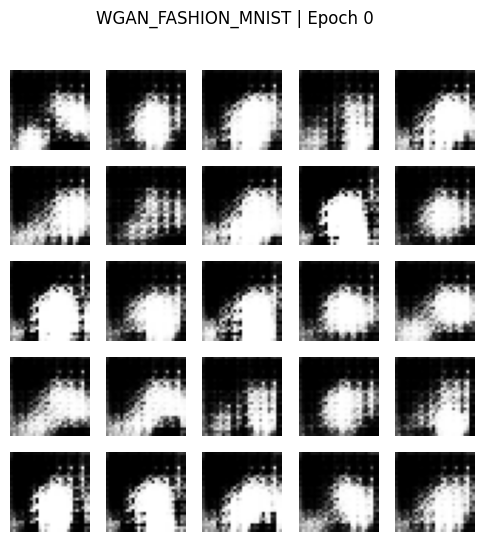

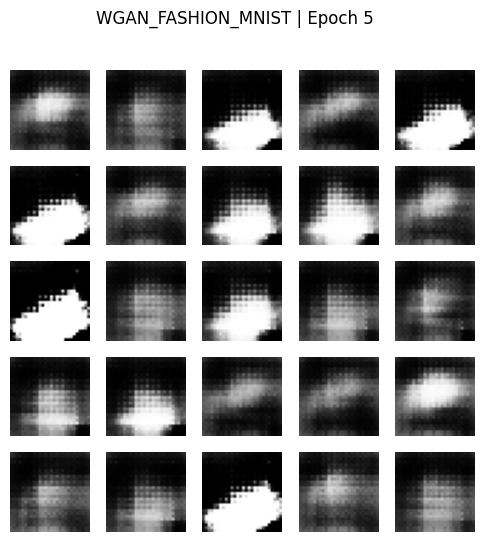

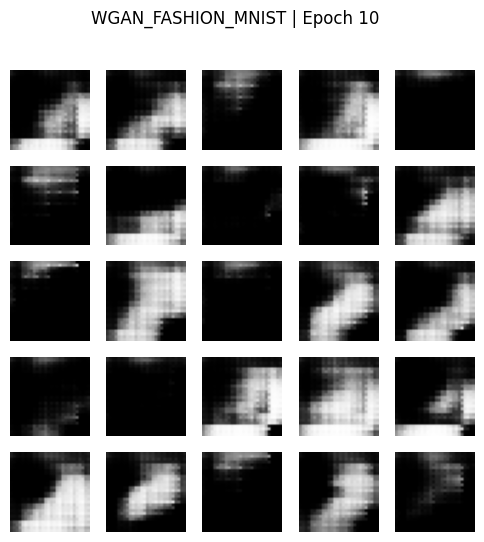

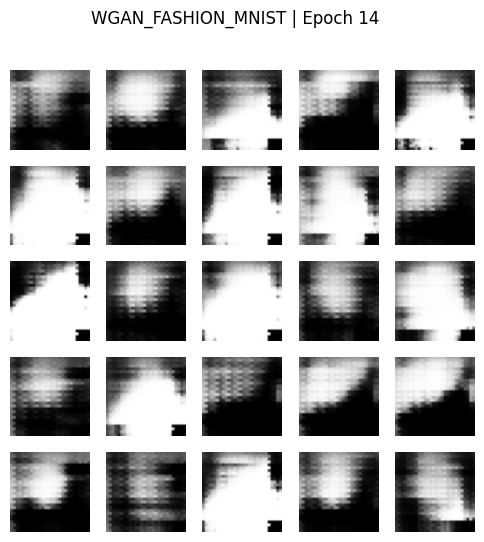

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tqdm import tqdm
import time
import os

# 建立保存图片文件夹
os.makedirs("outputs", exist_ok=True)

# 1. 数据准备
def load_dataset(dataset_name="mnist"):
    """
    加载MNIST或Fashion-MNIST数据集，返回预处理后的训练集
    参数:
        dataset_name: 数据集名称，可选"mnist"或"fashion_mnist"
    返回:
        train_dataset: TensorFlow Dataset对象（批量处理后）
    """
    # 加载对应数据集（TensorFlow自带接口，无需额外下载）
    if dataset_name == "mnist":
        (train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
    elif dataset_name == "fashion_mnist":
        (train_images, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
    else:
        raise ValueError("dataset_name仅支持'mnist'或'fashion_mnist'")

    # -------------------------- 预处理：与MNIST完全一致 --------------------------
    # 1. 调整形状为(样本数, 28, 28, 1)（单通道灰度图）
    # 2. 转换为float32类型
    # 3. 归一化到[-1, 1]（文档2要求：像素值范围归一化到[-1,1]）
    train_images = train_images.reshape(-1, 28, 28, 1).astype("float32") / 127.5 - 1.0

    # 构建Dataset对象（参数与原MNIST逻辑一致，保证批量处理公平）
    train_dataset = (
        tf.data.Dataset.from_tensor_slices(train_images)
        .shuffle(1000)  # 随机打乱（缓冲区1000）
        .batch(128)     # 批量大小128（文档1、2均指定batch_size=128）
        .cache()        # 缓存加速
        .prefetch(tf.data.AUTOTUNE)  # 预取优化
    )
    return train_dataset

# 2. 模型定义
def build_generator(latent_dim=100):
    model = tf.keras.Sequential([
        layers.Dense(7*7*256, use_bias=False, input_shape=(latent_dim,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        layers.Reshape((7, 7, 256)),
        layers.Conv2DTranspose(128, 5, strides=1, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(64, 5, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(1, 5, strides=2, padding='same', use_bias=False, activation='tanh')
    ])
    return model

def build_discriminator(is_wgan=False):
    model = tf.keras.Sequential([
        layers.Conv2D(64, 5, strides=2, padding='same', input_shape=(28,28,1)),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Conv2D(128, 5, strides=2, padding='same'),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1, activation=None if is_wgan else 'sigmoid')
    ])
    return model

# 3. 训练框架
class GANTrainer:
    # 新增 train_dataset、lambda_gp 参数
    def __init__(self, model_type="wgan", latent_dim=100, lr=2e-4, clip_value=0.01, dataset_name="mnist", train_dataset=None, lambda_gp=10):
        self.model_type = model_type
        self.dataset_name = dataset_name
        self.latent_dim = latent_dim
        self.generator = build_generator(latent_dim)
        self.discriminator = build_discriminator(is_wgan=(model_type != "gan"))
        self.opt_gen = tf.keras.optimizers.Adam(lr, beta_1=0.5)
        self.opt_disc = tf.keras.optimizers.Adam(lr, beta_1=0.5)
        self.clip_value = clip_value
        self.lambda_gp = lambda_gp  # 新增：保存wgan-gp的梯度惩罚系数
        self.model_name = f"{model_type.upper()}_{self.dataset_name.upper()}"
        self.history = {"g_loss": [], "d_loss": [], "diversity": []}
        self.train_dataset = train_dataset  # 新增：保存传入的训练数据集

    def gradient_penalty(self, real_images, fake_images):
        alpha = tf.random.uniform([len(real_images), 1, 1, 1], 0., 1.)
        interpolates = alpha * real_images + (1 - alpha) * fake_images
        with tf.GradientTape() as tape:
            tape.watch(interpolates)
            pred = self.discriminator(interpolates)
        gradients = tape.gradient(pred, interpolates)
        slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1,2,3]))
        return tf.reduce_mean(tf.square(slopes - 1.))

    def train_step(self, images):
        noise = tf.random.normal([images.shape[0], self.latent_dim])

        for _ in range(5 if self.model_type != "gan" else 1):
            with tf.GradientTape() as tape_d:
                fake_images = self.generator(noise, training=False)
                if self.model_type == "gan":
                    d_real = self.discriminator(images, training=True)
                    d_fake = self.discriminator(fake_images, training=True)
                    real_loss = tf.reduce_mean(
                        tf.keras.losses.binary_crossentropy(tf.ones_like(d_real), d_real))
                    fake_loss = tf.reduce_mean(
                        tf.keras.losses.binary_crossentropy(tf.zeros_like(d_fake), d_fake))
                    d_loss = (real_loss + fake_loss) / 2
                else:
                    d_loss = tf.reduce_mean(self.discriminator(fake_images)) - tf.reduce_mean(self.discriminator(images))
                    if self.model_type == "wgan-gp":
                        d_loss += self.lambda_gp * self.gradient_penalty(images, fake_images)

            d_grads = tape_d.gradient(d_loss, self.discriminator.trainable_variables)
            self.opt_disc.apply_gradients(zip(d_grads, self.discriminator.trainable_variables))

            if self.model_type == "wgan":
                for var in self.discriminator.trainable_variables:
                    var.assign(tf.clip_by_value(var, -self.clip_value, self.clip_value))

        with tf.GradientTape() as tape_g:
            fake_images = self.generator(noise, training=True)
            if self.model_type == "gan":
                g_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(self.discriminator(fake_images)),
                                                        self.discriminator(fake_images)))
            else:
                g_loss = -tf.reduce_mean(self.discriminator(fake_images))

        g_grads = tape_g.gradient(g_loss, self.generator.trainable_variables)
        self.opt_gen.apply_gradients(zip(g_grads, self.generator.trainable_variables))

        return float(g_loss), float(d_loss)

    def calculate_diversity(self, num=100):
        samples = self.generator(tf.random.normal([num, self.latent_dim])).numpy()
        return float(np.mean(np.std(samples, axis=0)))

    def train(self, epochs=15):
        fixed_noise = tf.random.normal([25, self.latent_dim])
        start_time = time.time()

        for epoch in tqdm(range(epochs), desc=f"{self.model_name} Training"):
            g_losses, d_losses = [], []

            # 加一层 batch 进度条
            batch_bar = tqdm(self.train_dataset, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
            for batch in batch_bar:
                g_loss, d_loss = self.train_step(batch)
                g_losses.append(g_loss)
                d_losses.append(d_loss)
                batch_bar.set_postfix({"g_loss": f"{g_loss:.4f}", "d_loss": f"{d_loss:.4f}"})

            self.history['g_loss'].append(np.mean(g_losses))
            self.history['d_loss'].append(np.mean(d_losses))
            self.history['diversity'].append(self.calculate_diversity())

            if (epoch % 5 == 0) or (epoch == epochs-1):
                self.save_generated_images(fixed_noise, epoch)

        self.save_final_report()

    def save_generated_images(self, noise, epoch):
        generated = self.generator(noise, training=False).numpy()
        fig, axes = plt.subplots(5, 5, figsize=(6, 6))
        for ax, img in zip(axes.flatten(), generated):
            ax.imshow(img.squeeze(), cmap="gray", vmin=-1, vmax=1)
            ax.axis("off")
        # 标题和文件名加入数据集标识（如"WGAN_FASHION-MNIST | Epoch 10"）
        plt.suptitle(f"{self.model_name} | Epoch {epoch}")
        plt.savefig(f"outputs/{self.model_name}_epoch{epoch}.png", dpi=300)

    def save_final_report(self):
        plt.figure(figsize=(12, 5))
        # 损失曲线：标题加入数据集
        plt.subplot(1, 2, 1)
        plt.plot(self.history["g_loss"], label="Generator Loss")
        plt.plot(self.history["d_loss"], label="Discriminator Loss")
        plt.title(f"{self.model_name} - Loss Curve")
        plt.legend()
        # 多样性曲线：文件名加入数据集
        plt.subplot(1, 2, 2)
        plt.plot(self.history["diversity"], "r-o")
        plt.title(f"{self.model_name} - Diversity Curve")
        plt.savefig(f"outputs/{self.model_name}_final_report.png", dpi=300)
        plt.close()
# 4. 定义模型训练
def train_gan():
    train_dataset = load_dataset(dataset_name="mnist")  # 新增：加载数据集
    gan = GANTrainer(model_type="gan", train_dataset=train_dataset)  # 传入数据集
    print("\n=== Training GAN ===")
    gan.train(epochs=15)

def train_wgan_fashion_mnist():
    # 1. 加载Fashion-MNIST数据集
    train_dataset = load_dataset(dataset_name="fashion_mnist")

    # 2. 初始化WGAN训练器时，传入train_dataset
    wgan_fashion = GANTrainer(
        model_type="wgan",
        lr=2e-4,
        clip_value=0.01,
        dataset_name="fashion_mnist",
        train_dataset=train_dataset  # 新增：传入数据集
    )

    # 3. 开始训练
    print("\n=== 训练WGAN（Fashion-MNIST数据集） ===")
    wgan_fashion.train(epochs=15)

# -------------------------- 原有：WGAN在MNIST上的训练函数（保留，用于对比） --------------------------
def train_wgan_mnist():
    train_dataset = load_dataset(dataset_name="mnist")
    wgan_mnist = GANTrainer(
        model_type="wgan",
        lr=2e-4,
        clip_value=0.01,
        dataset_name="mnist",
        train_dataset=train_dataset  # 新增：传入数据集
    )
    print("\n=== 训练WGAN（MNIST数据集） ===")
    wgan_mnist.train(epochs=15)

def train_wgan_gp():
    train_dataset = load_dataset(dataset_name="mnist")  # 新增：加载数据集
    wgan_gp = GANTrainer(
        model_type="wgan-gp",
        lambda_gp=10,
        train_dataset=train_dataset  # 新增：传入数据集
    )
    print("\n=== Training WGAN-GP ===")
    wgan_gp.train(epochs=15)


# 5. 训练执行

# train_gan()
# train_wgan()
# train_wgan_gp()
# 先在MNIST上验证基础性能（确保代码无错）
# train_wgan_mnist()
# 再在Fashion-MNIST上训练并调参（项目核心要求）
train_wgan_fashion_mnist()

# WGAN_GP
The results of this part are in the WGAN_GP package.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.makedirs("/content/drive/MyDrive/WGAN_outputs", exist_ok=True)

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tqdm import tqdm
import time
import os

# 建立保存图片文件夹
OUTPUT_DIR = "/content/drive/MyDrive/WGAN_outputs"

# 1. 数据准备：封装成可切换的数据集加载函数
def load_dataset(name="mnist", batch_size=128):
    if name == "mnist":
        (train_images, _), _ = tf.keras.datasets.mnist.load_data()
    elif name == "fashion":
        (train_images, _), _ = tf.keras.datasets.fashion_mnist.load_data()
    else:
        raise ValueError("dataset name must be 'mnist' or 'fashion'")

    train_images = train_images.reshape(-1, 28, 28, 1).astype('float32')
    train_images = train_images / 127.5 - 1.0  # [0,255] → [-1,1]

    train_dataset = (
        tf.data.Dataset.from_tensor_slices(train_images)
        .shuffle(1000)
        .batch(batch_size)
        .cache()
        .prefetch(tf.data.AUTOTUNE)
    )
    return train_dataset


# 2. 模型定义
def build_generator(latent_dim=100):
    model = tf.keras.Sequential([
        layers.Dense(7*7*256, use_bias=False, input_shape=(latent_dim,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        layers.Reshape((7, 7, 256)),
        layers.Conv2DTranspose(128, 5, strides=1, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(64, 5, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(1, 5, strides=2, padding='same', use_bias=False, activation='tanh')
    ])
    return model

def build_discriminator(is_wgan=False):
    model = tf.keras.Sequential([
        layers.Conv2D(64, 5, strides=2, padding='same', input_shape=(28,28,1)),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Conv2D(128, 5, strides=2, padding='same'),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1, activation=None if is_wgan else 'sigmoid')
    ])
    return model

# 3. 训练框架
class GANTrainer:
    def __init__(self, model_type="gan", latent_dim=100, lr=2e-4, clip_value=0.01, lambda_gp=10, dataset_name="mnist"):
        self.model_type = model_type
        self.dataset_name = dataset_name
        self.generator = build_generator(latent_dim)
        self.discriminator = build_discriminator(is_wgan=(model_type != "gan"))
        self.opt_gen = tf.keras.optimizers.Adam(lr, beta_1=0.5)
        self.opt_disc = tf.keras.optimizers.Adam(lr, beta_1=0.5)
        self.latent_dim = latent_dim
        self.clip_value = clip_value
        self.lambda_gp = lambda_gp
        self.history = {'g_loss': [], 'd_loss': [], 'diversity': []}
        self.model_name = f"{model_type.upper()}_{dataset_name.upper()}"

    def gradient_penalty(self, real_images, fake_images):
        alpha = tf.random.uniform([len(real_images), 1, 1, 1], 0., 1.)
        interpolates = alpha * real_images + (1 - alpha) * fake_images
        with tf.GradientTape() as tape:
            tape.watch(interpolates)
            pred = self.discriminator(interpolates)
        gradients = tape.gradient(pred, interpolates)
        slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1,2,3]))
        return tf.reduce_mean(tf.square(slopes - 1.))

    def train_step(self, images):
        noise = tf.random.normal([images.shape[0], self.latent_dim])

        for _ in range(5 if self.model_type != "gan" else 1):
            with tf.GradientTape() as tape_d:
                fake_images = self.generator(noise, training=False)
                if self.model_type == "gan":
                    d_real = self.discriminator(images, training=True)
                    d_fake = self.discriminator(fake_images, training=True)
                    real_loss = tf.reduce_mean(
                        tf.keras.losses.binary_crossentropy(tf.ones_like(d_real), d_real))
                    fake_loss = tf.reduce_mean(
                        tf.keras.losses.binary_crossentropy(tf.zeros_like(d_fake), d_fake))
                    d_loss = (real_loss + fake_loss) / 2
                else:
                    d_loss = tf.reduce_mean(self.discriminator(fake_images)) - tf.reduce_mean(self.discriminator(images))
                    if self.model_type == "wgan-gp":
                        d_loss += self.lambda_gp * self.gradient_penalty(images, fake_images)

            d_grads = tape_d.gradient(d_loss, self.discriminator.trainable_variables)
            self.opt_disc.apply_gradients(zip(d_grads, self.discriminator.trainable_variables))

            if self.model_type == "wgan":
                for var in self.discriminator.trainable_variables:
                    var.assign(tf.clip_by_value(var, -self.clip_value, self.clip_value))

        with tf.GradientTape() as tape_g:
            fake_images = self.generator(noise, training=True)
            if self.model_type == "gan":
                g_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(self.discriminator(fake_images)),
                                                        self.discriminator(fake_images)))
            else:
                g_loss = -tf.reduce_mean(self.discriminator(fake_images))

        g_grads = tape_g.gradient(g_loss, self.generator.trainable_variables)
        self.opt_gen.apply_gradients(zip(g_grads, self.generator.trainable_variables))

        return float(g_loss), float(d_loss)

    def calculate_diversity(self, num=100):
        samples = self.generator(tf.random.normal([num, self.latent_dim])).numpy()
        return float(np.mean(np.std(samples, axis=0)))

    def train(self, train_dataset, epochs=15):
        fixed_noise = tf.random.normal([25, self.latent_dim])
        start_time = time.time()

        for epoch in tqdm(range(epochs), desc=f"{self.model_name} Training"):
            g_losses, d_losses = [], []

            # batch_bar = tqdm(train_dataset, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
            for batch in train_dataset:
                g_loss, d_loss = self.train_step(batch)
                g_losses.append(g_loss)
                d_losses.append(d_loss)
                # batch_bar.set_postfix({"g_loss": f"{g_loss:.4f}", "d_loss": f"{d_loss:.4f}"})

            avg_g = np.mean(g_losses)
            avg_d = np.mean(d_losses)

            self.history['g_loss'].append(avg_g)
            self.history['d_loss'].append(avg_d)
            self.history['diversity'].append(self.calculate_diversity())

            print(f"Epoch{epoch+1}/{epochs} | G_loss: {avg_g:.4f} | D_loss: {avg_d:.4f}")

            if (epoch % 5 == 0) or (epoch == epochs-1):
                self.save_generated_images(fixed_noise, epoch)

        self.save_final_report()


    def save_generated_images(self, noise, epoch):
        generated = self.generator(noise, training=False).numpy()
        fig, axes = plt.subplots(5, 5, figsize=(6, 6))
        for ax, img in zip(axes.flatten(), generated):
            ax.imshow(img.squeeze(), cmap='gray', vmin=-1, vmax=1)
            ax.axis('off')
        plt.suptitle(f"{self.model_name} | Epoch {epoch}")
        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR, f"{self.model_name}_epoch{epoch}.png"), dpi=300)
        plt.close()

    def save_final_report(self):
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(self.history['g_loss'], label='Generator Loss')
        plt.plot(self.history['d_loss'], label='Discriminator Loss')
        plt.title(f"{self.model_name} - Loss Curve")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.history['diversity'], 'r-o')
        plt.title(f"{self.model_name} - Diversity Curve")
        plt.xlabel('Epoch')
        plt.ylabel('Pixel STD')

        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR, f"{self.model_name}_final_report.png"), dpi=300)
        plt.close()

# 4. 定义模型训练
def train_gan():
    gan = GANTrainer(model_type="gan")
    print("\n=== Training GAN ===")
    gan.train(epochs=15)

def train_wgan():
    wgan = GANTrainer(model_type="wgan")
    print("\n=== Training WGAN ===")
    wgan.train(epochs=15)

def train_wgan_gp(dataset_name="mnist"):
    train_dataset = load_dataset(dataset_name, batch_size=128)
    wgan_gp = GANTrainer(model_type="wgan-gp", lambda_gp=10, dataset_name=dataset_name)
    print(f"\n=== Training WGAN-GP on {dataset_name} ===")
    wgan_gp.train(train_dataset, epochs=15)

# 5. 训练执行

# train_gan()
# train_wgan()

# 训练minst数据集
# train_wgan_gp("mnist")
# 训练fashion-mnist数据集
train_wgan_gp("fashion")

# Analysis (20 points)

(10 points) Your model is only useful if it works! Here, you should demonstrate that you solve your proposed problem. You may want to include plots of the training and testing losses, as well as qualitative results. For example, if you are reconstructing inputs, what do the reconstructions look like?

(10 points) You should also write about 200 words of text analyzing your results. Did you succeed? Are there any issues with your approach? Why? What could you do to improve your results? These are just possible questions, you can describe your results in any way you want.


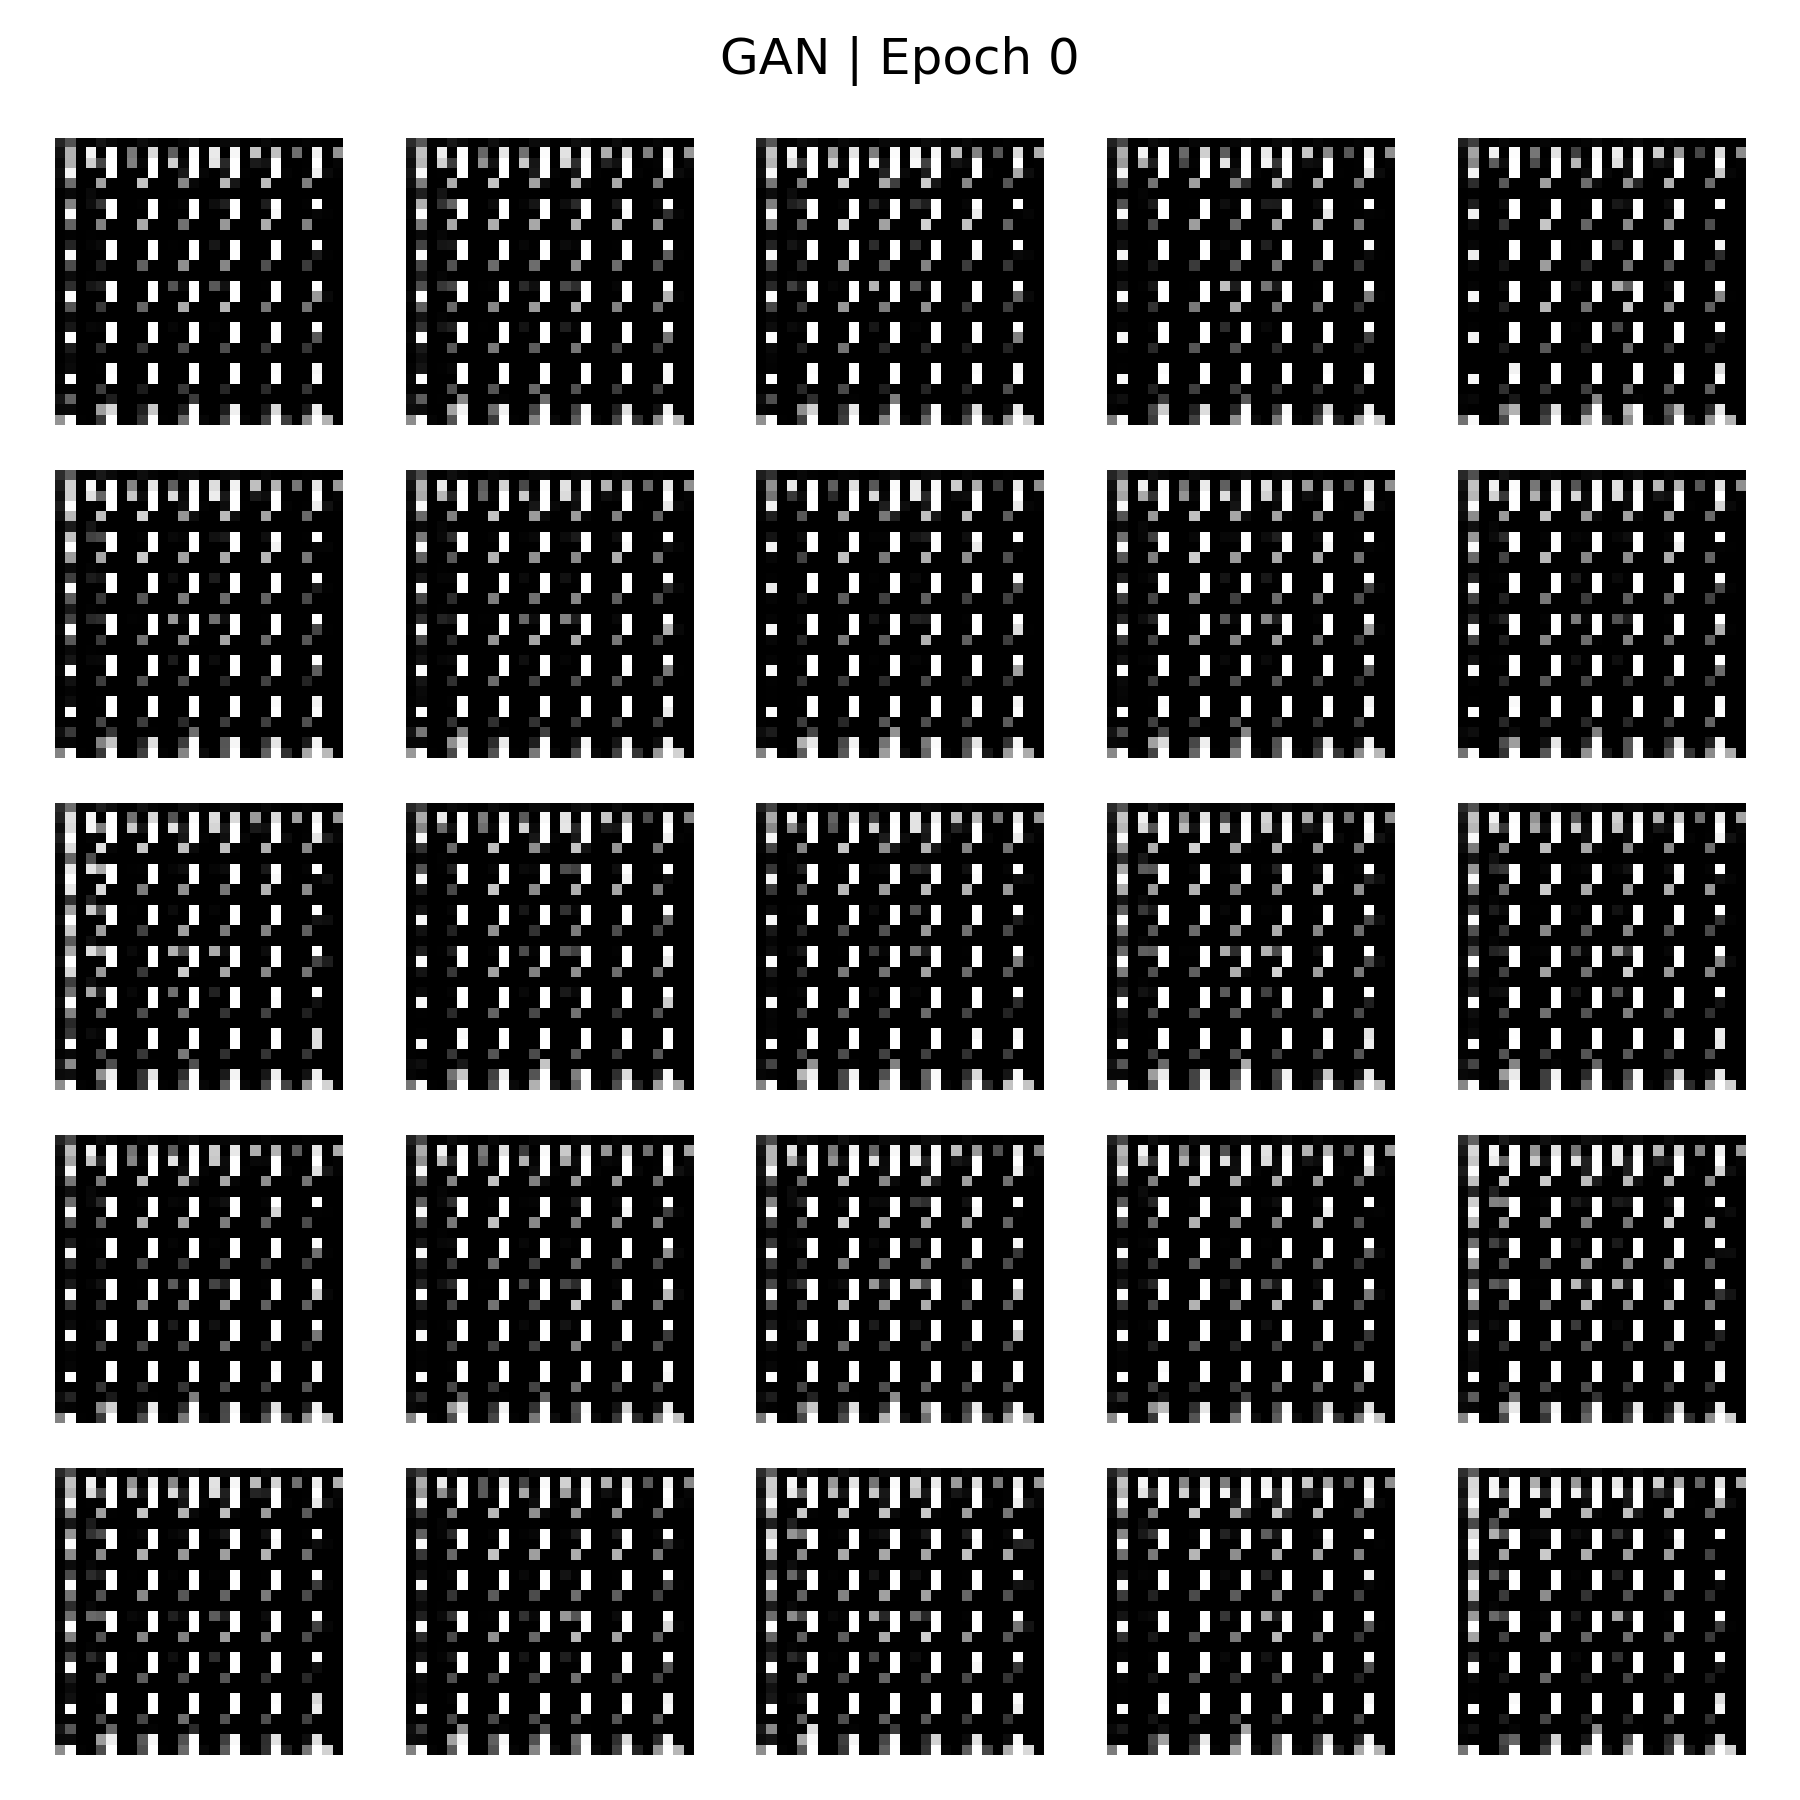
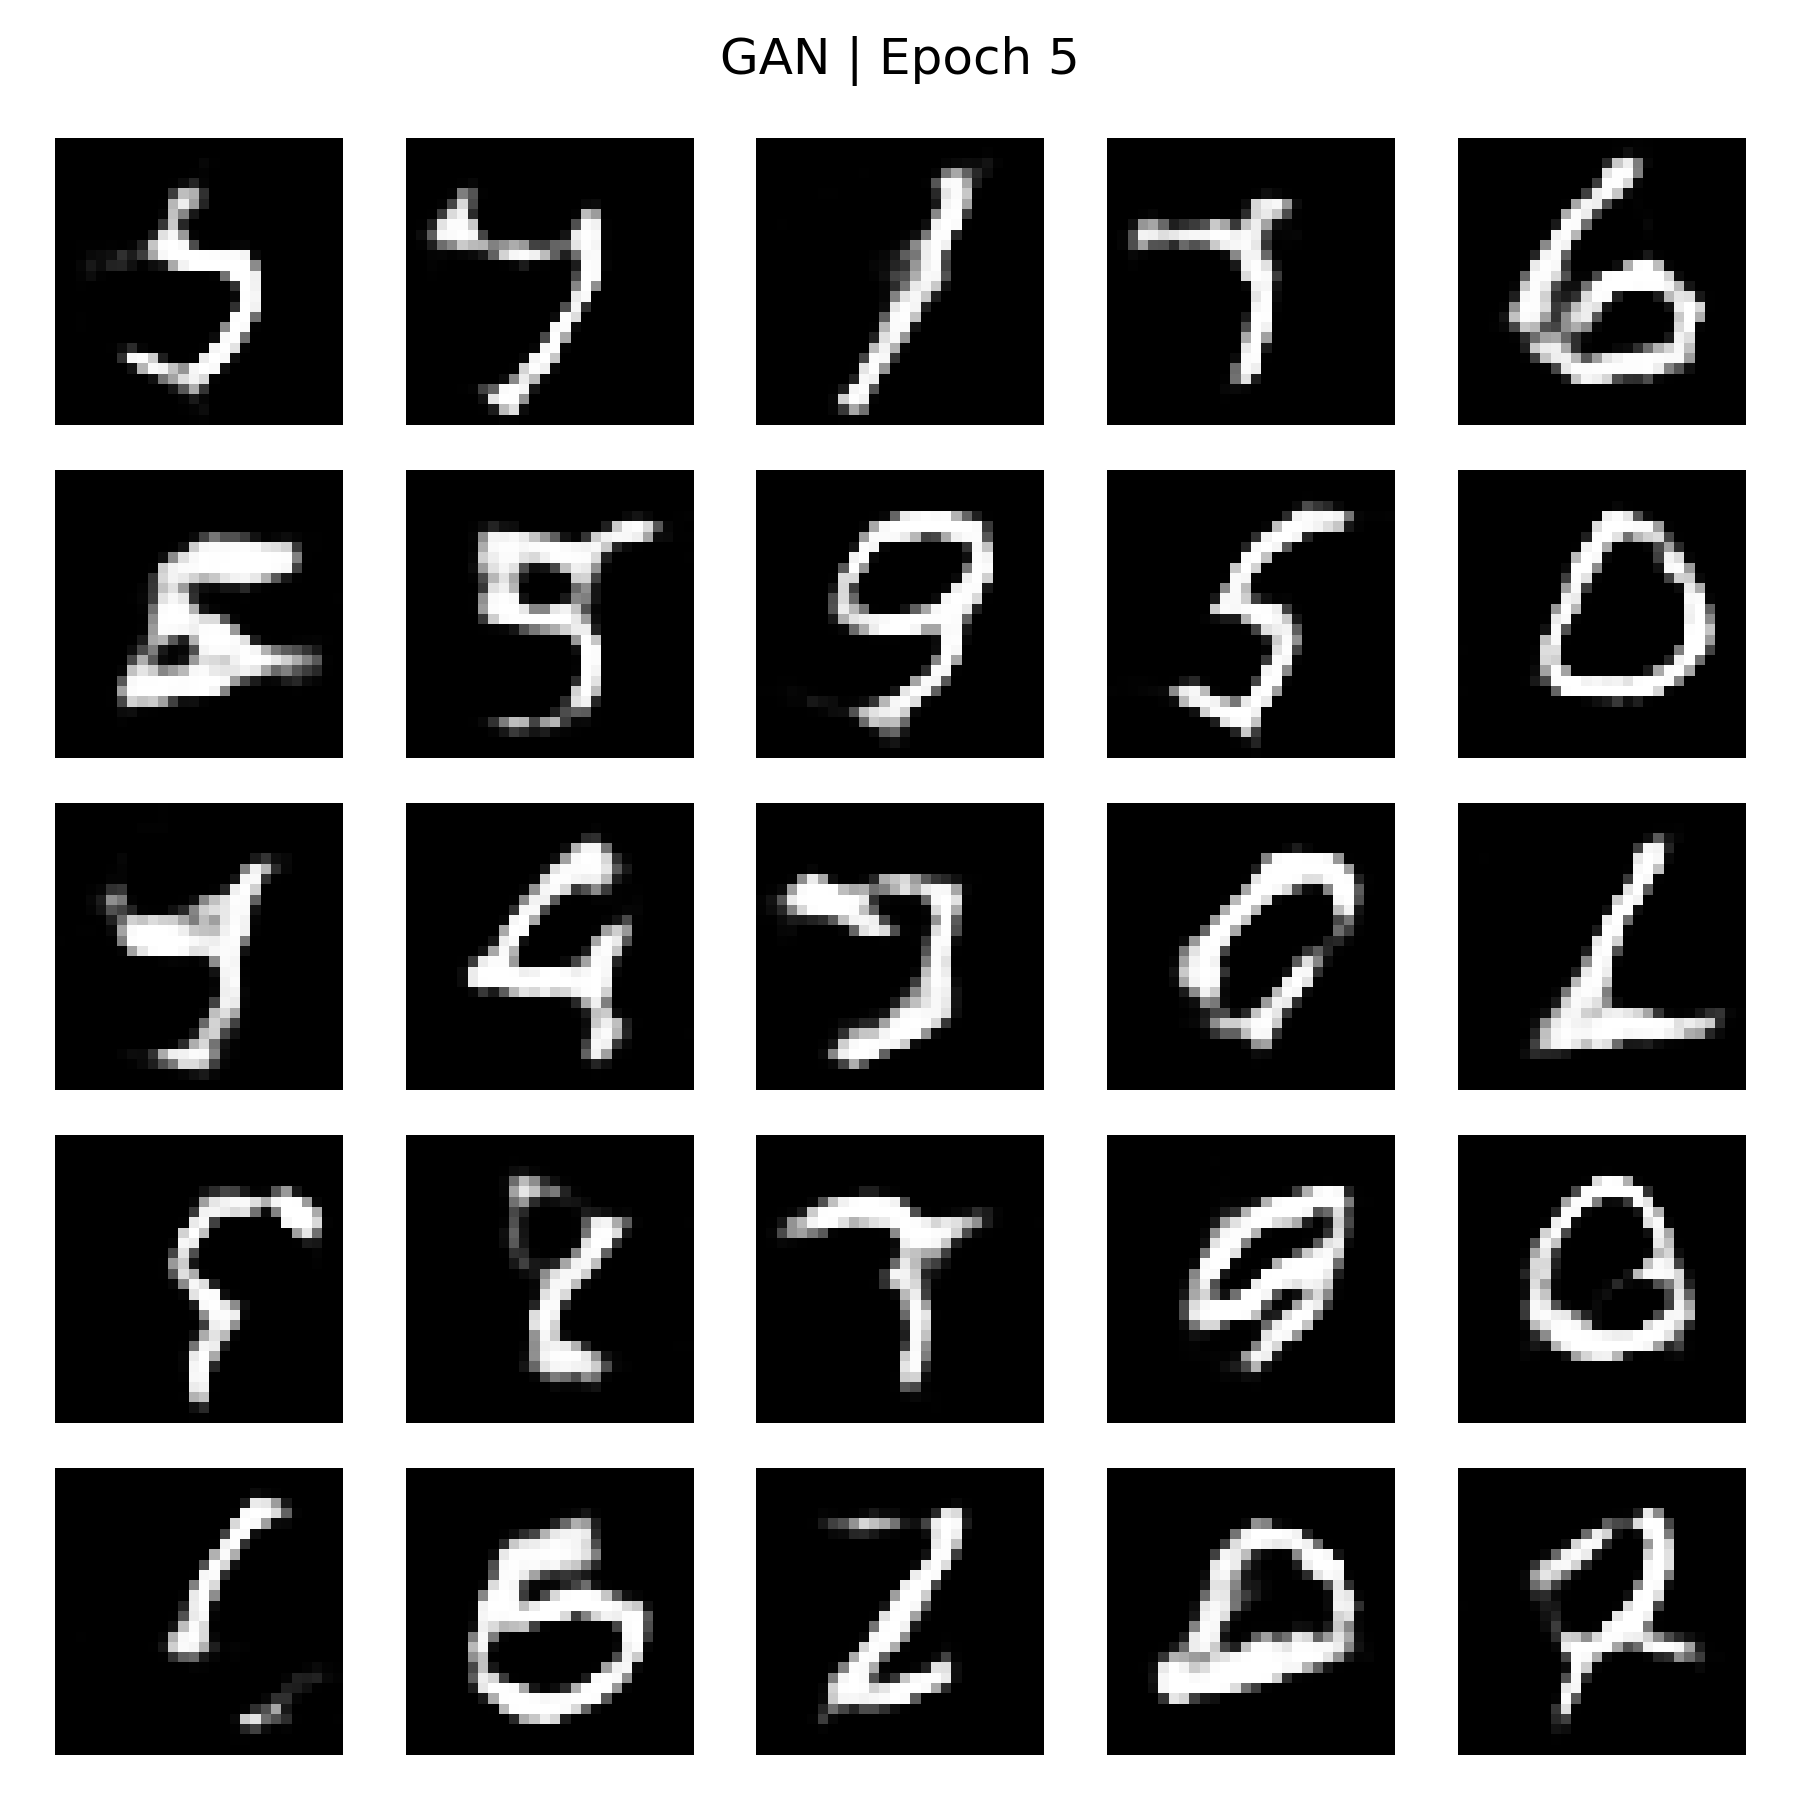
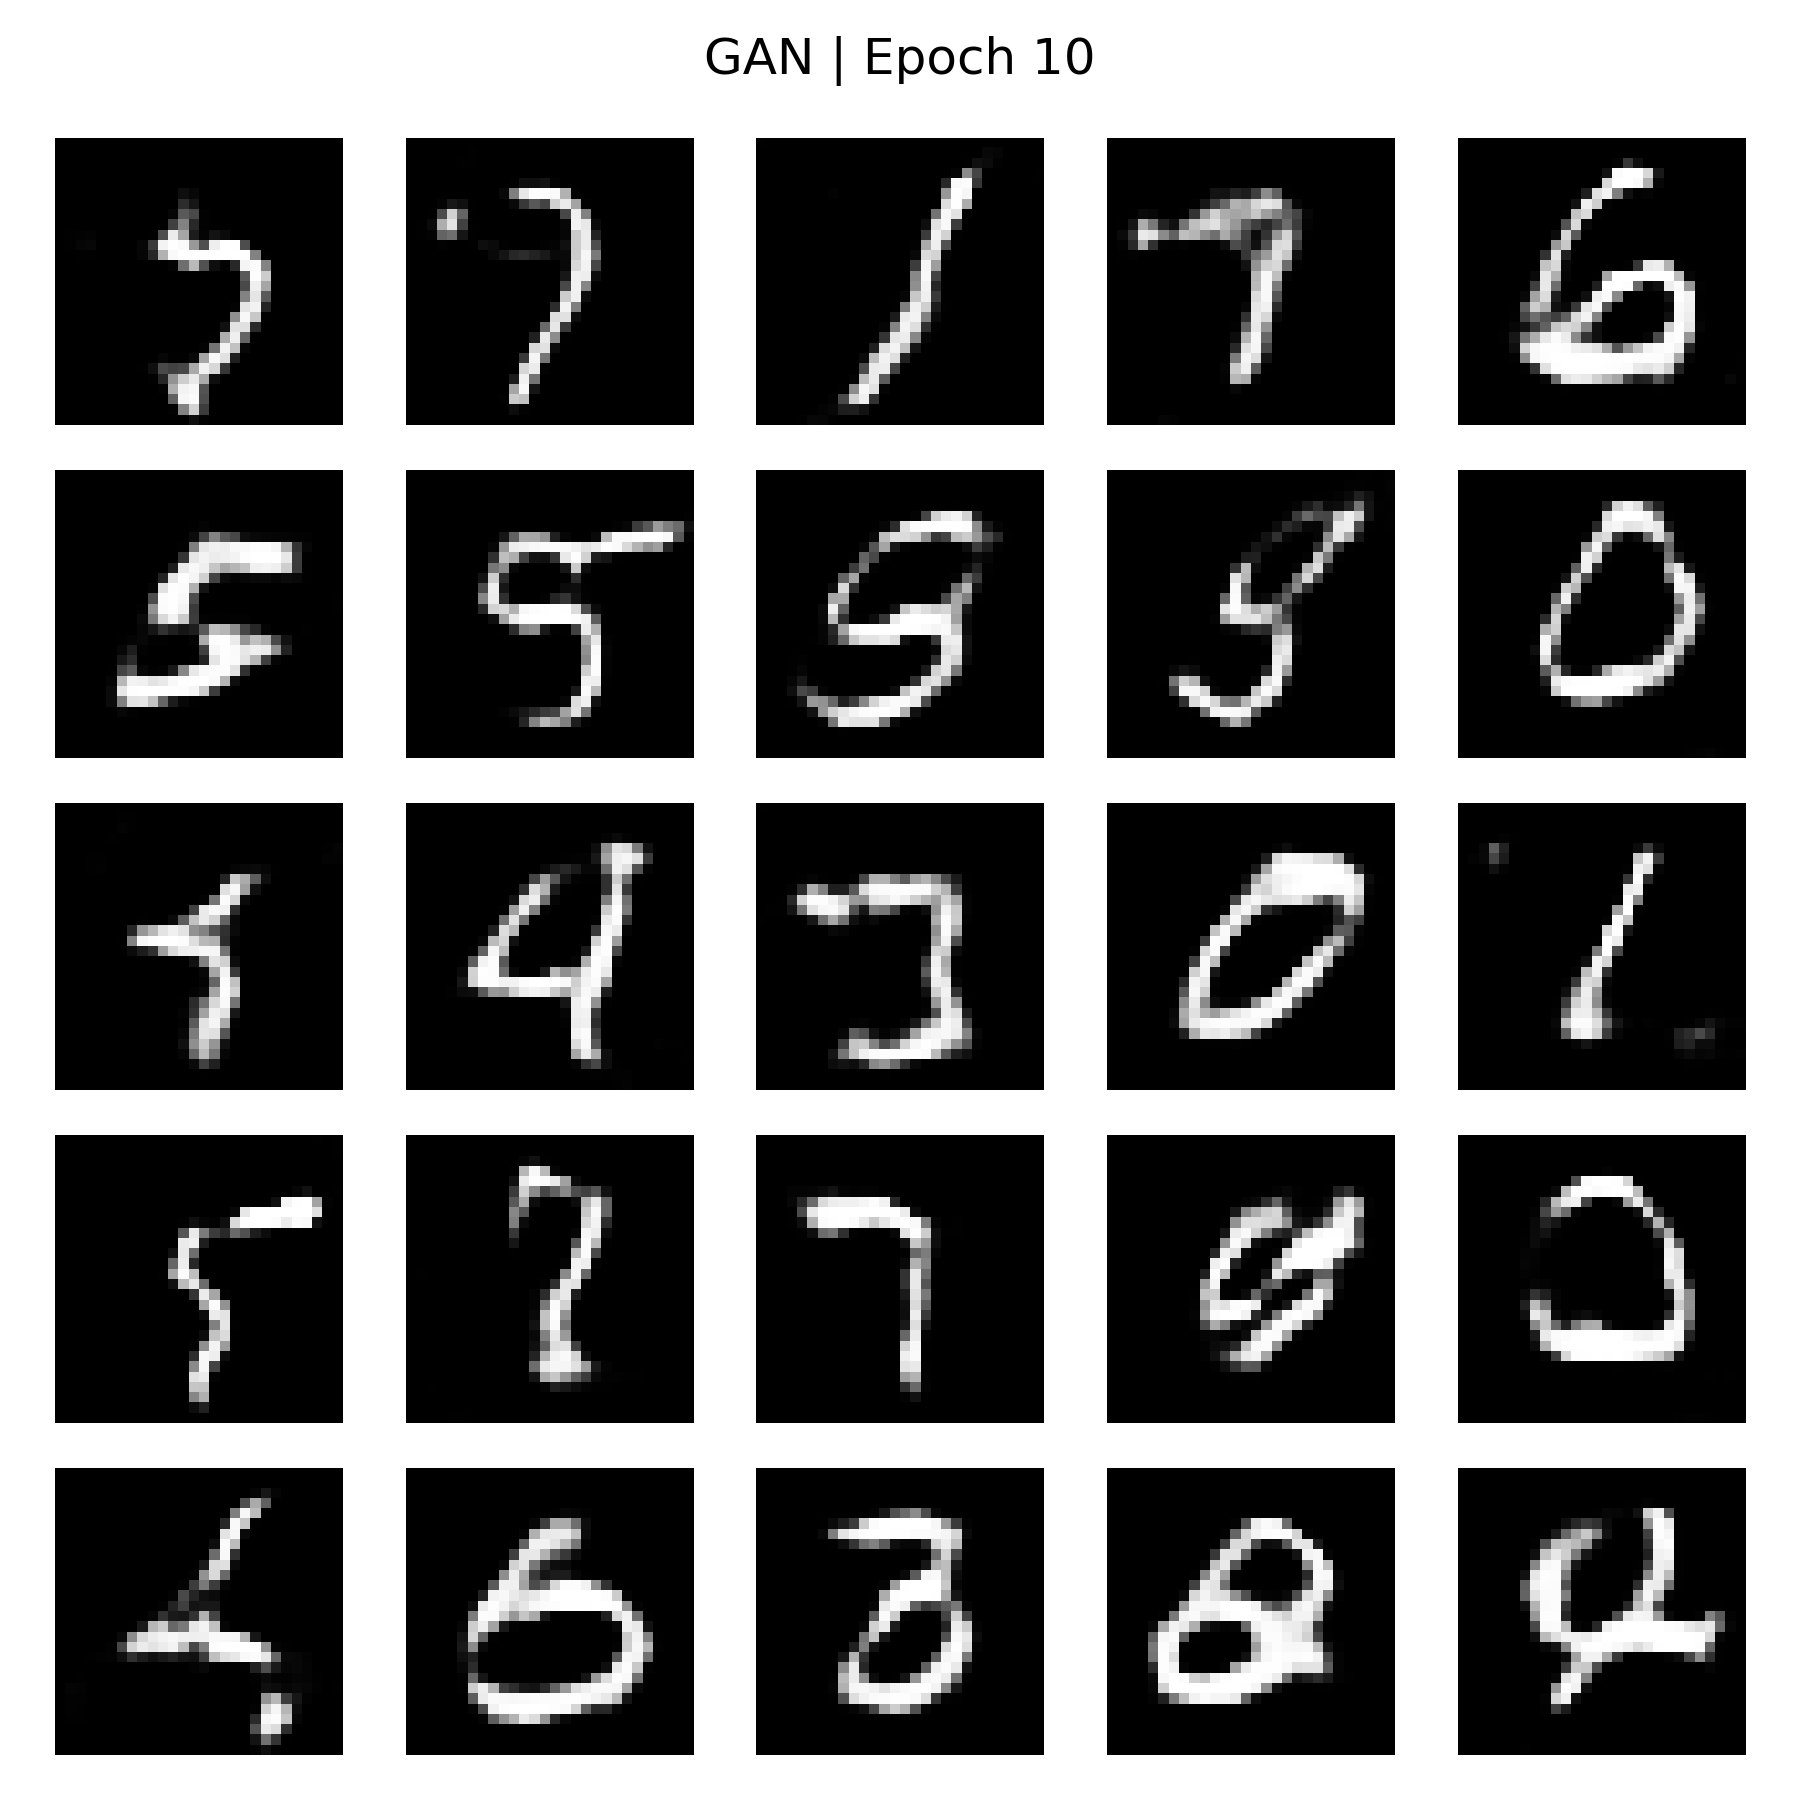
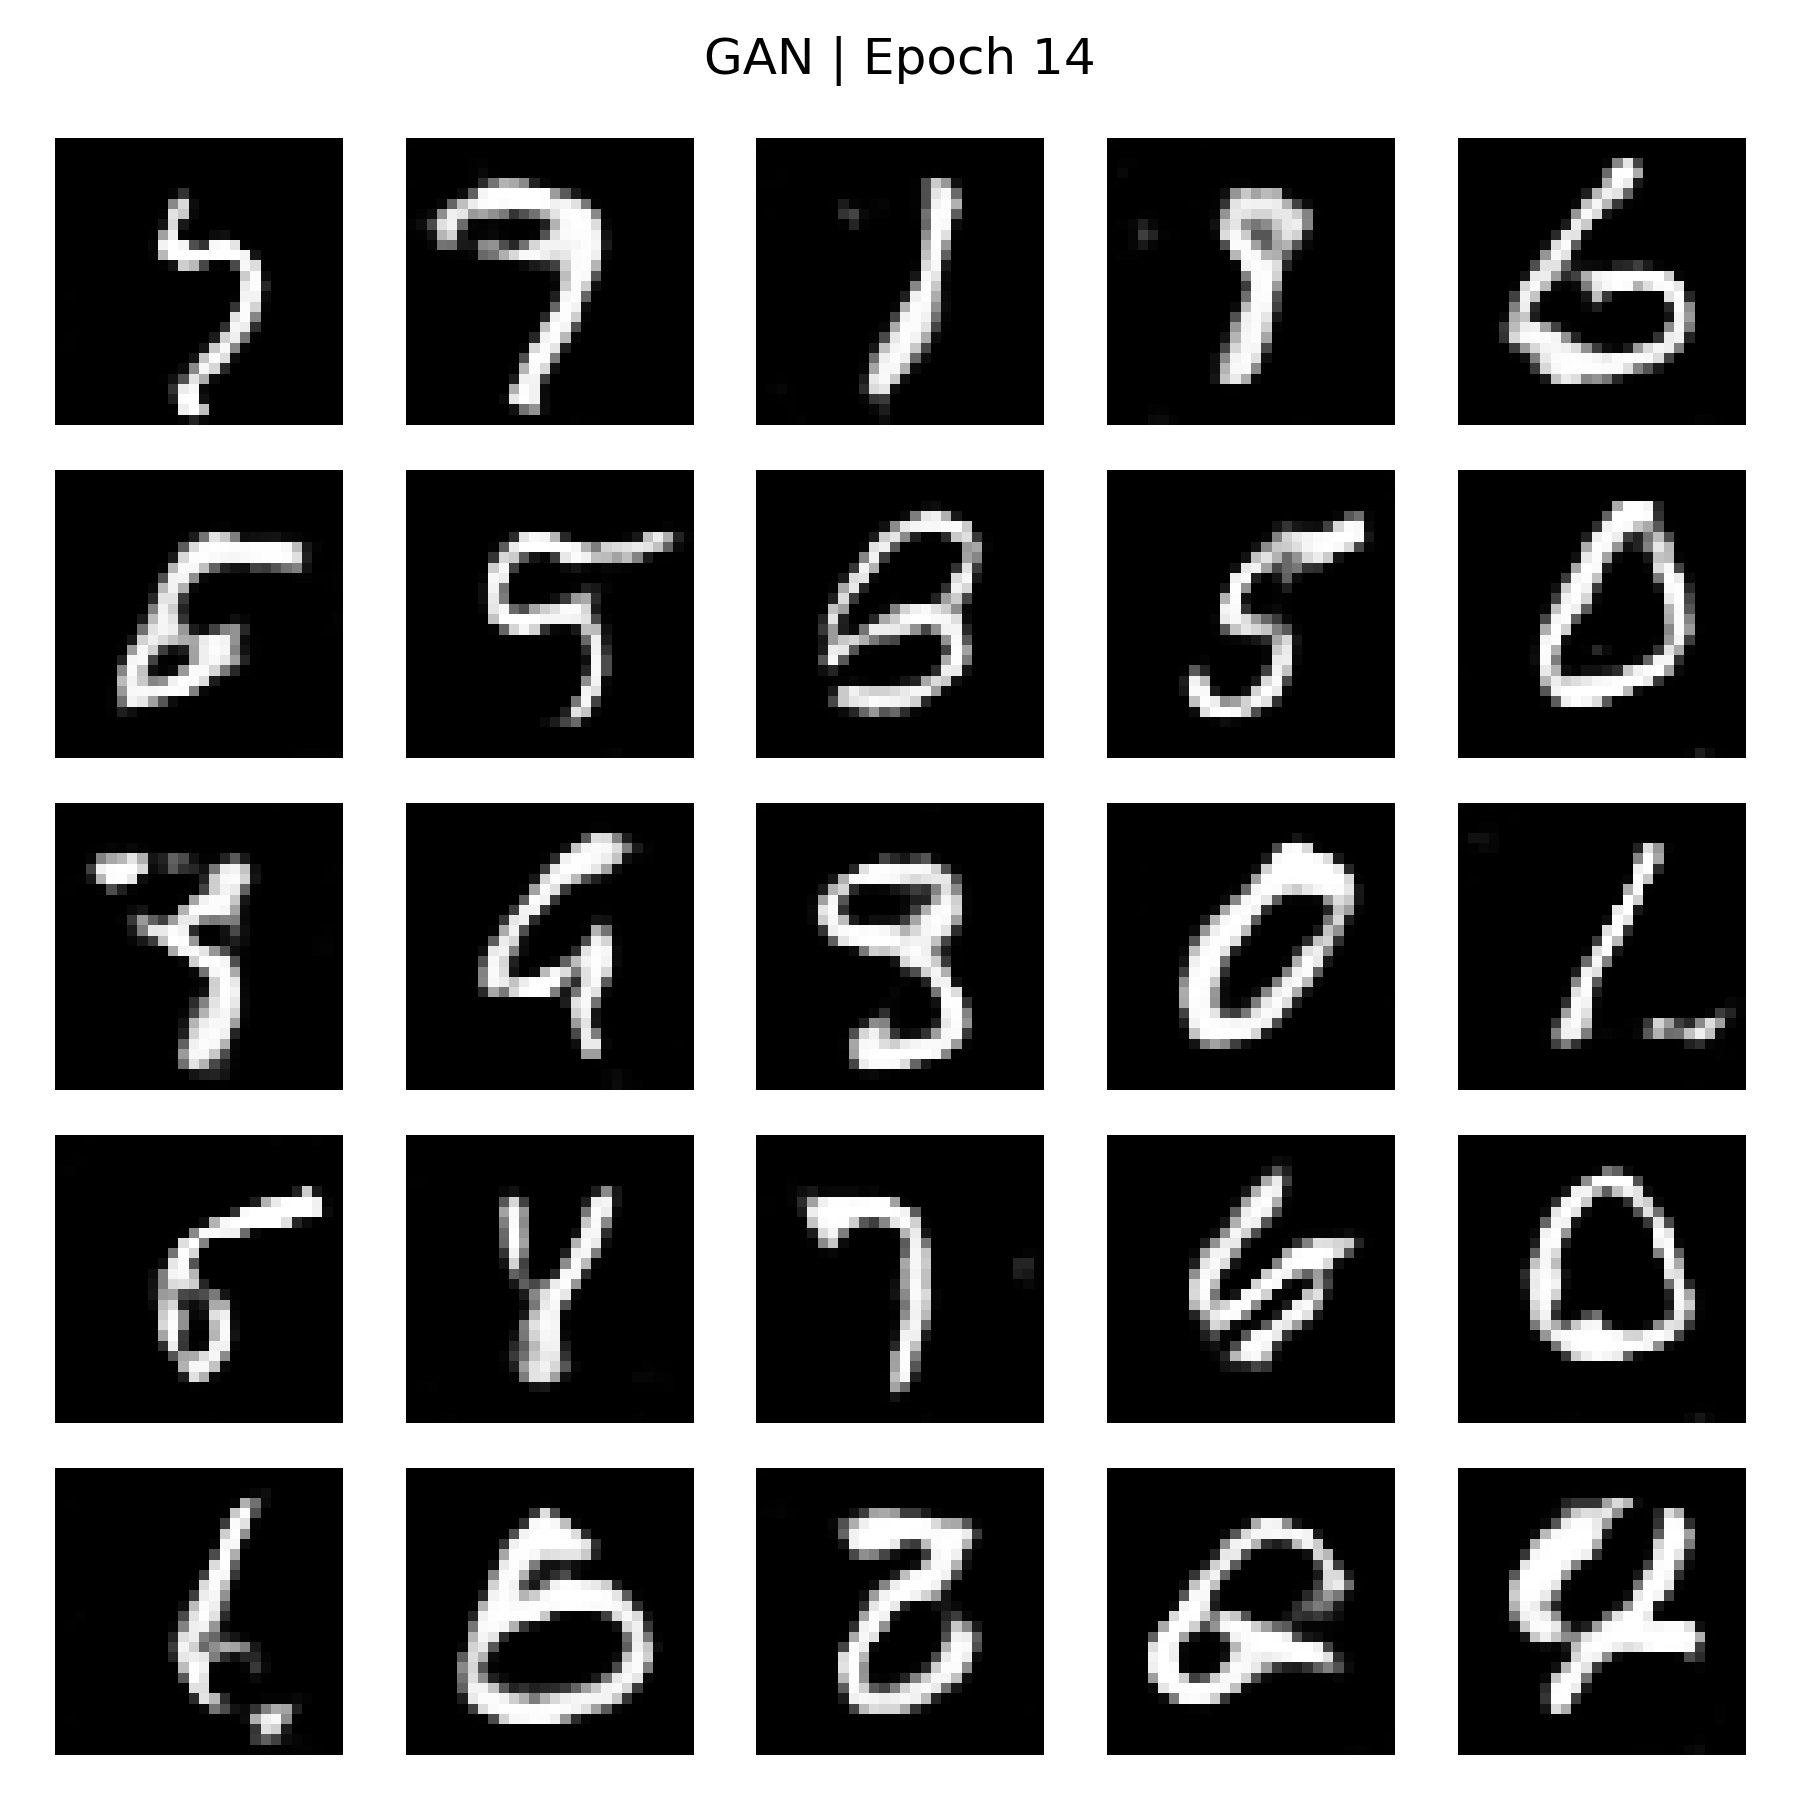
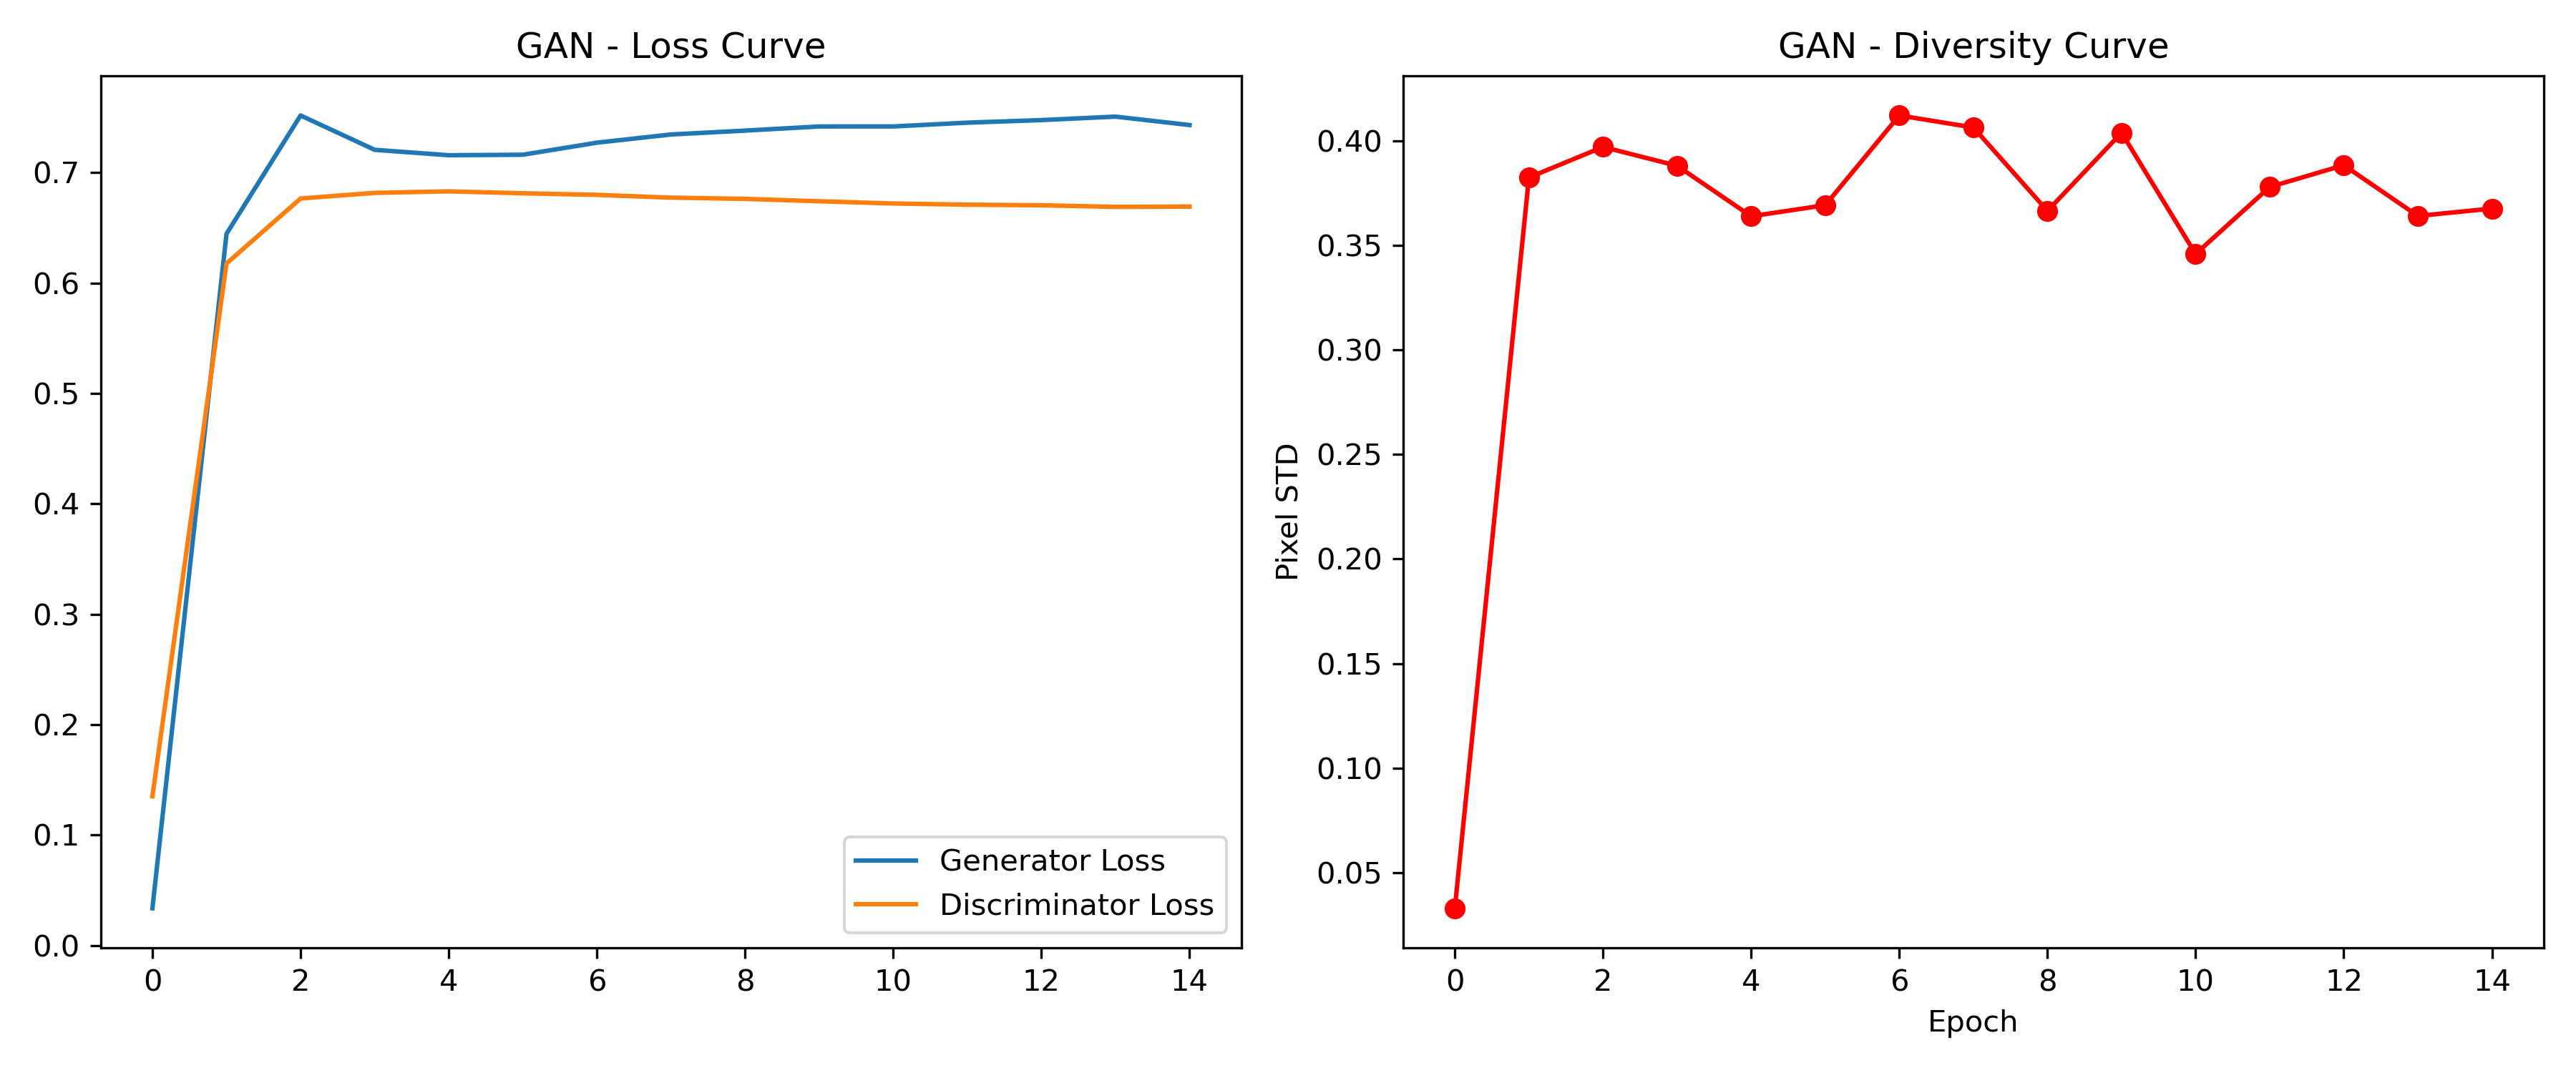
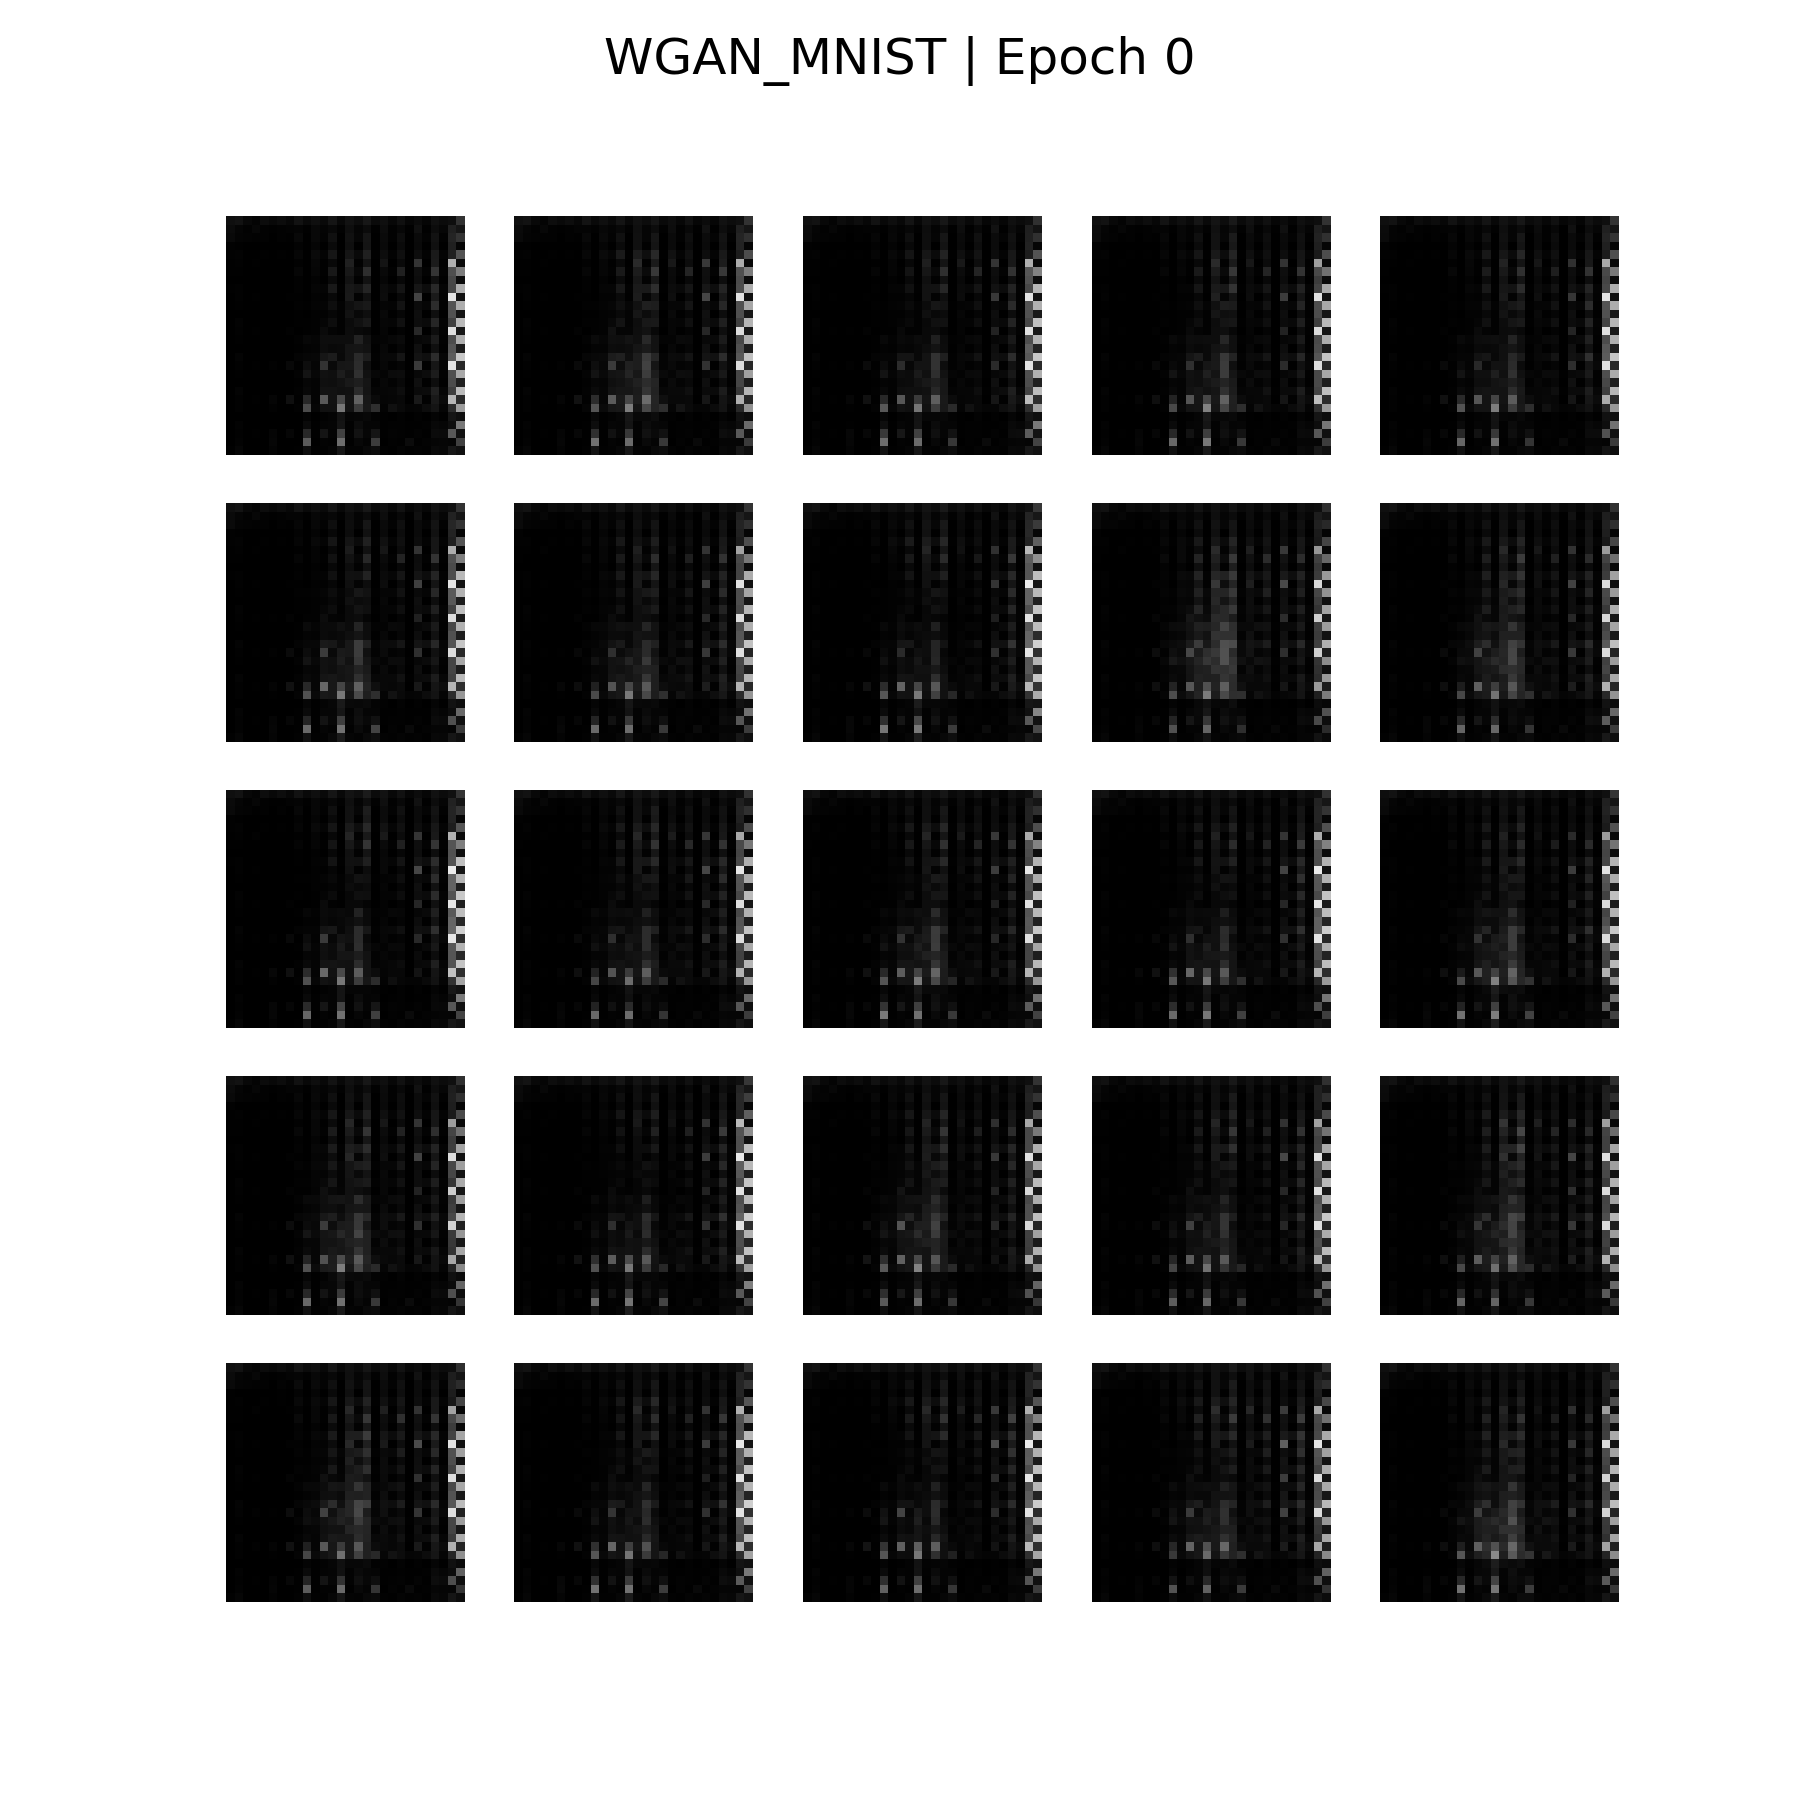
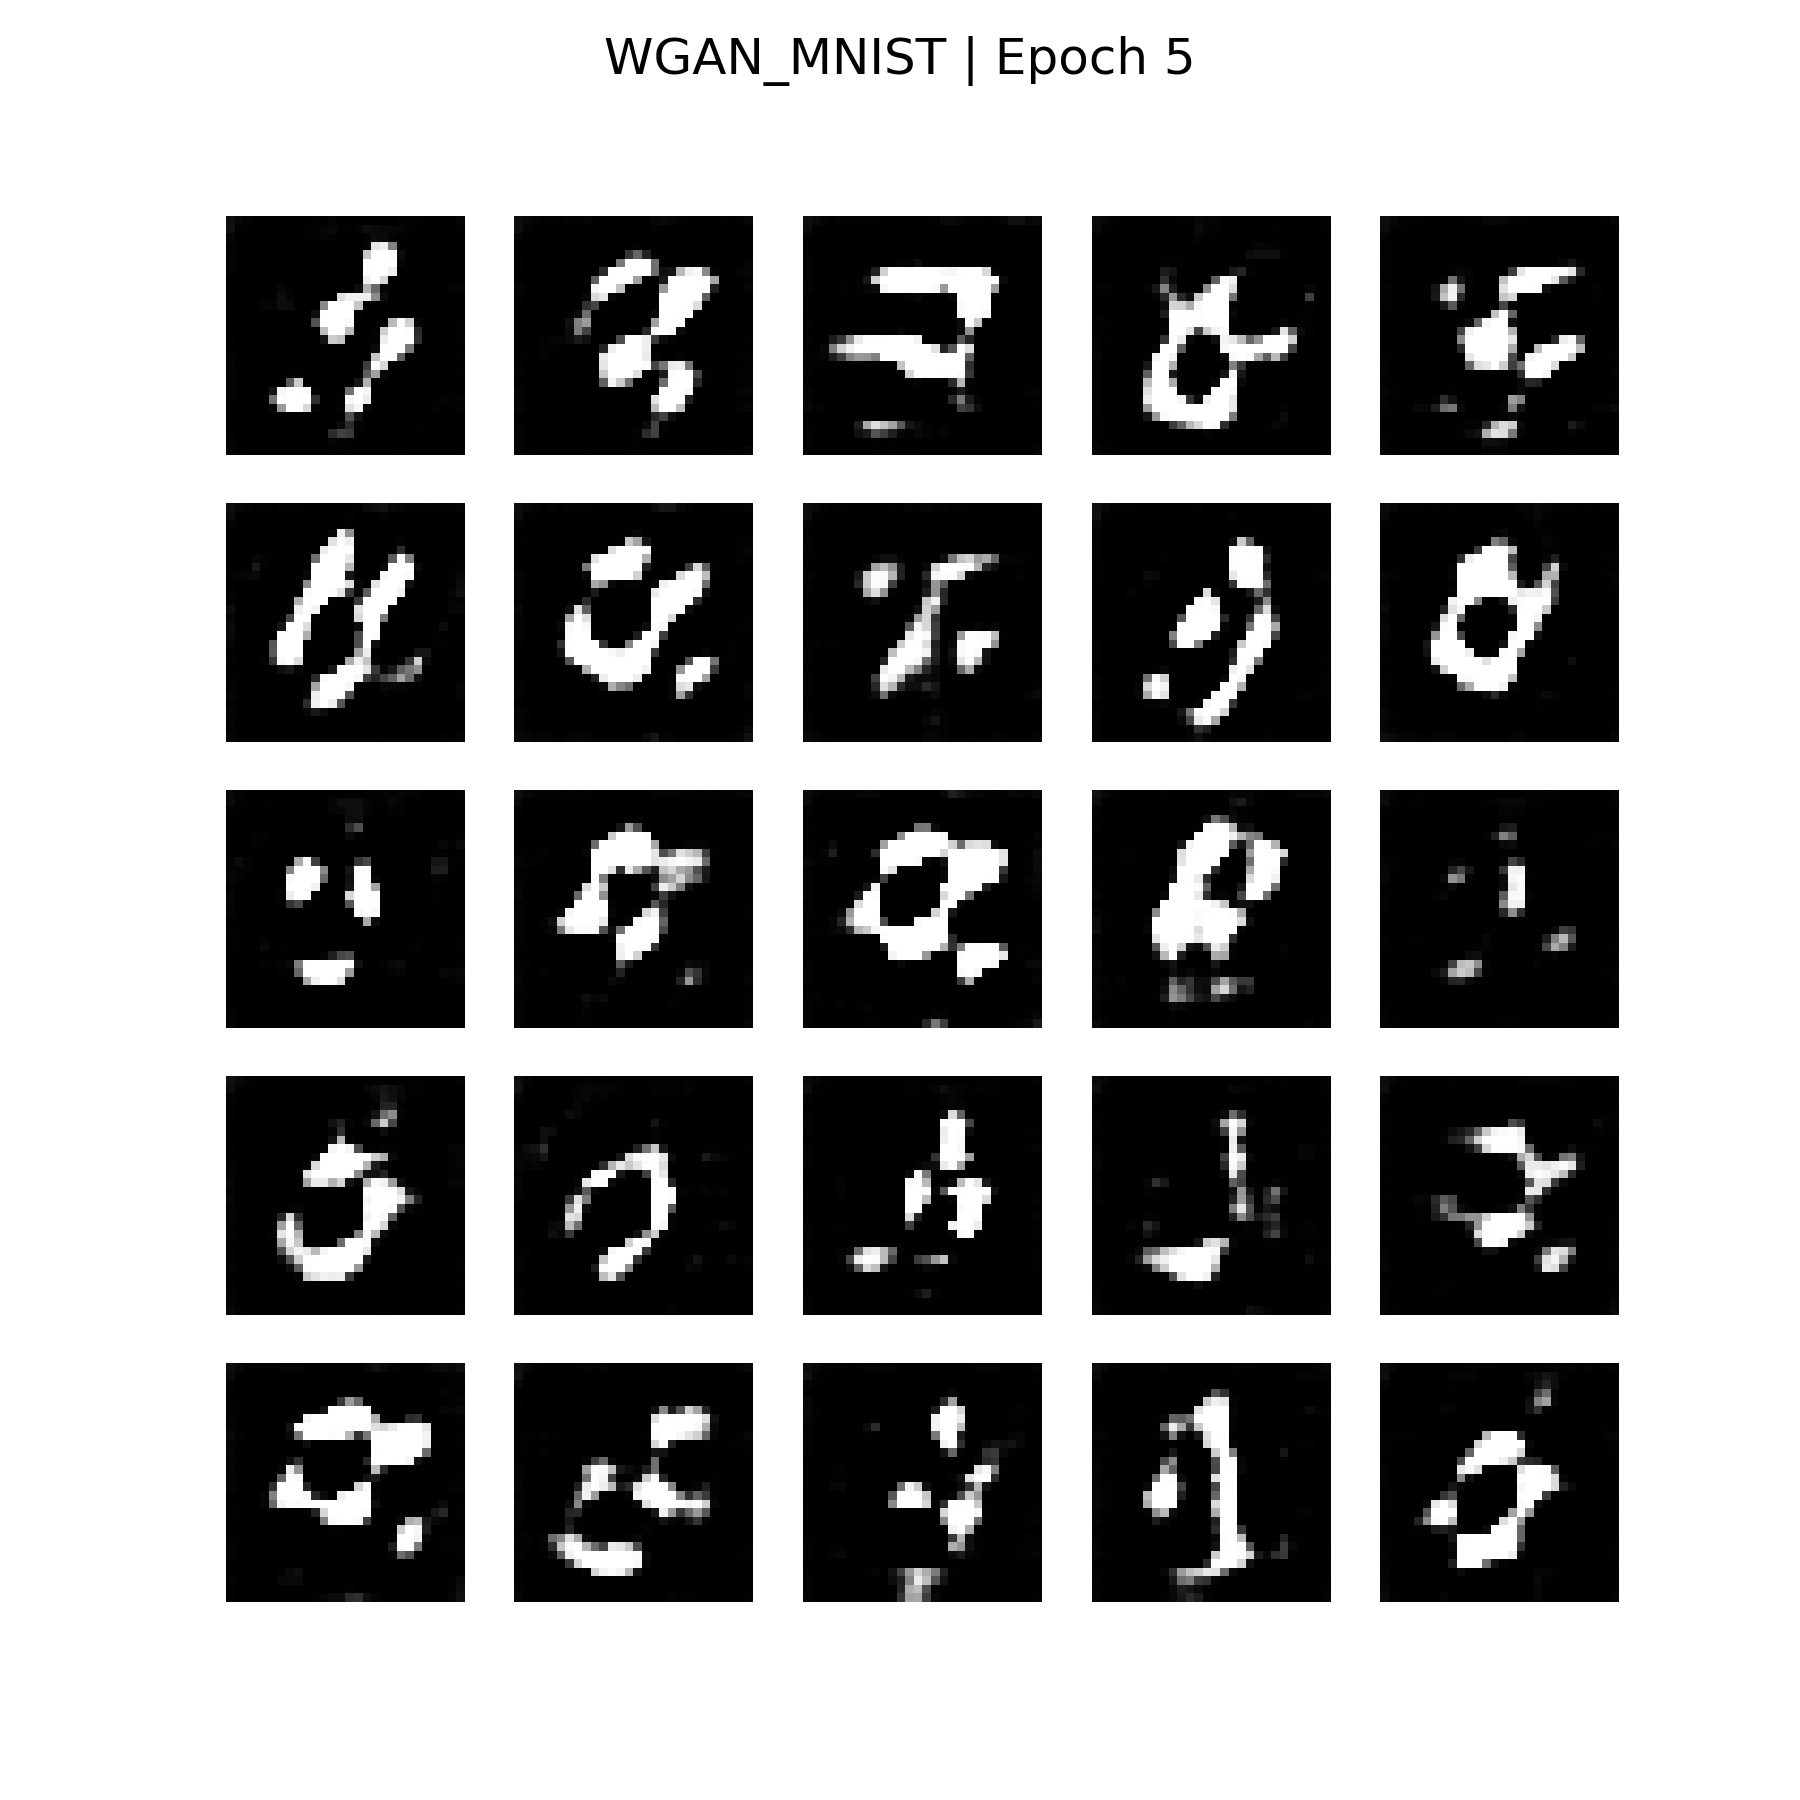
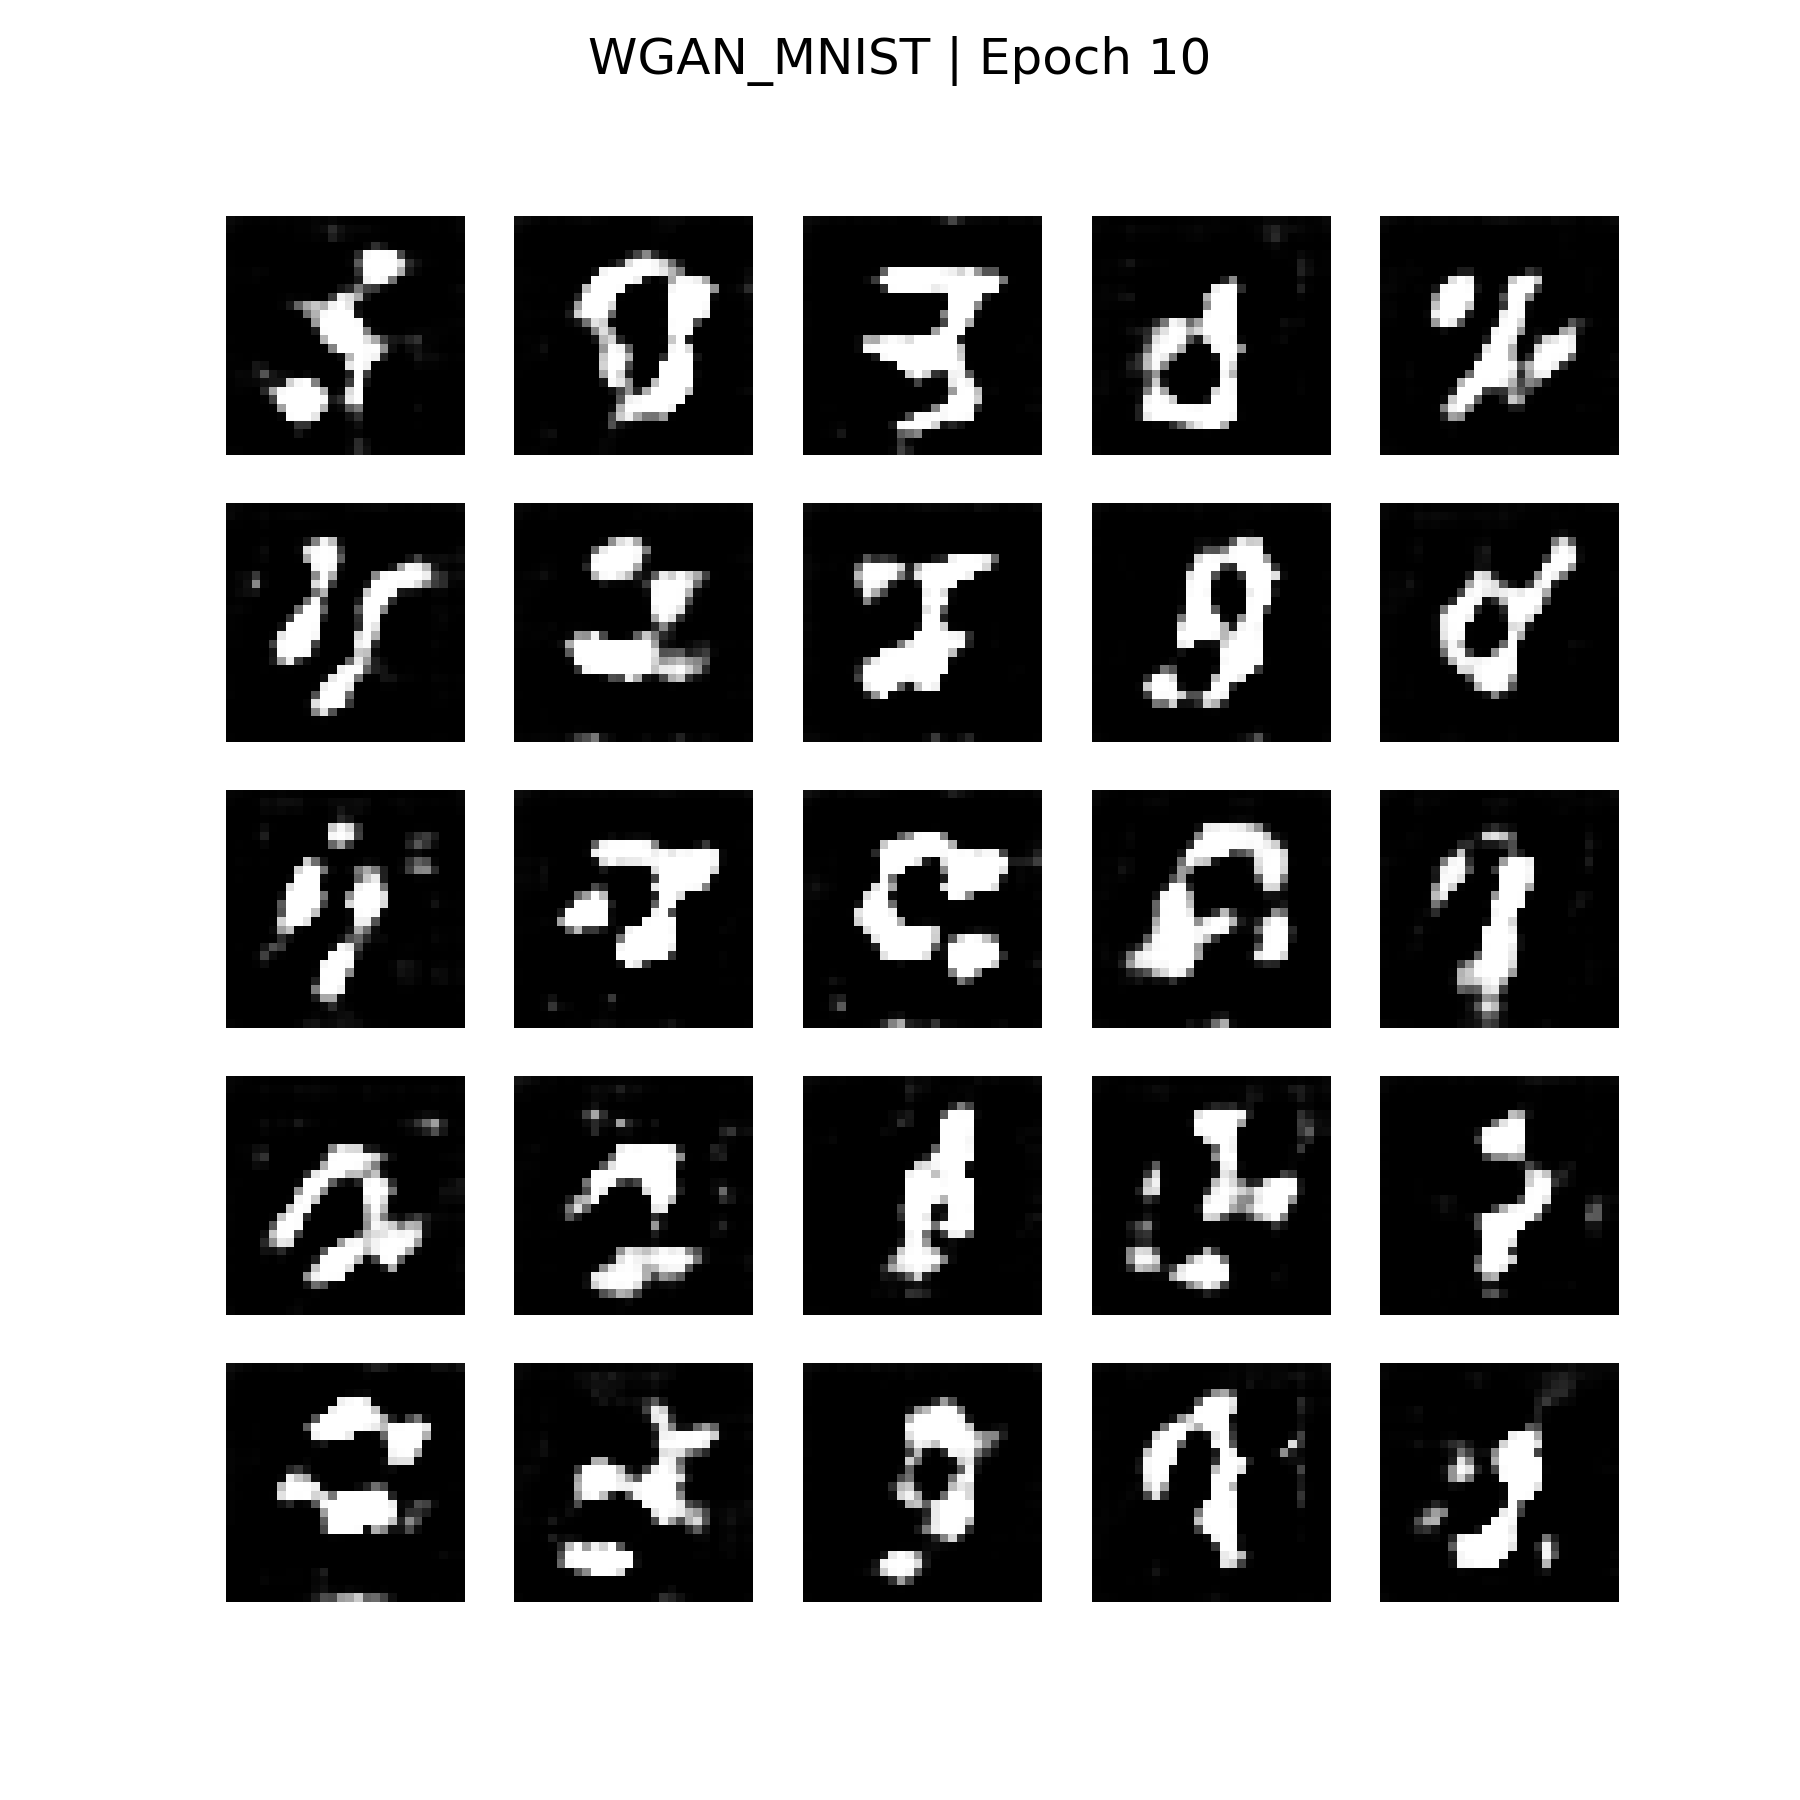
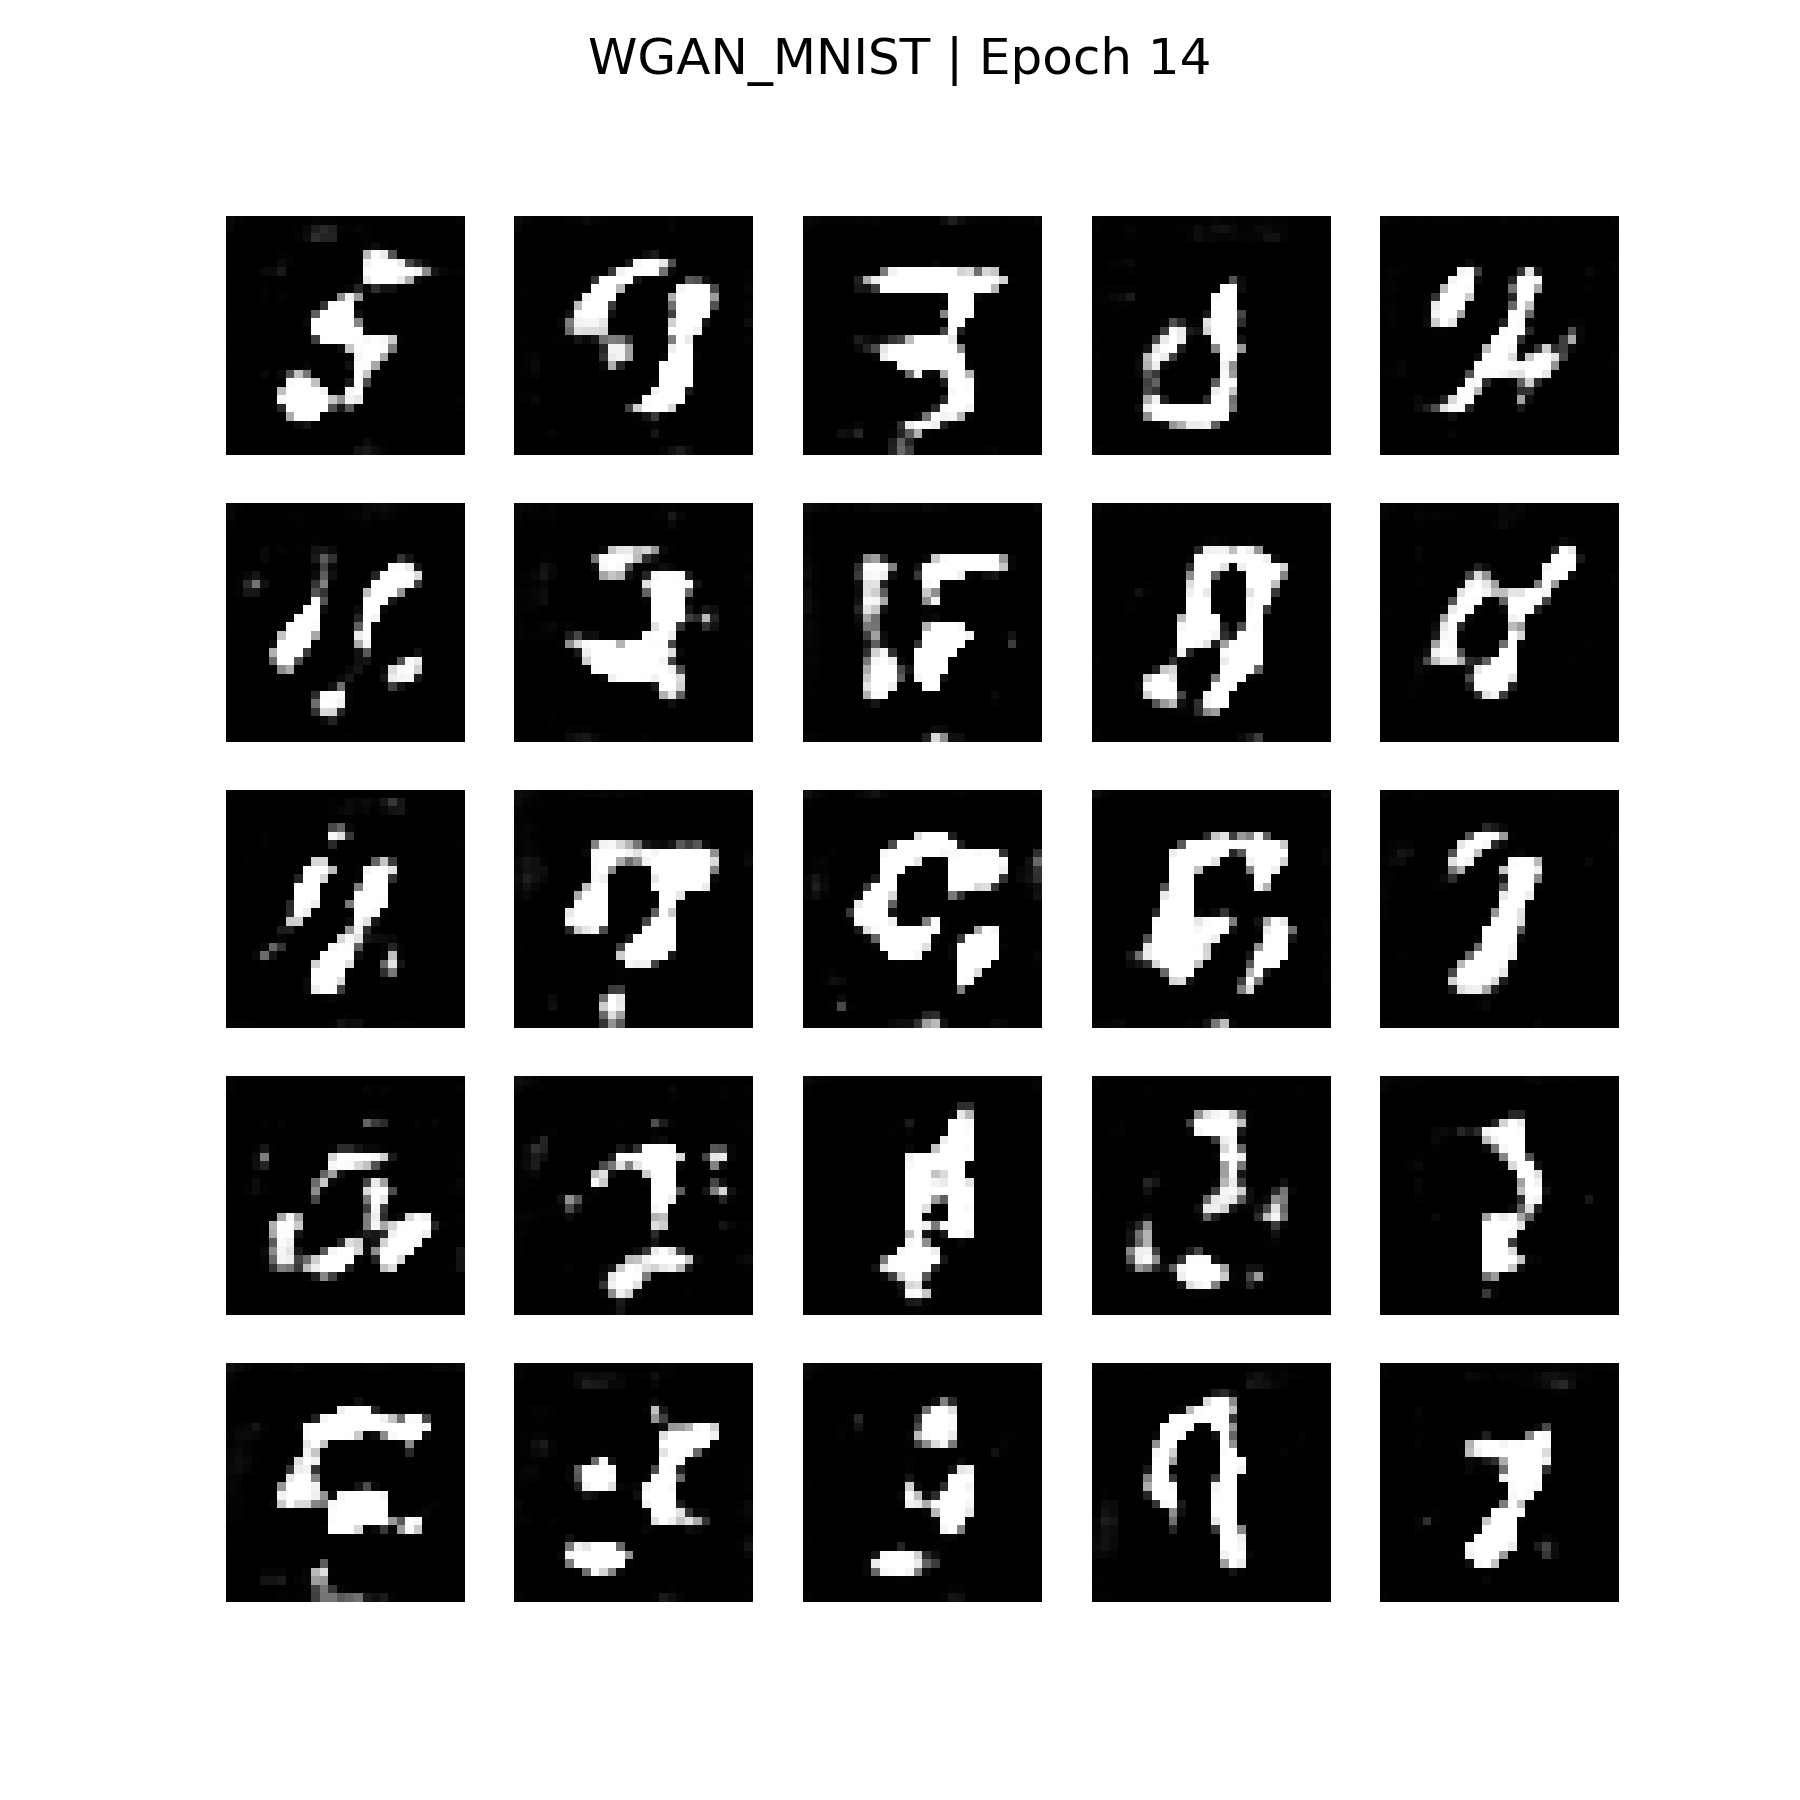
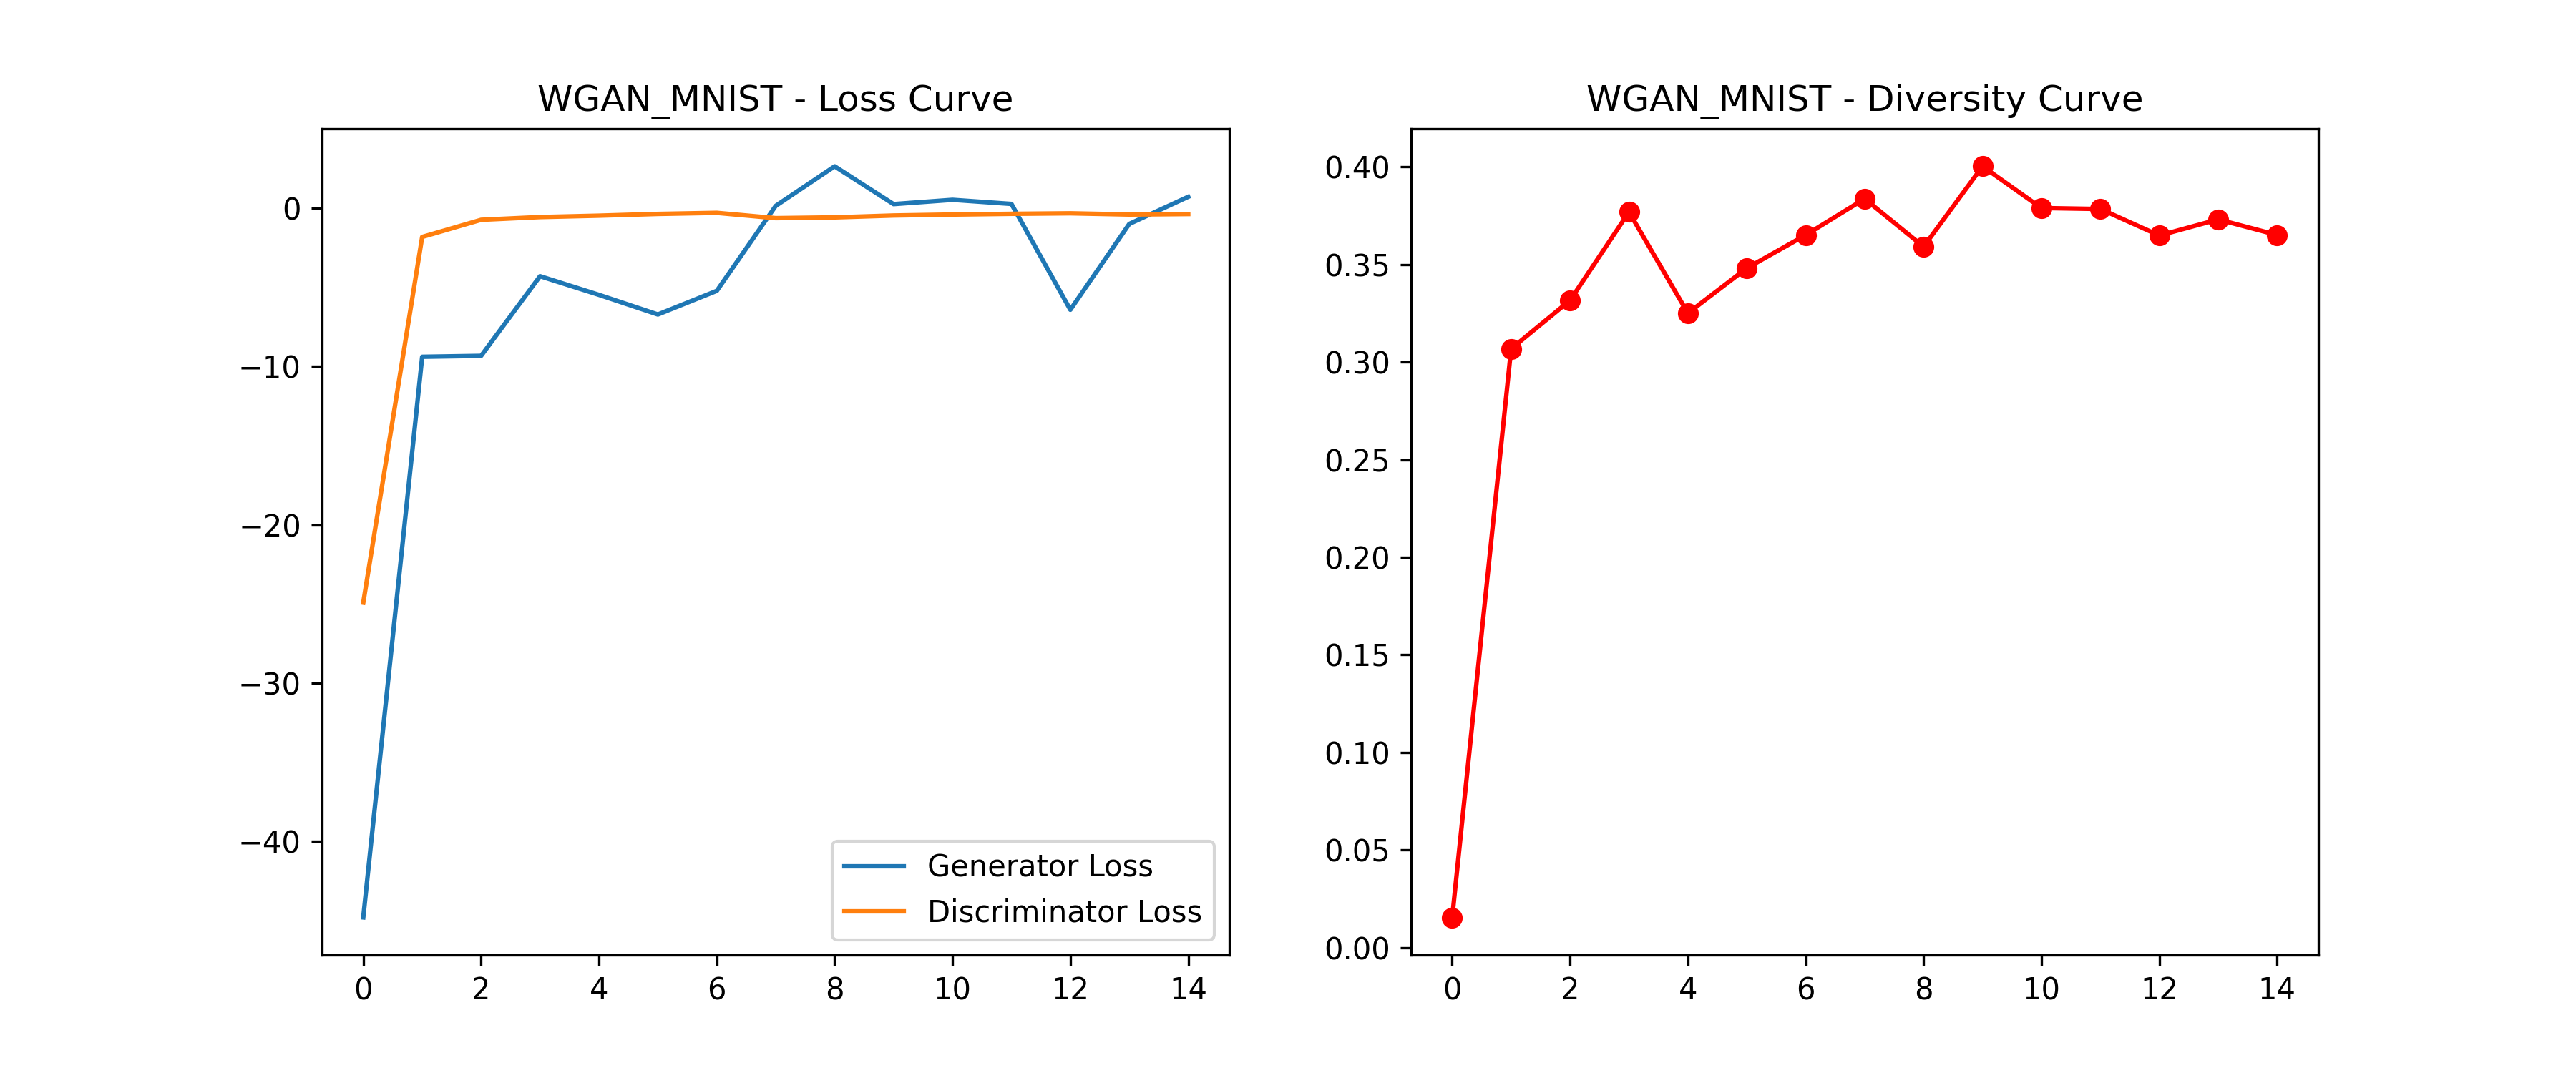
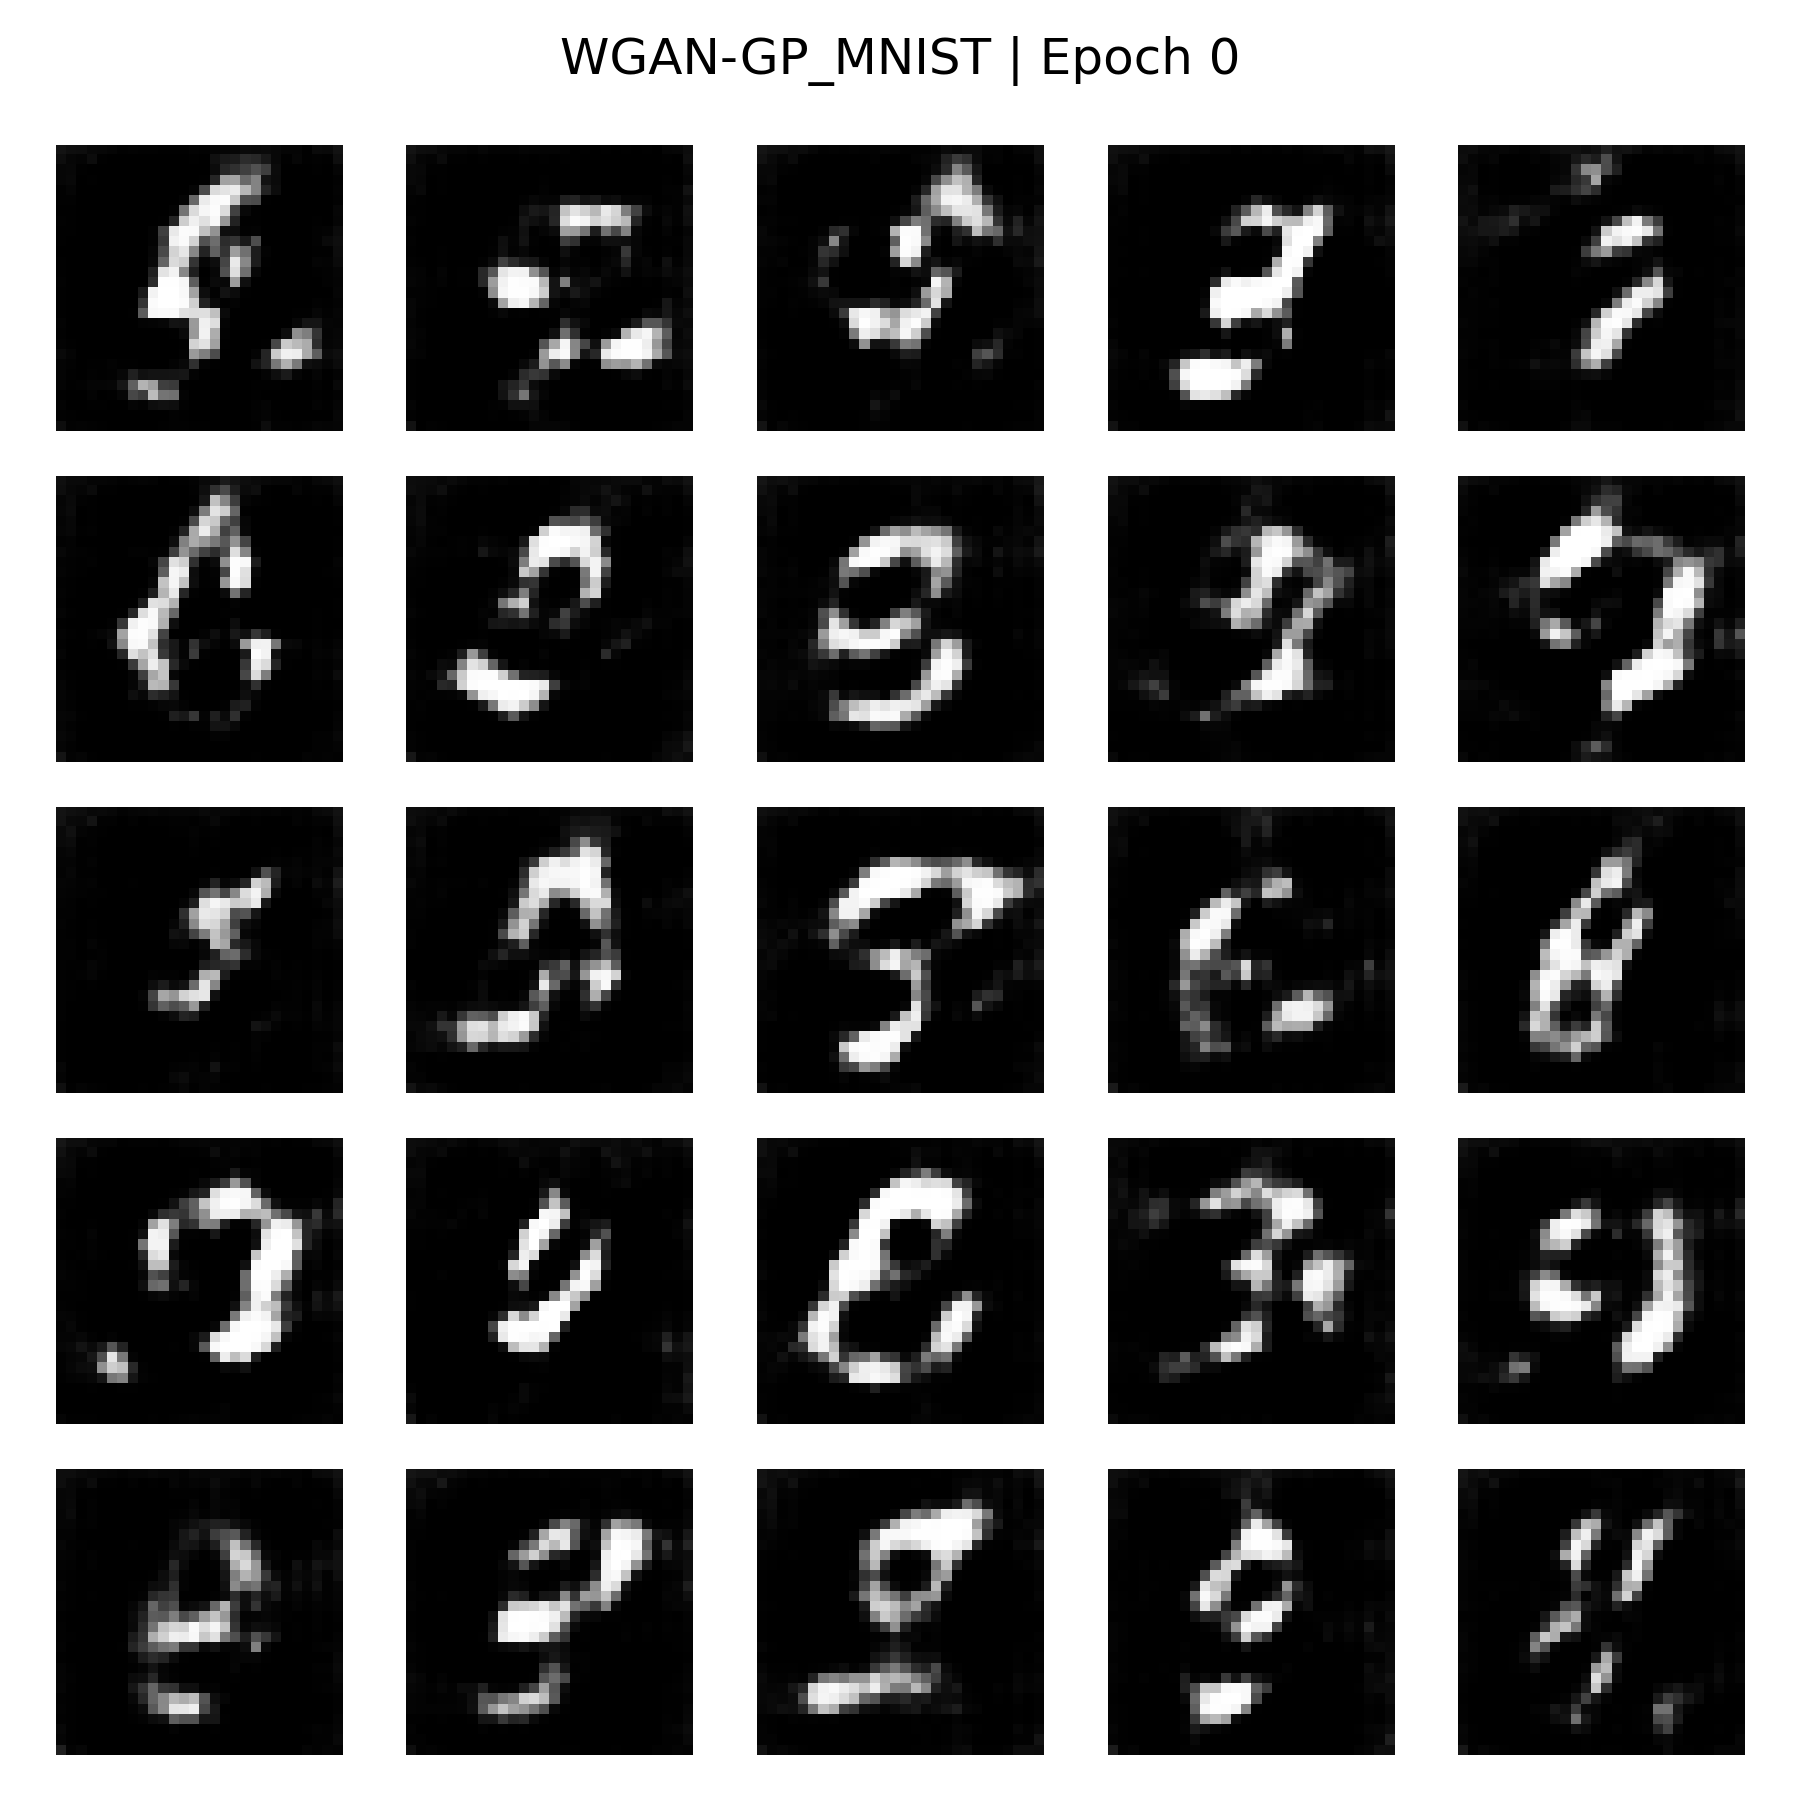
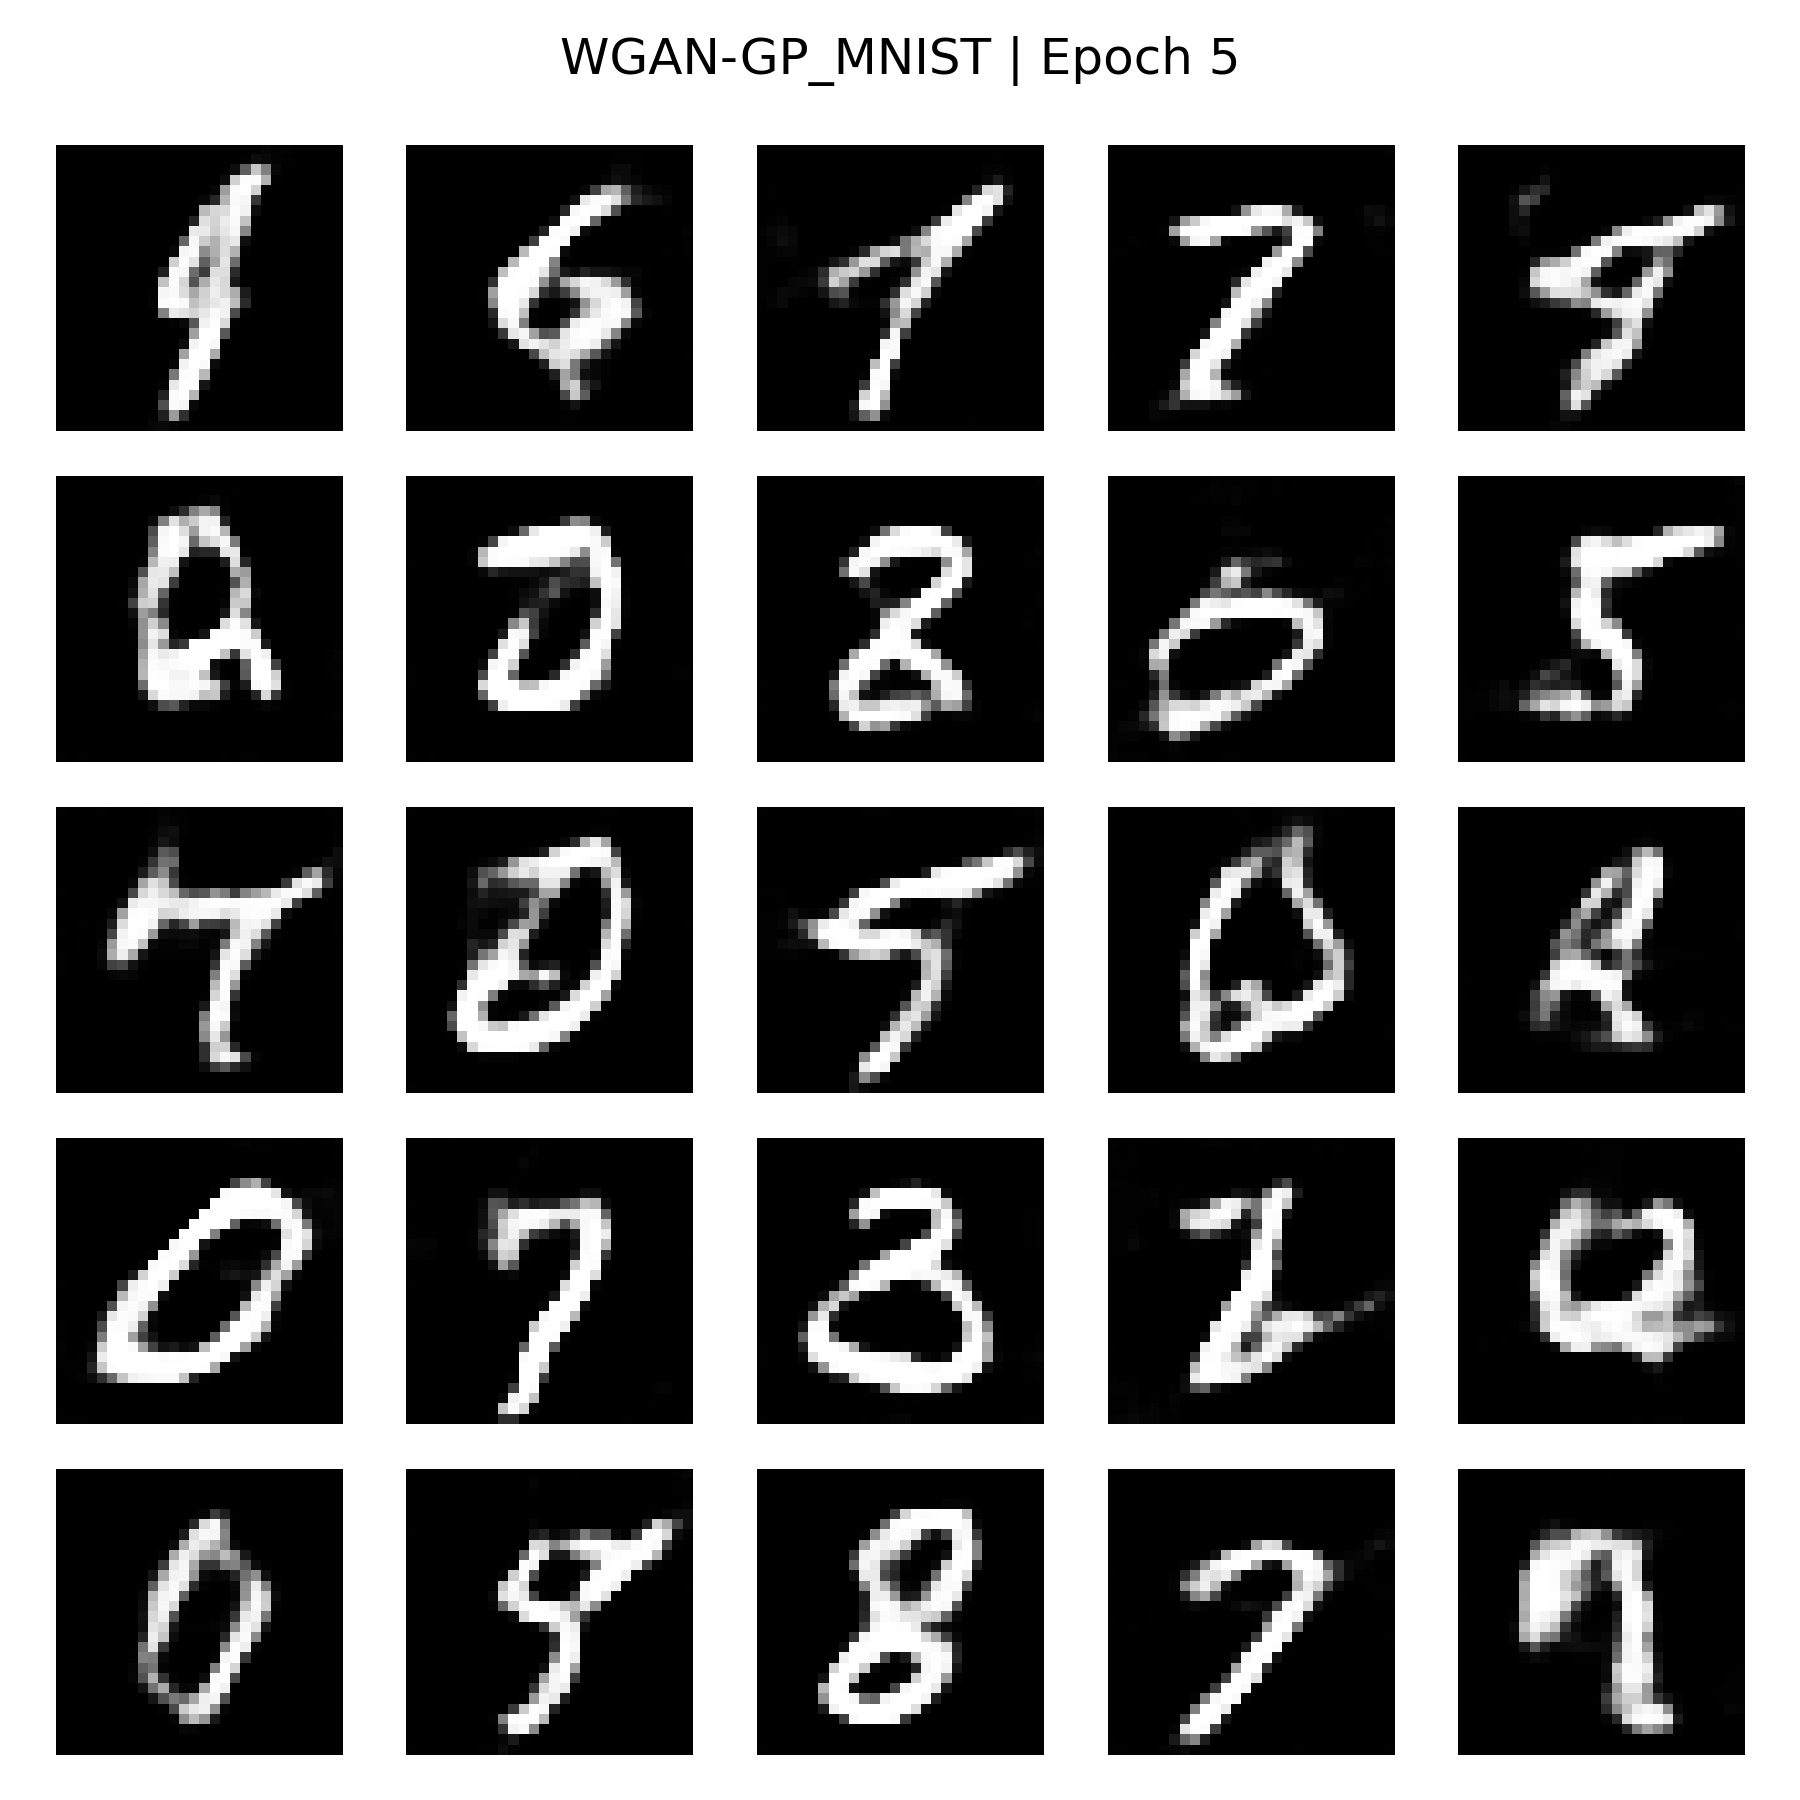
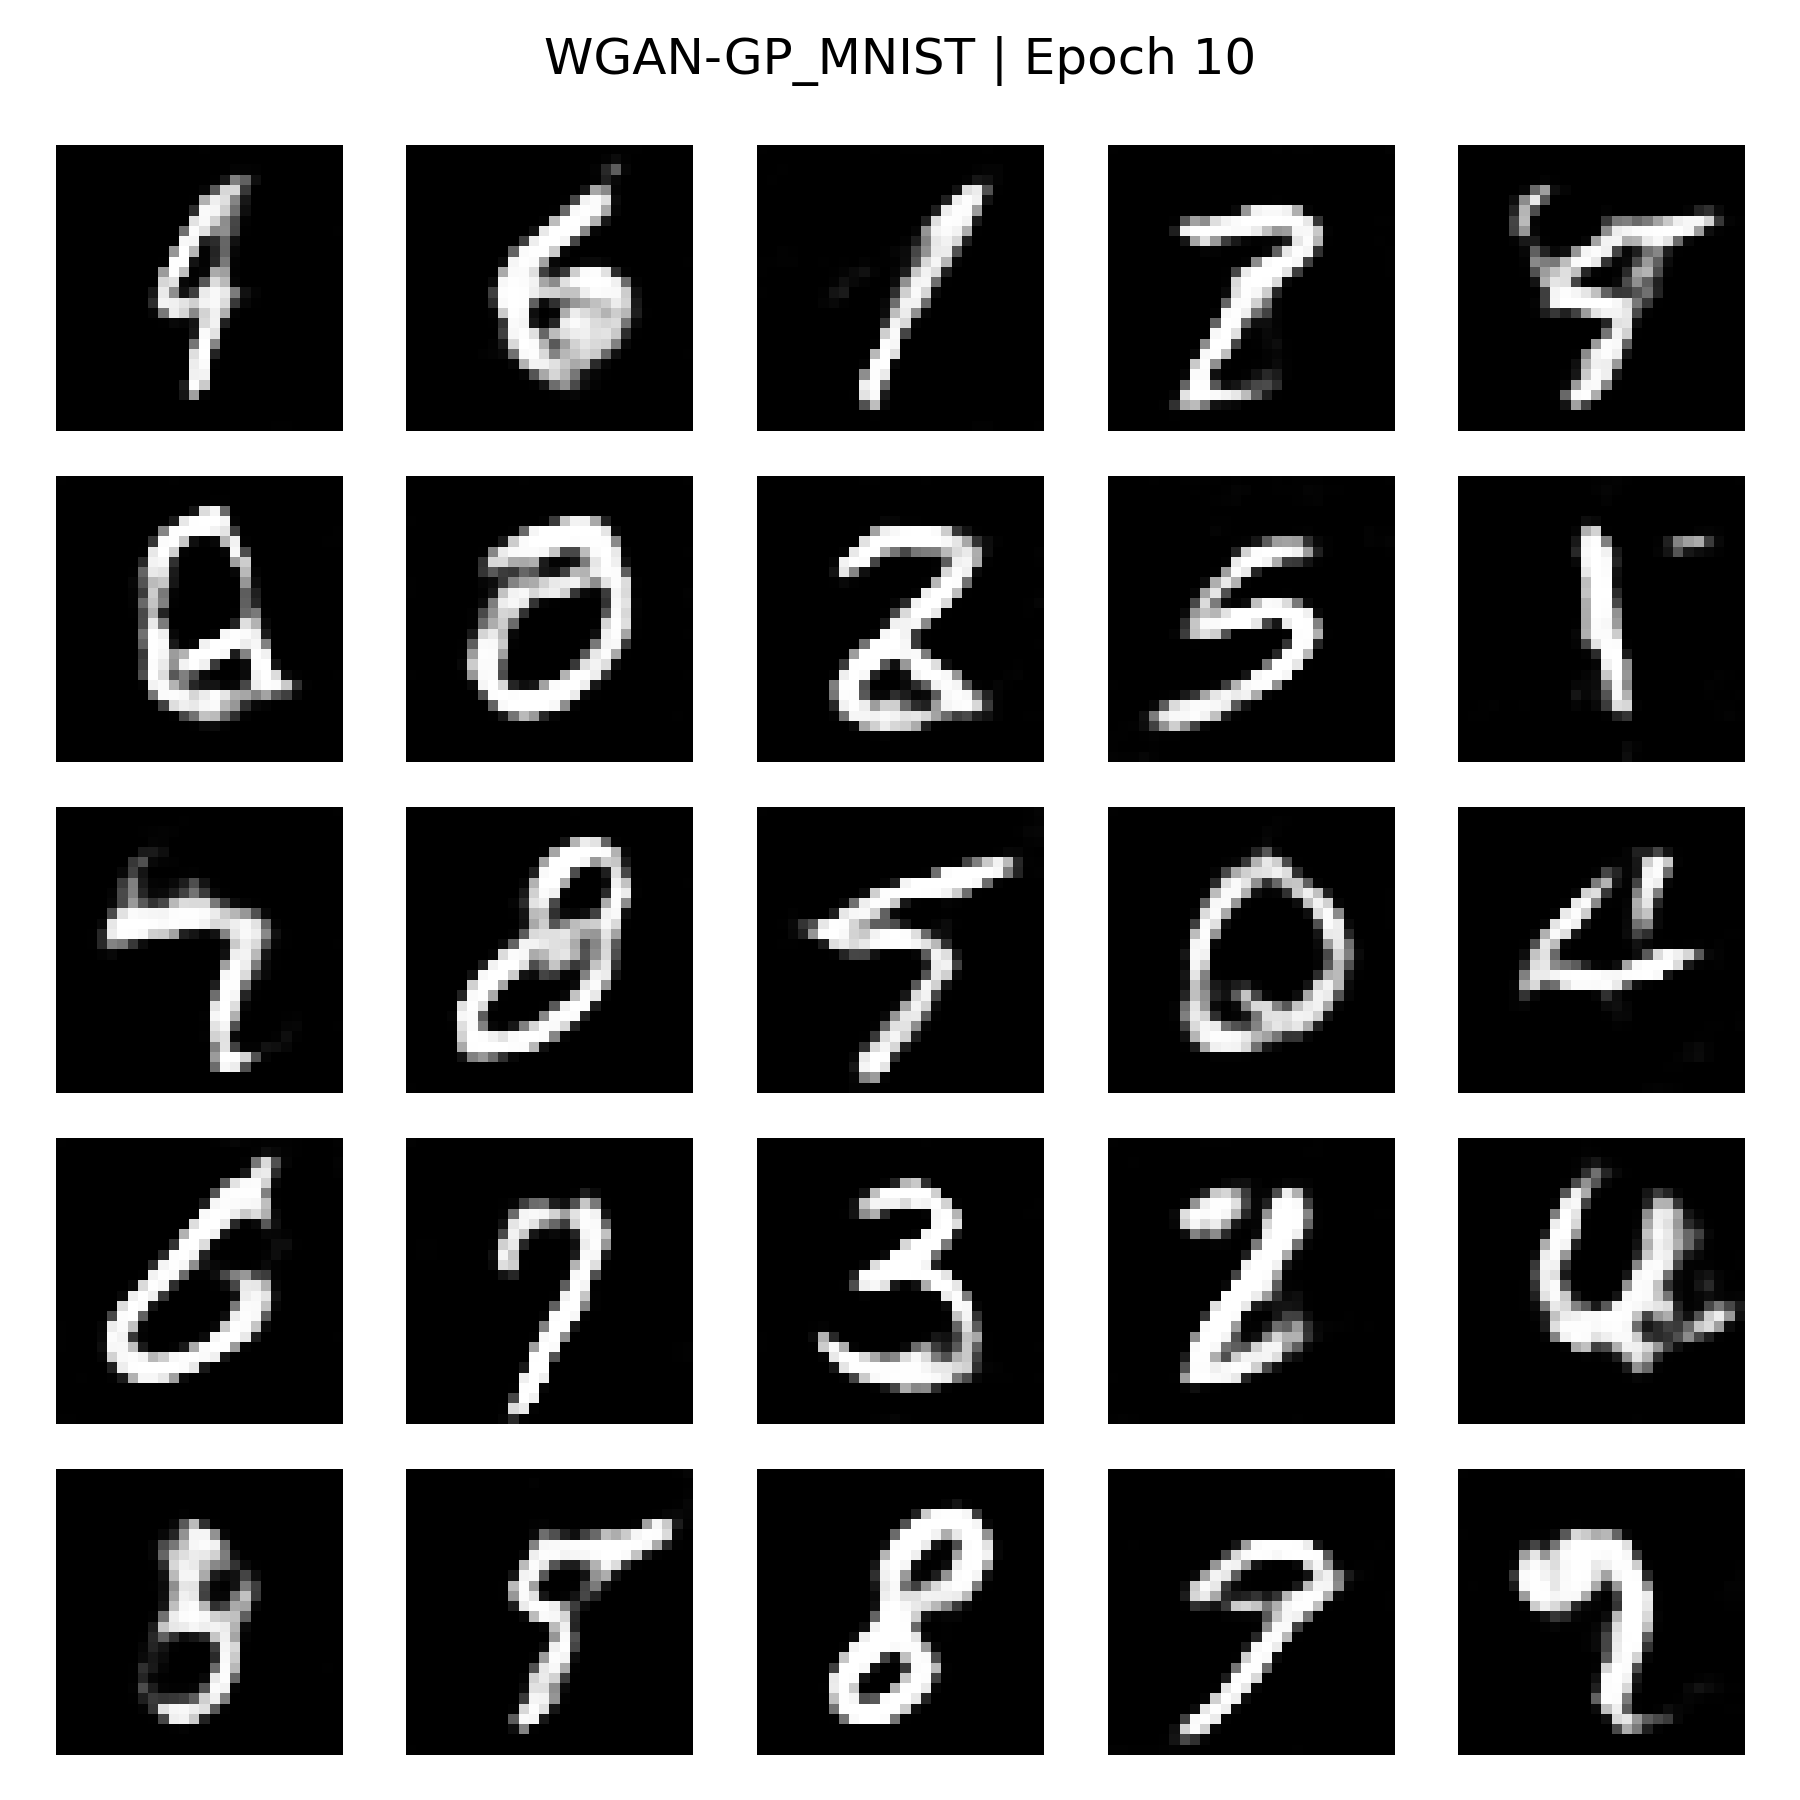
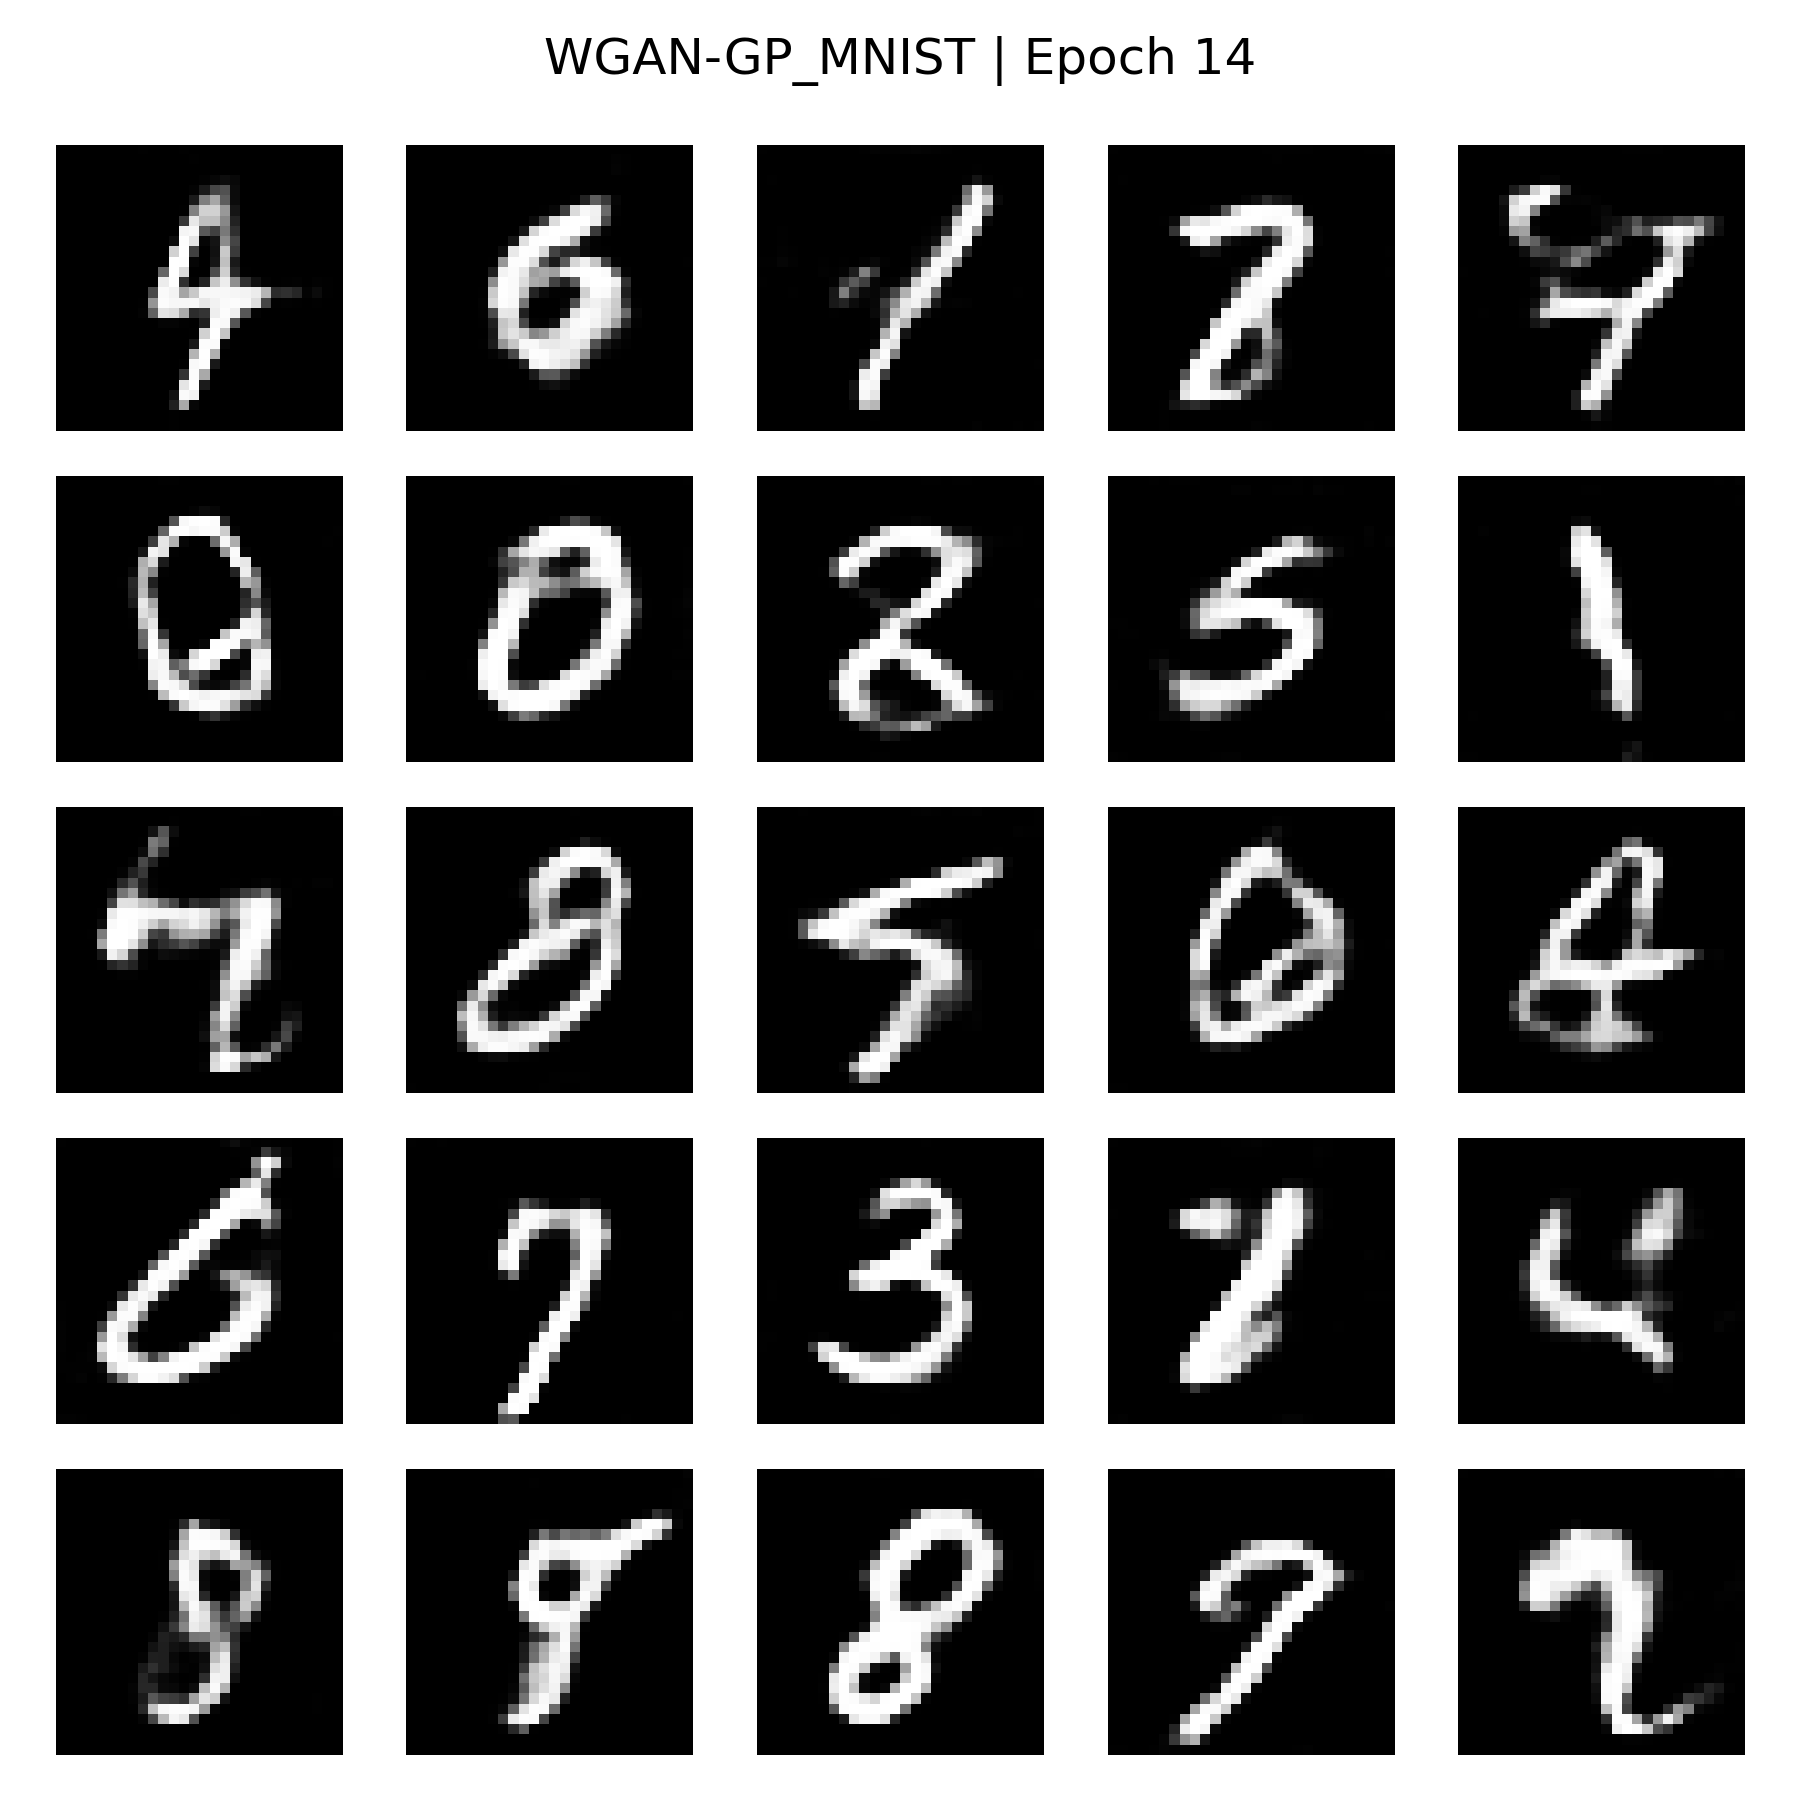
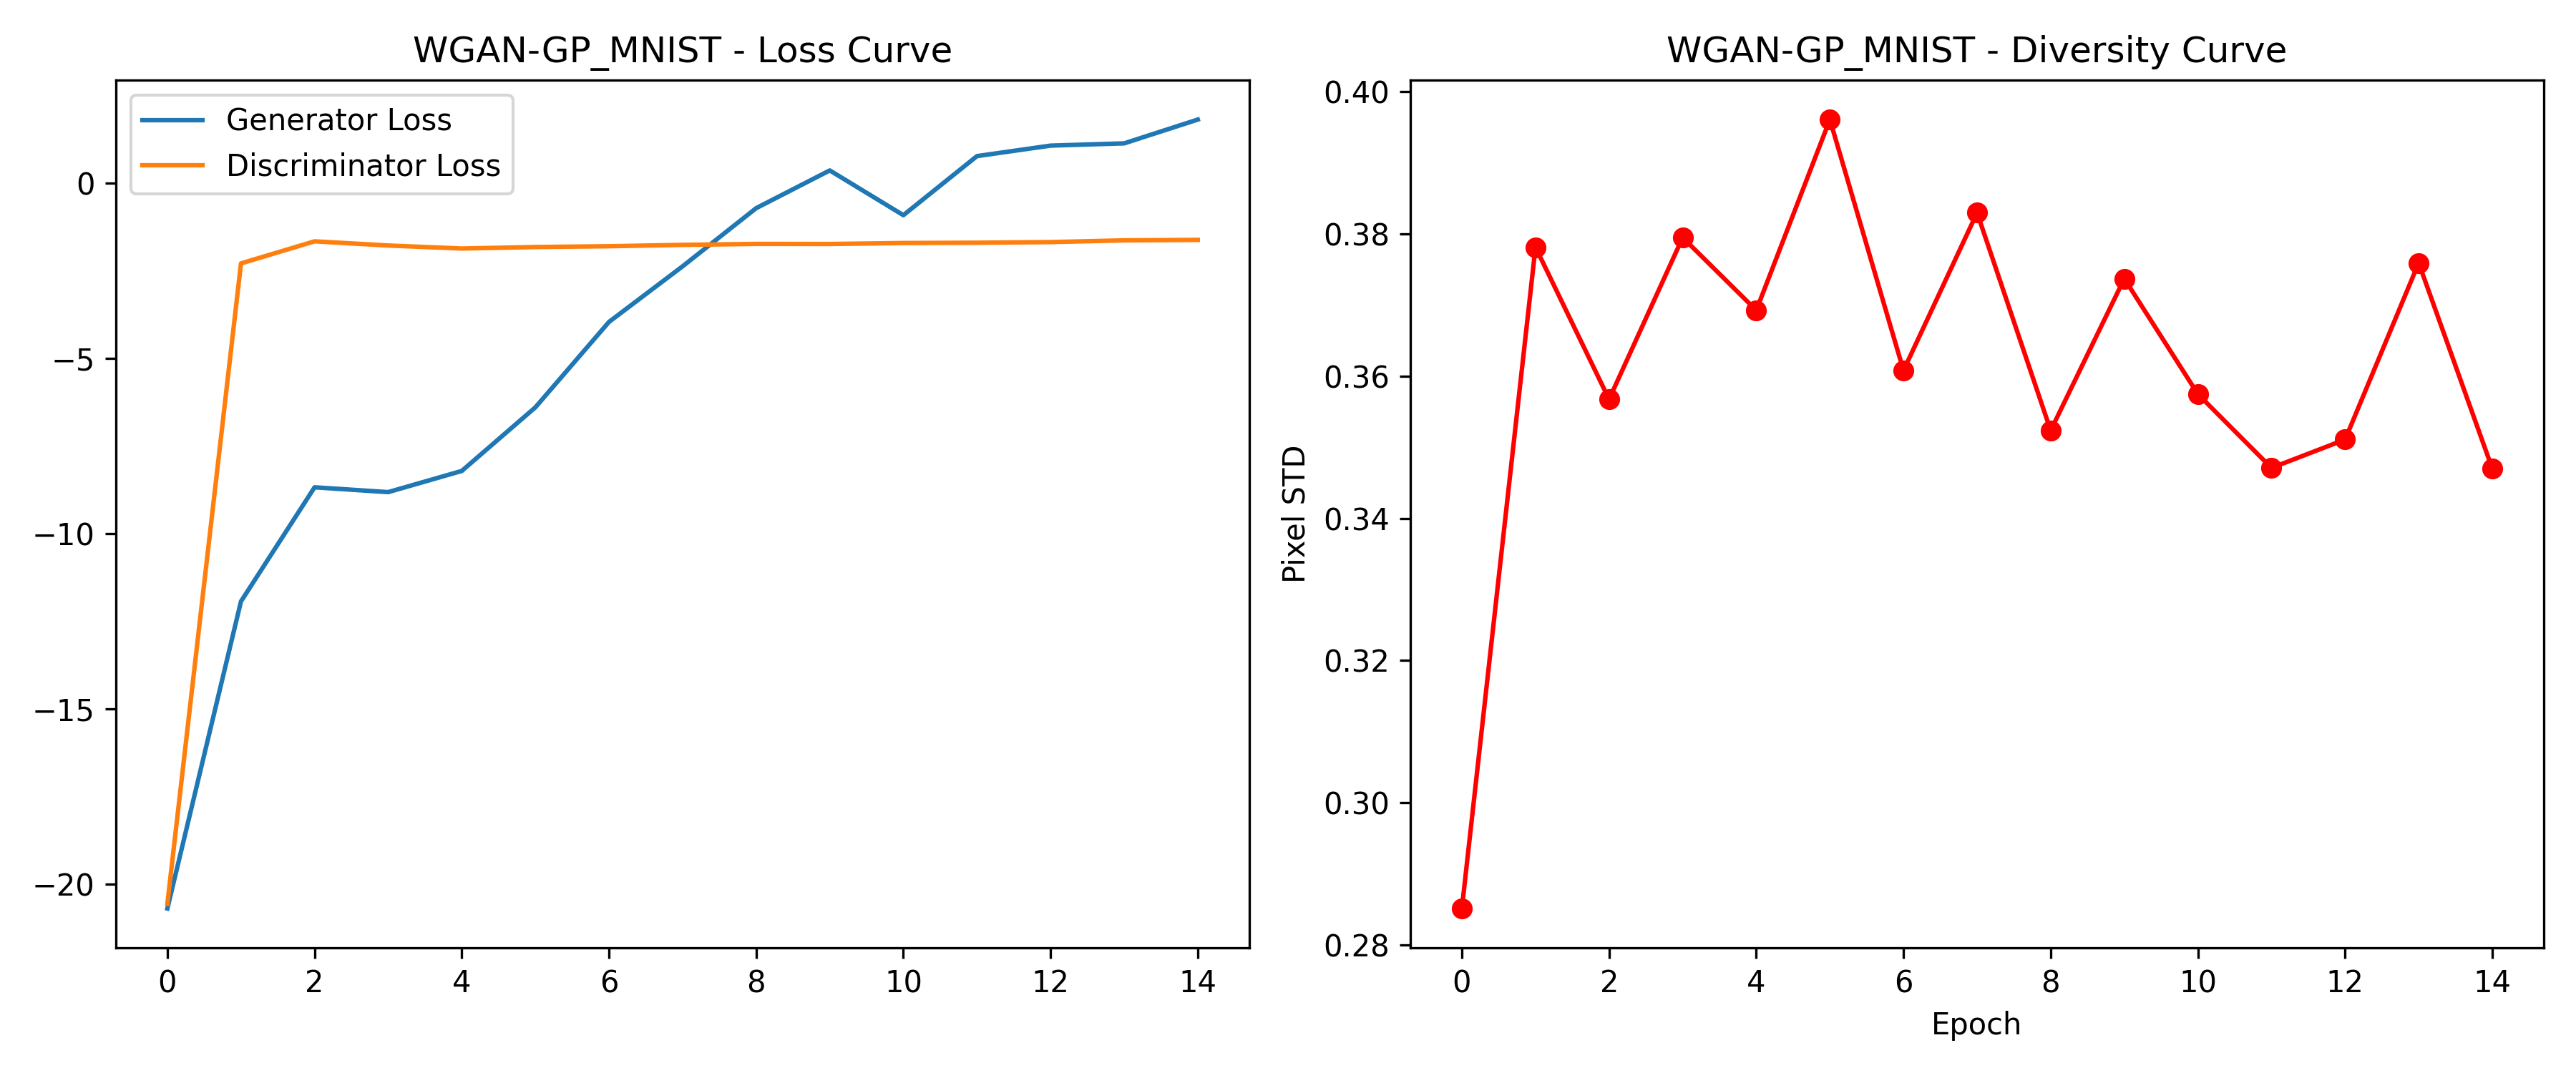
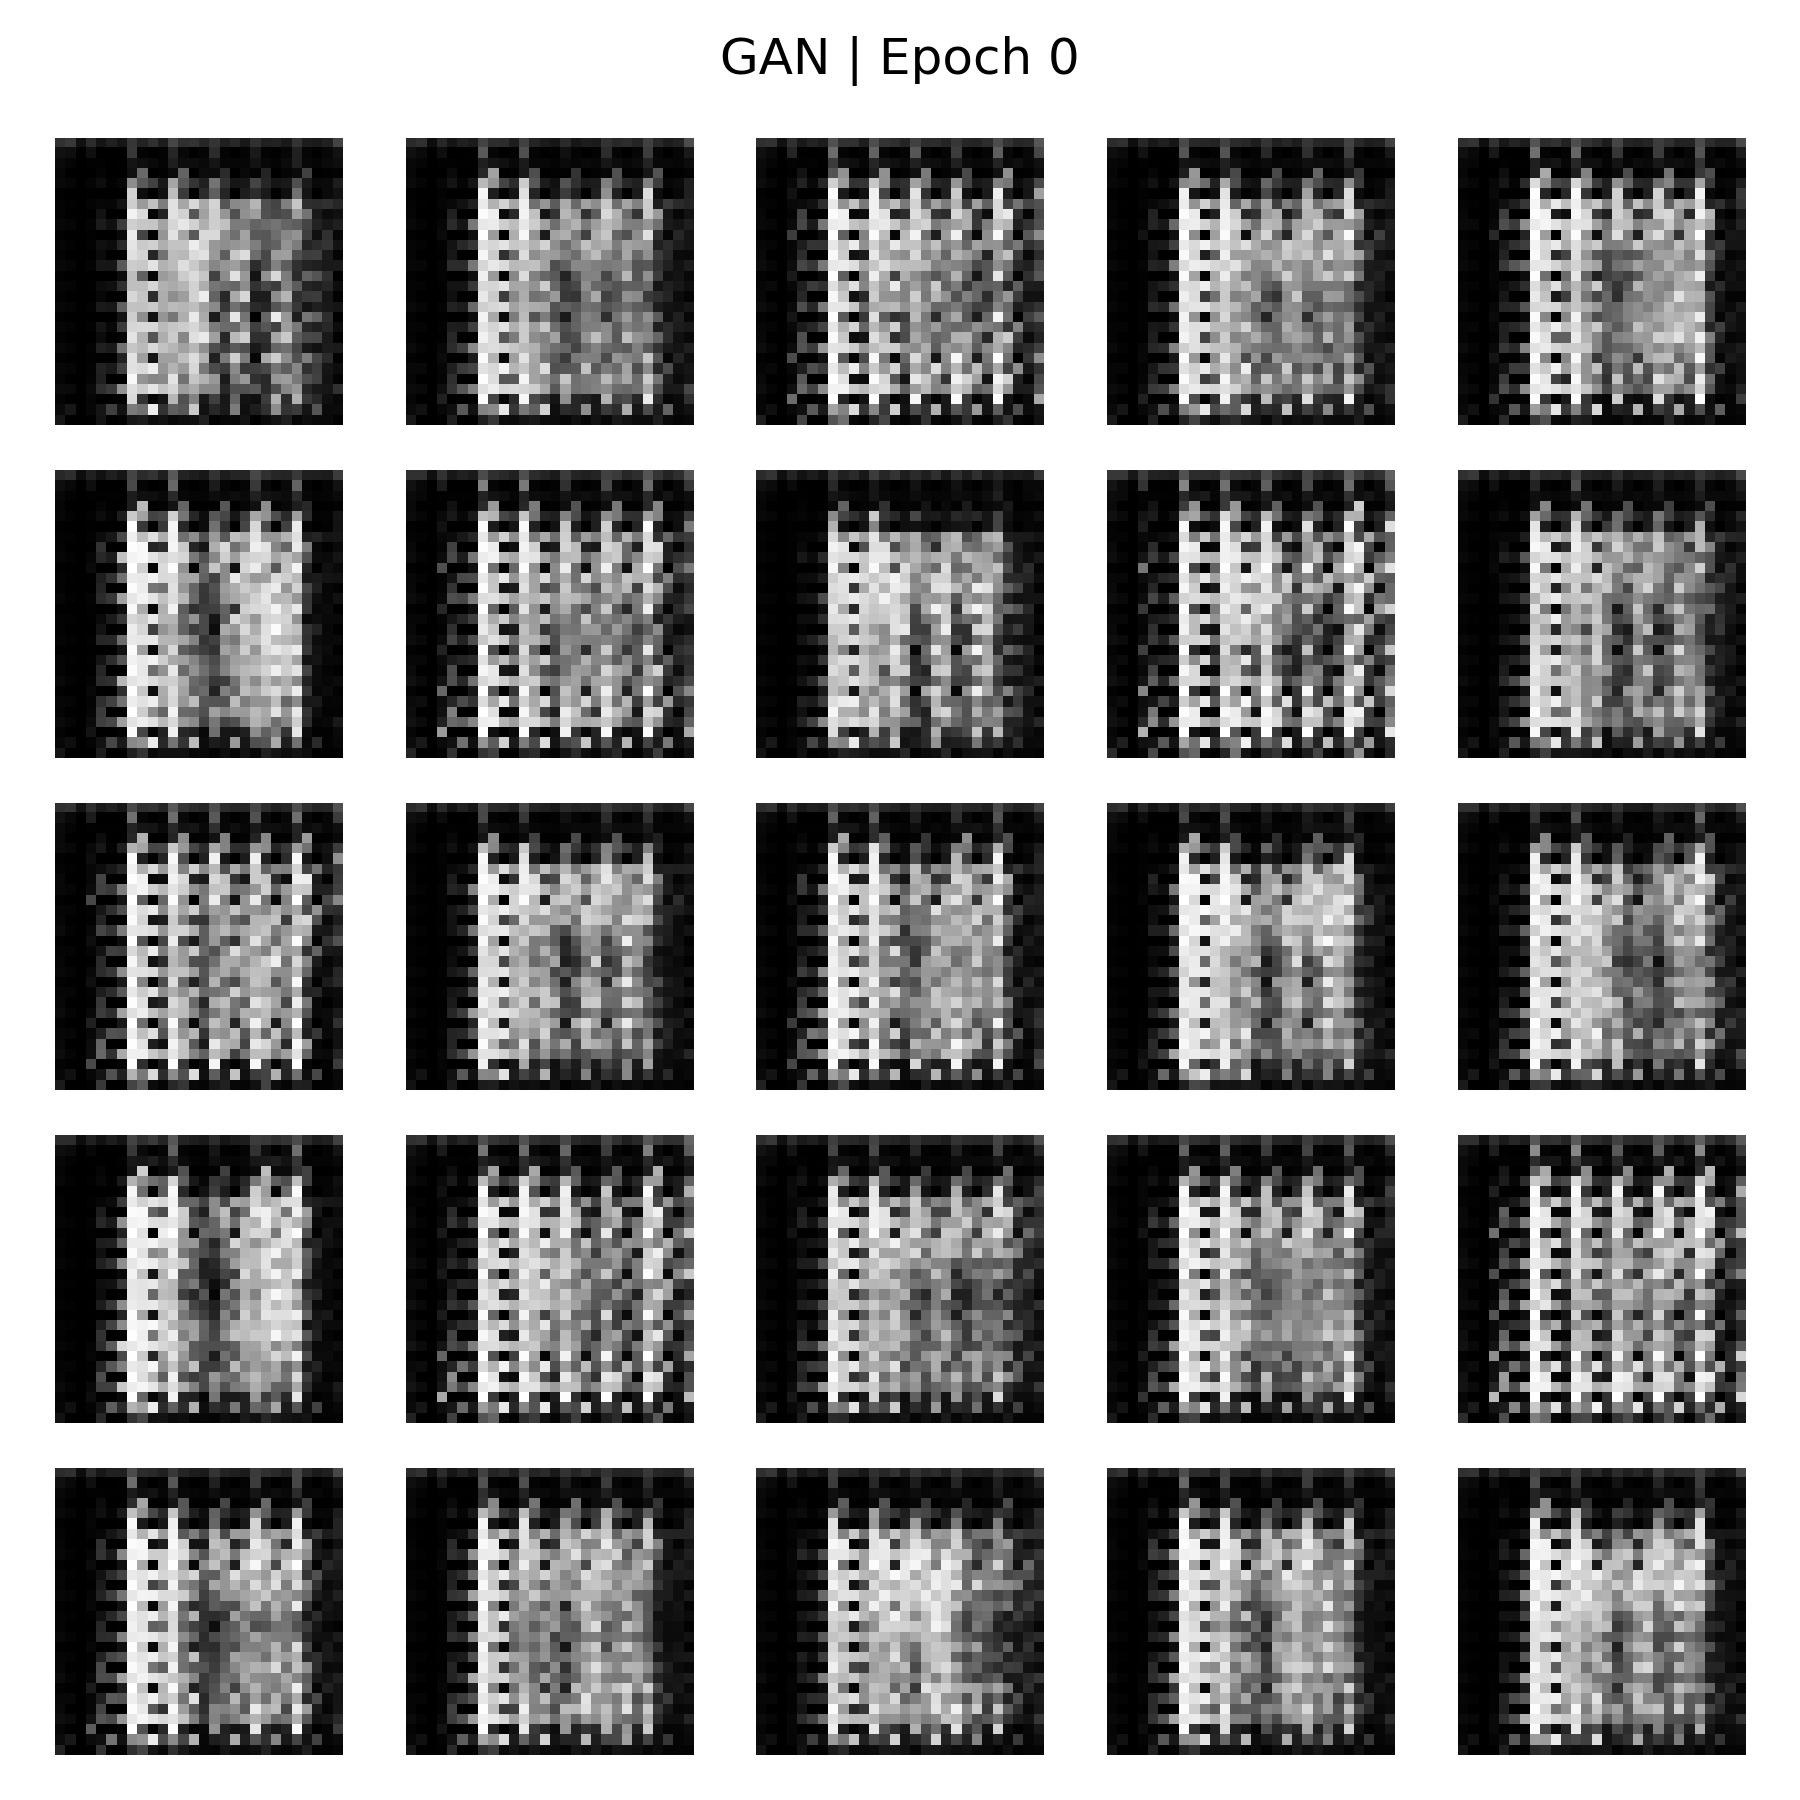
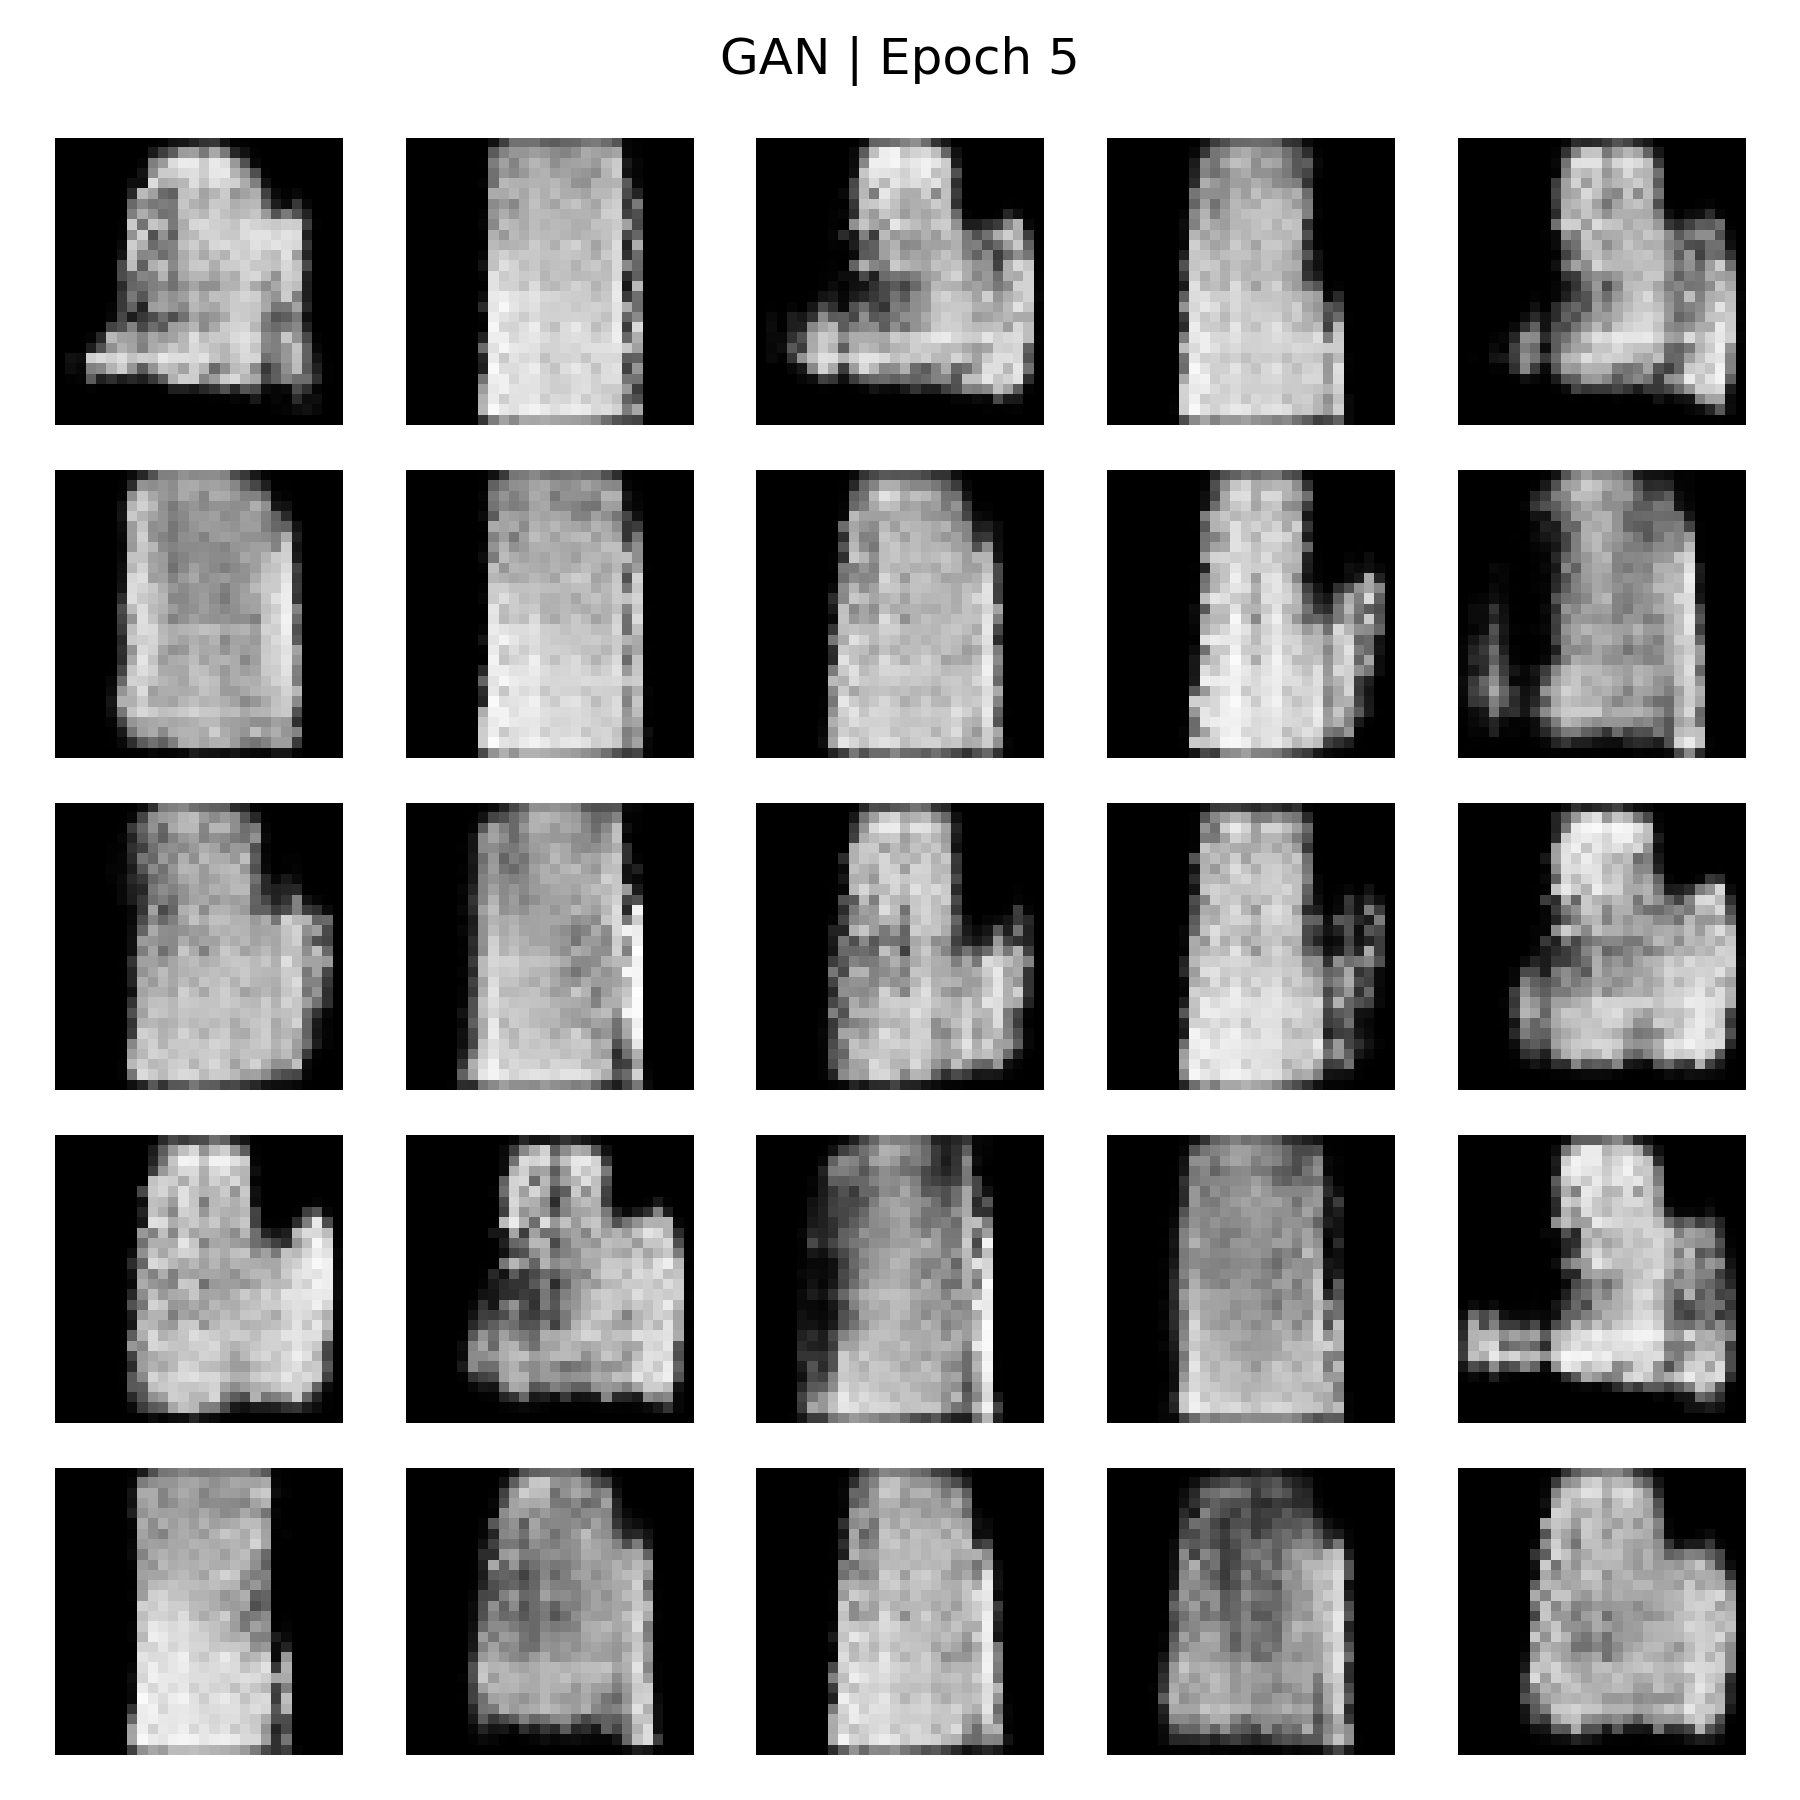
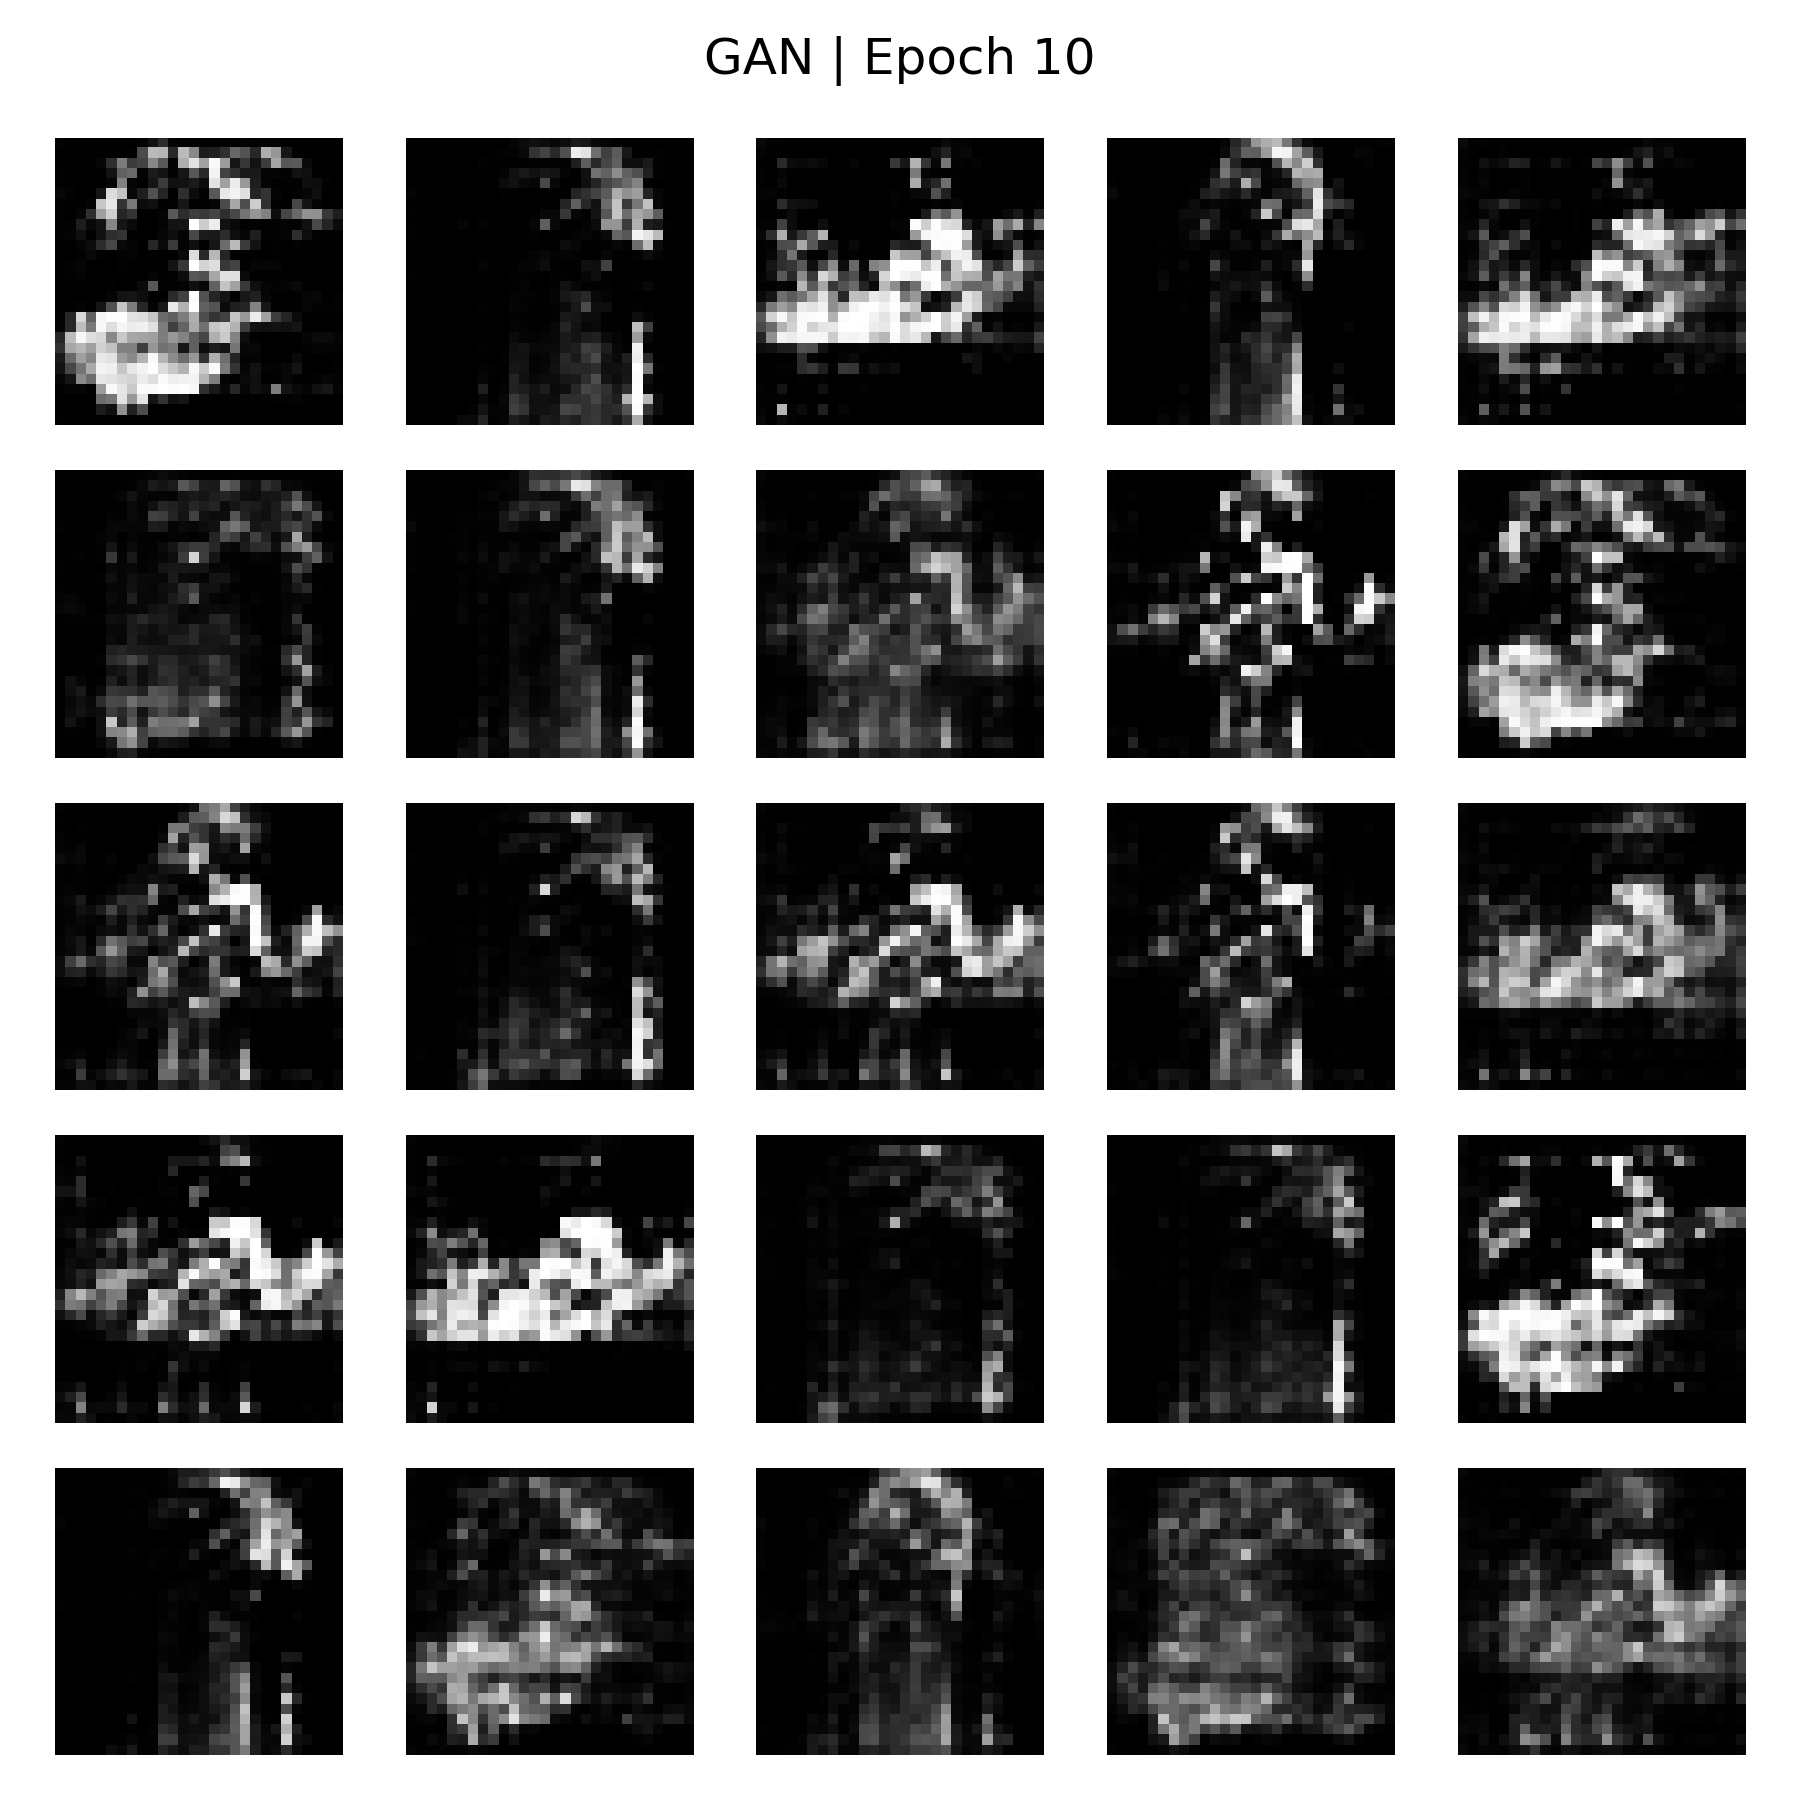
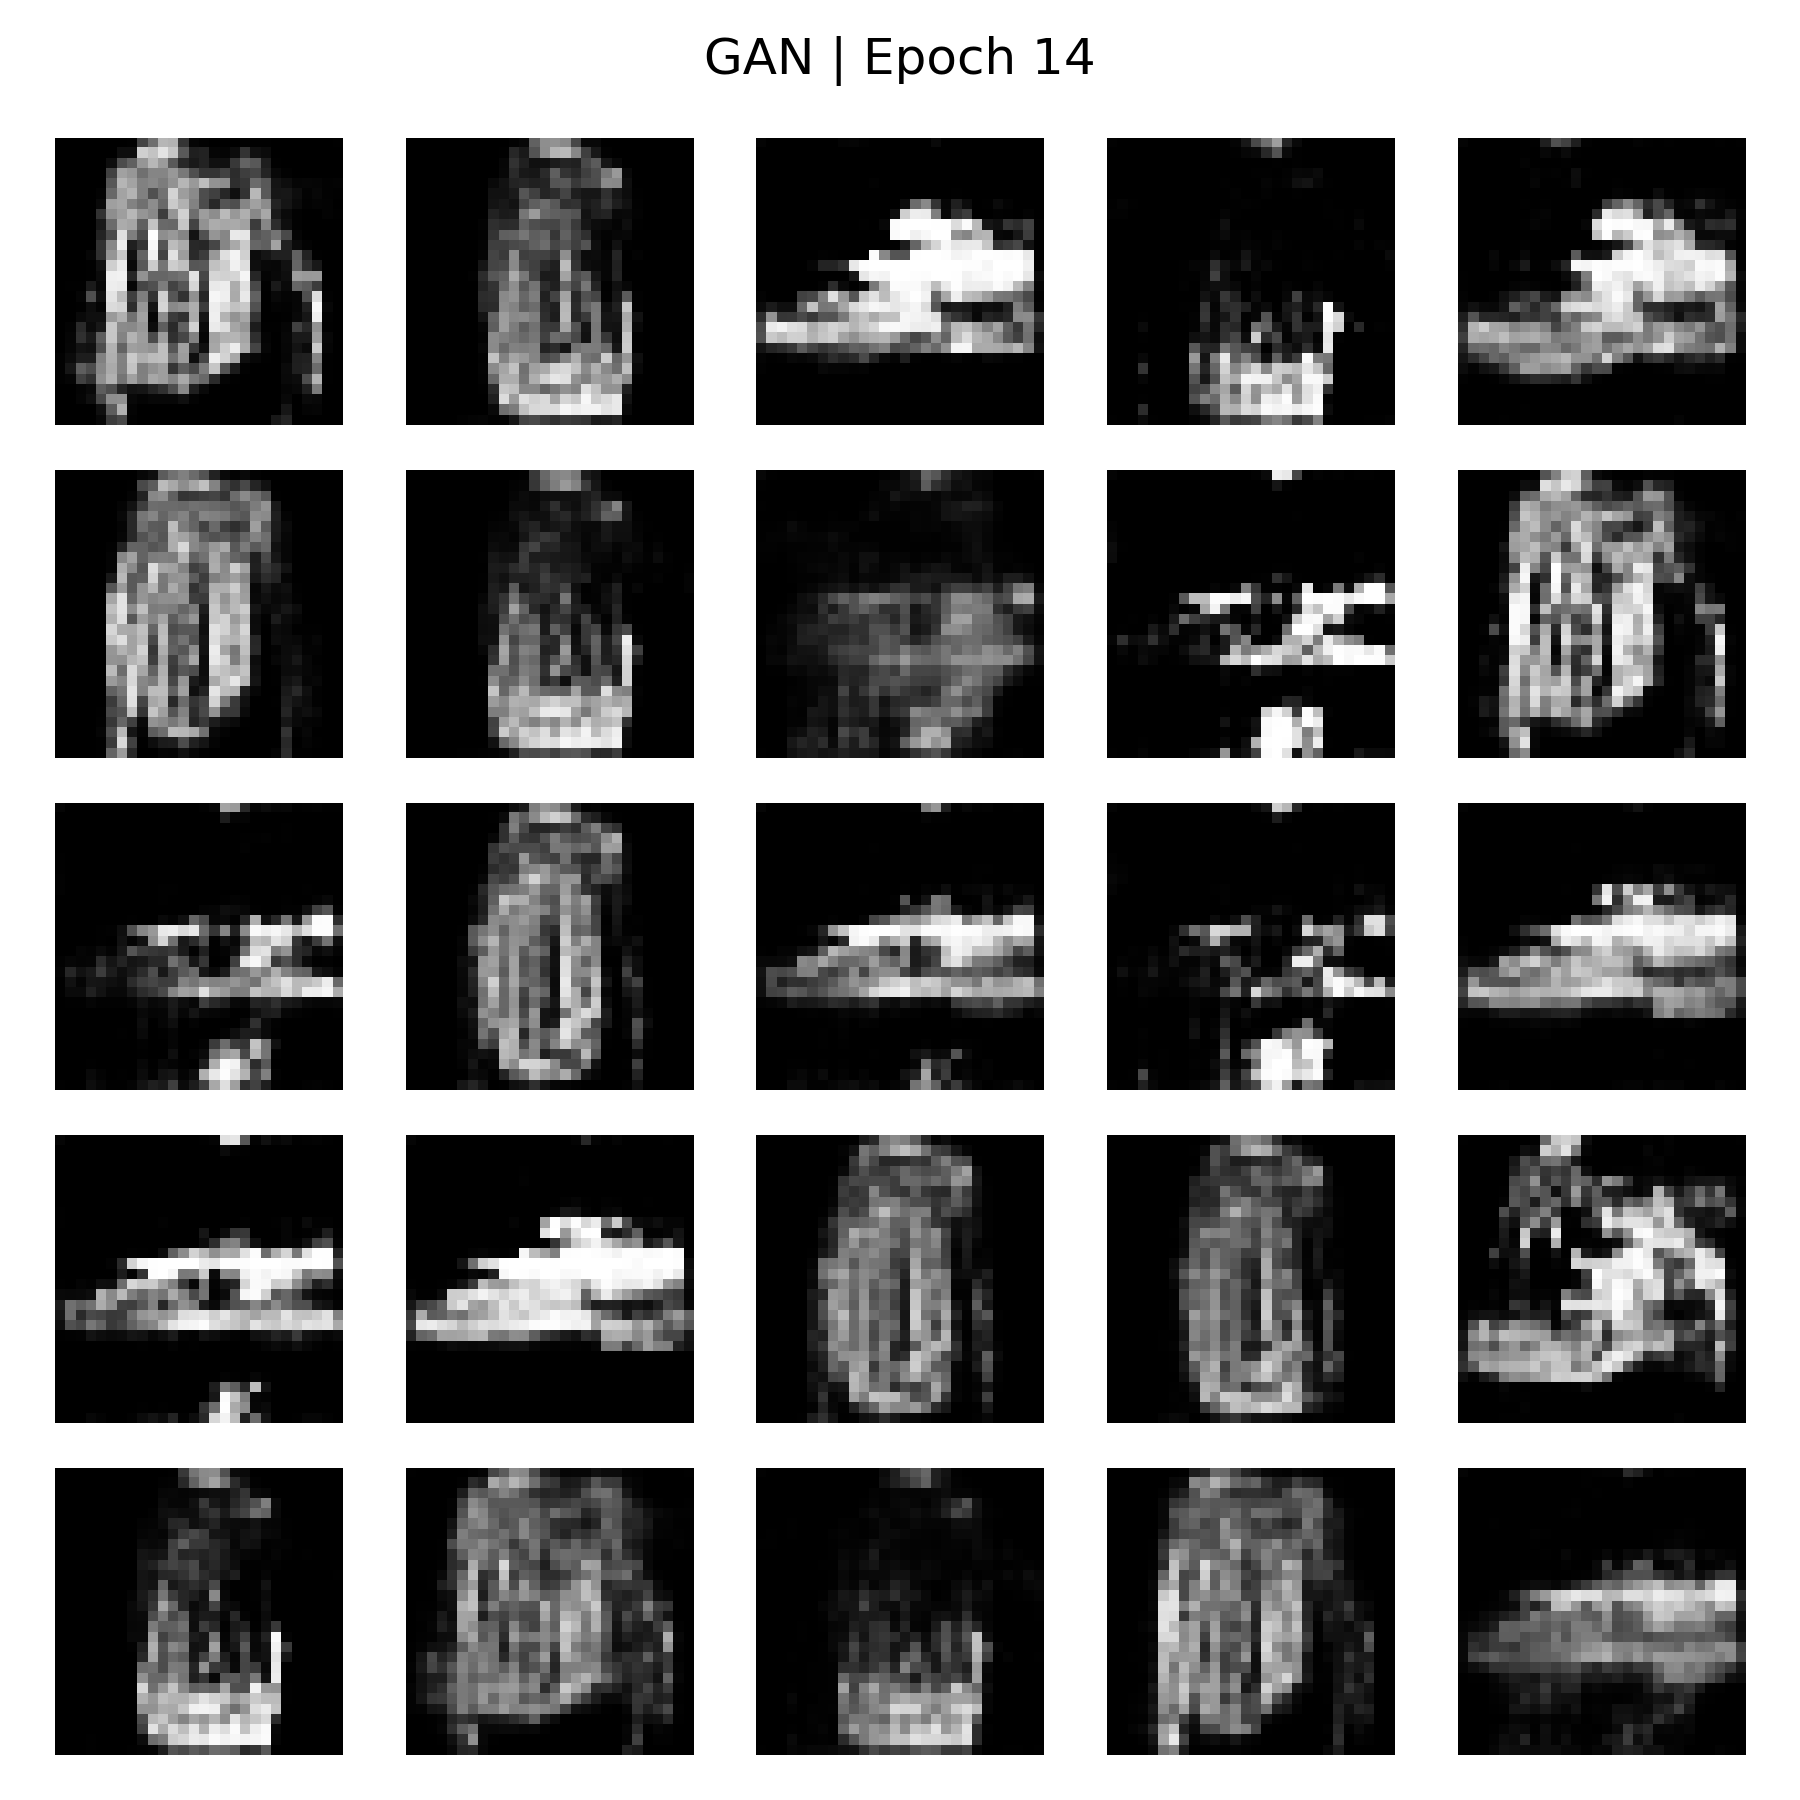
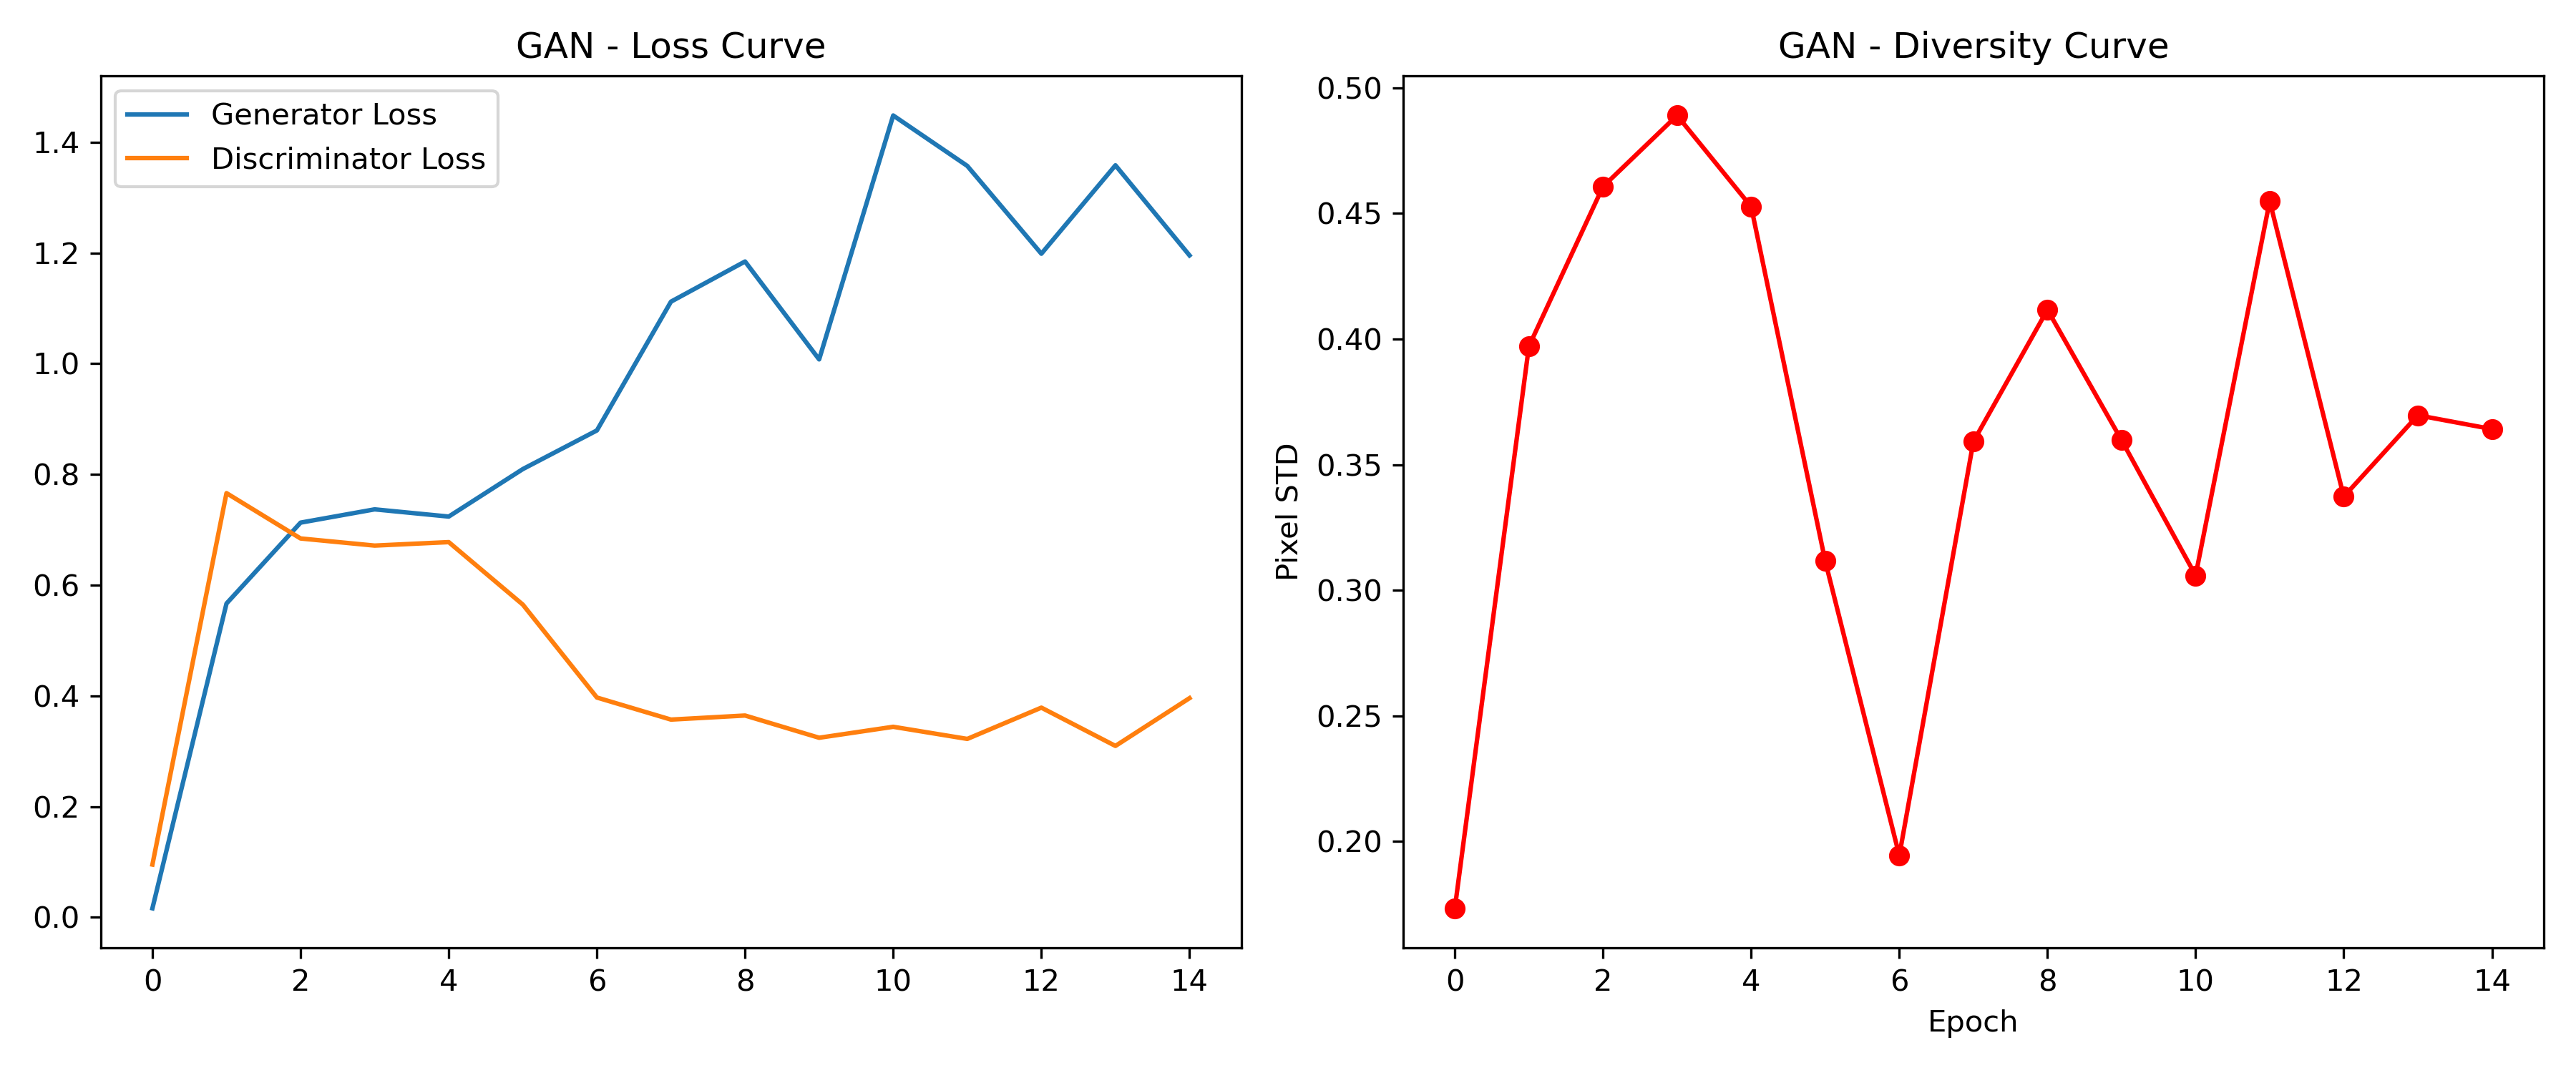
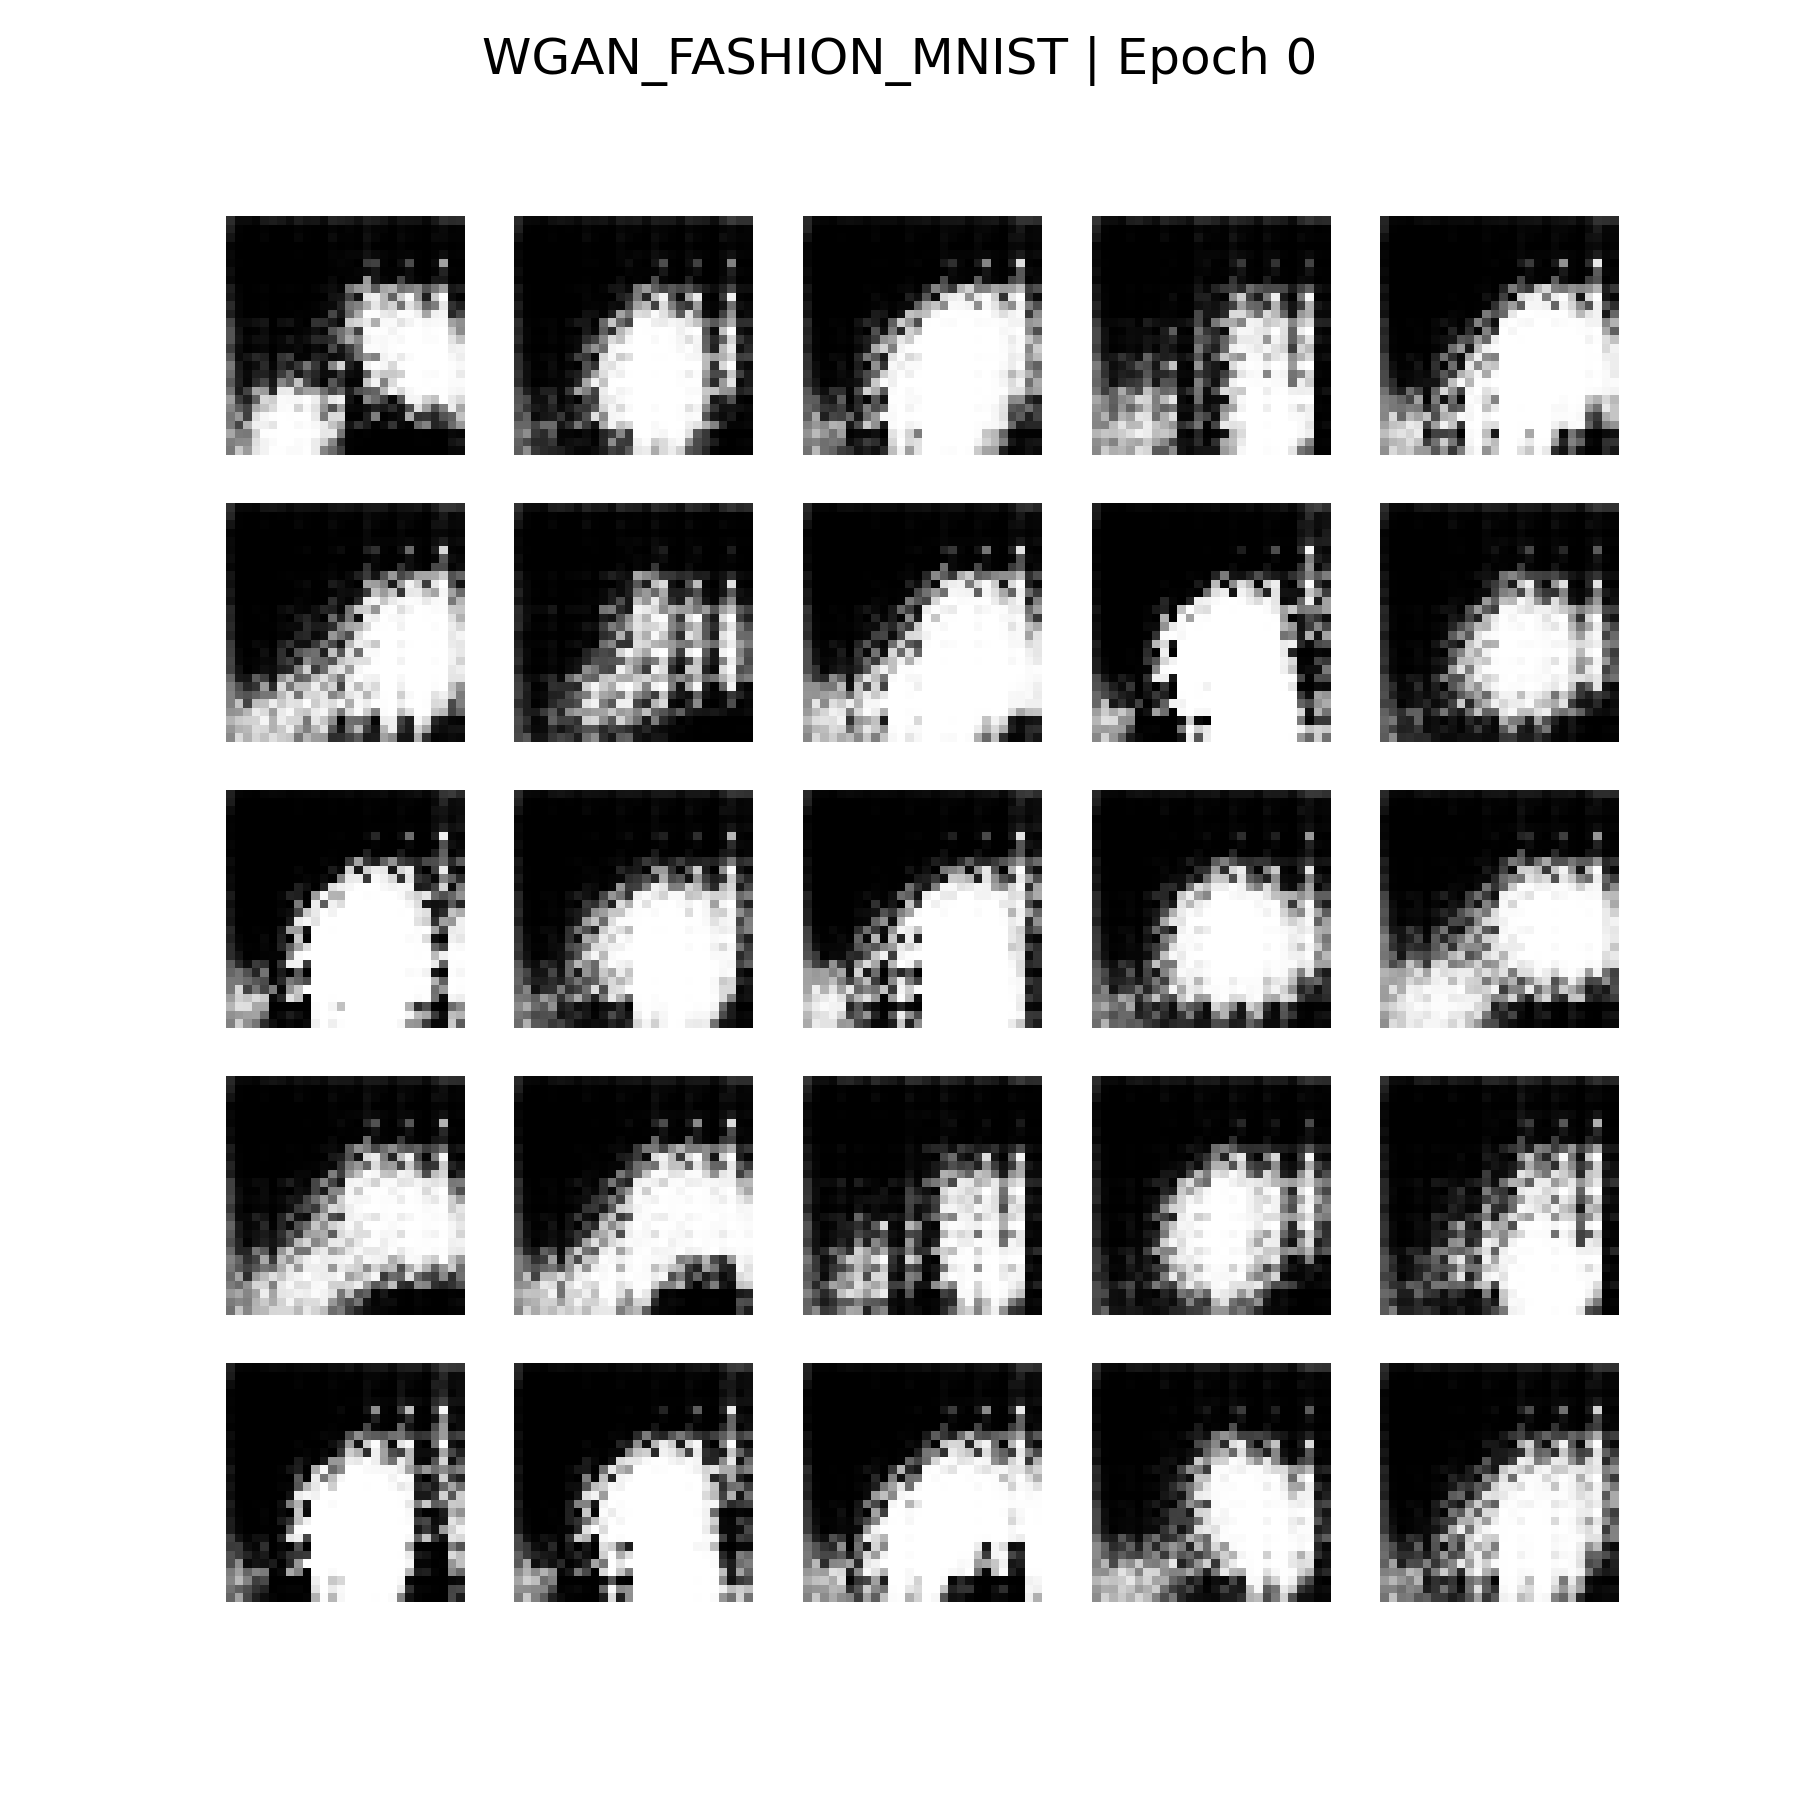
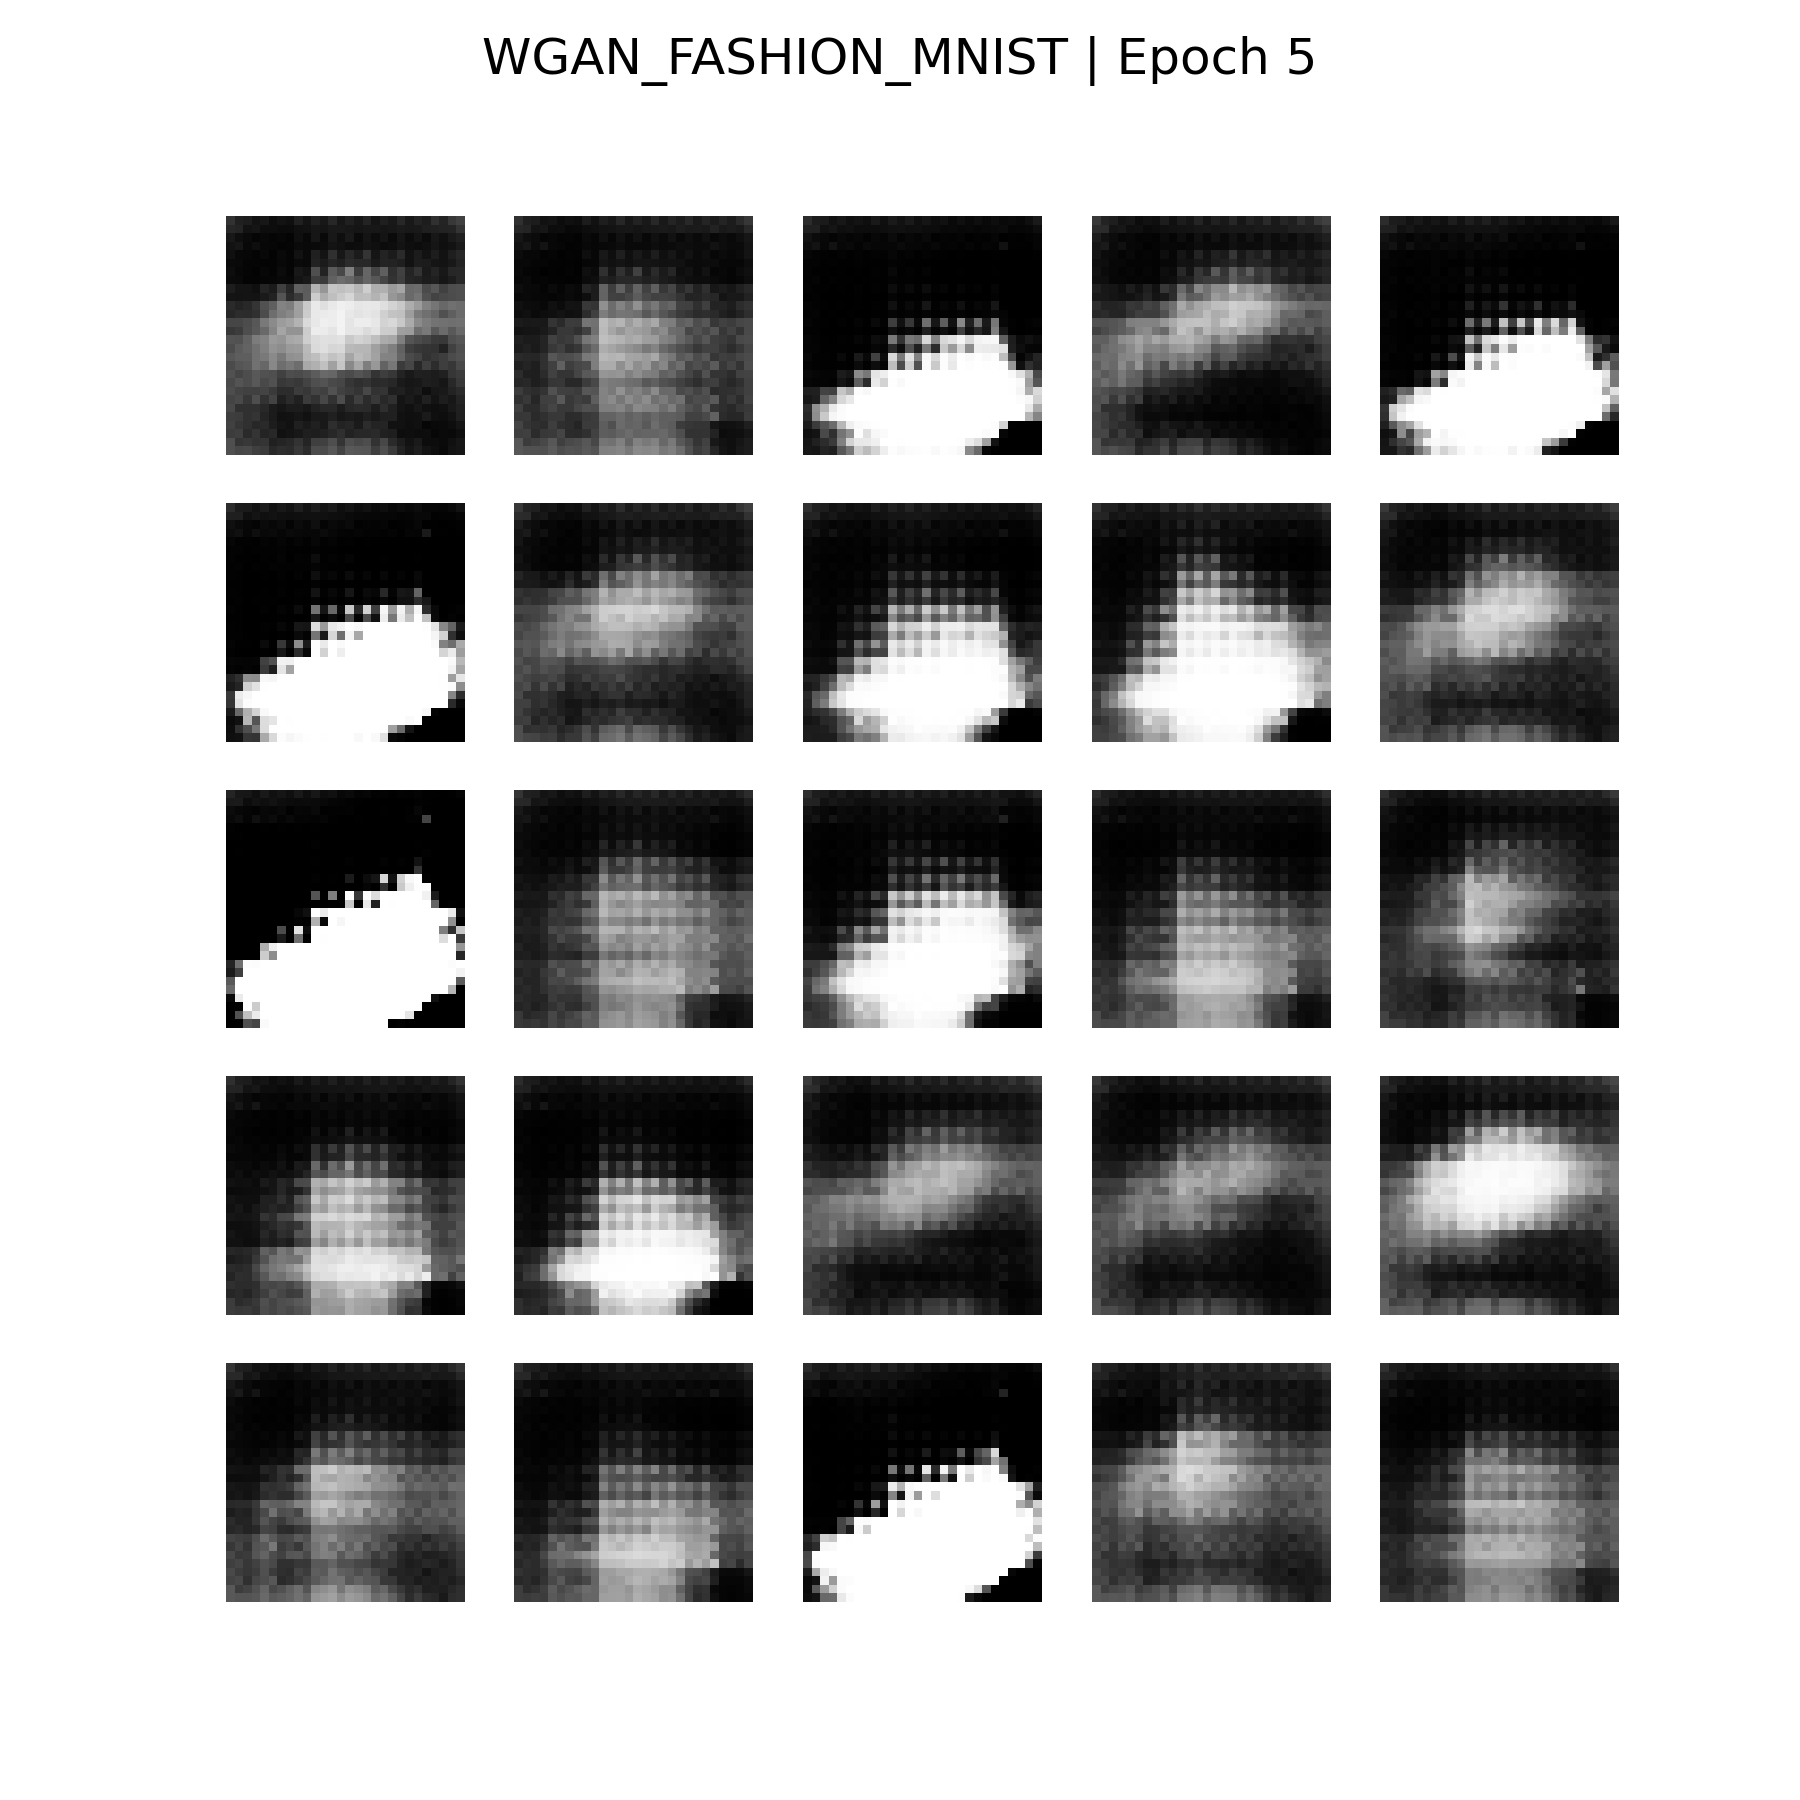
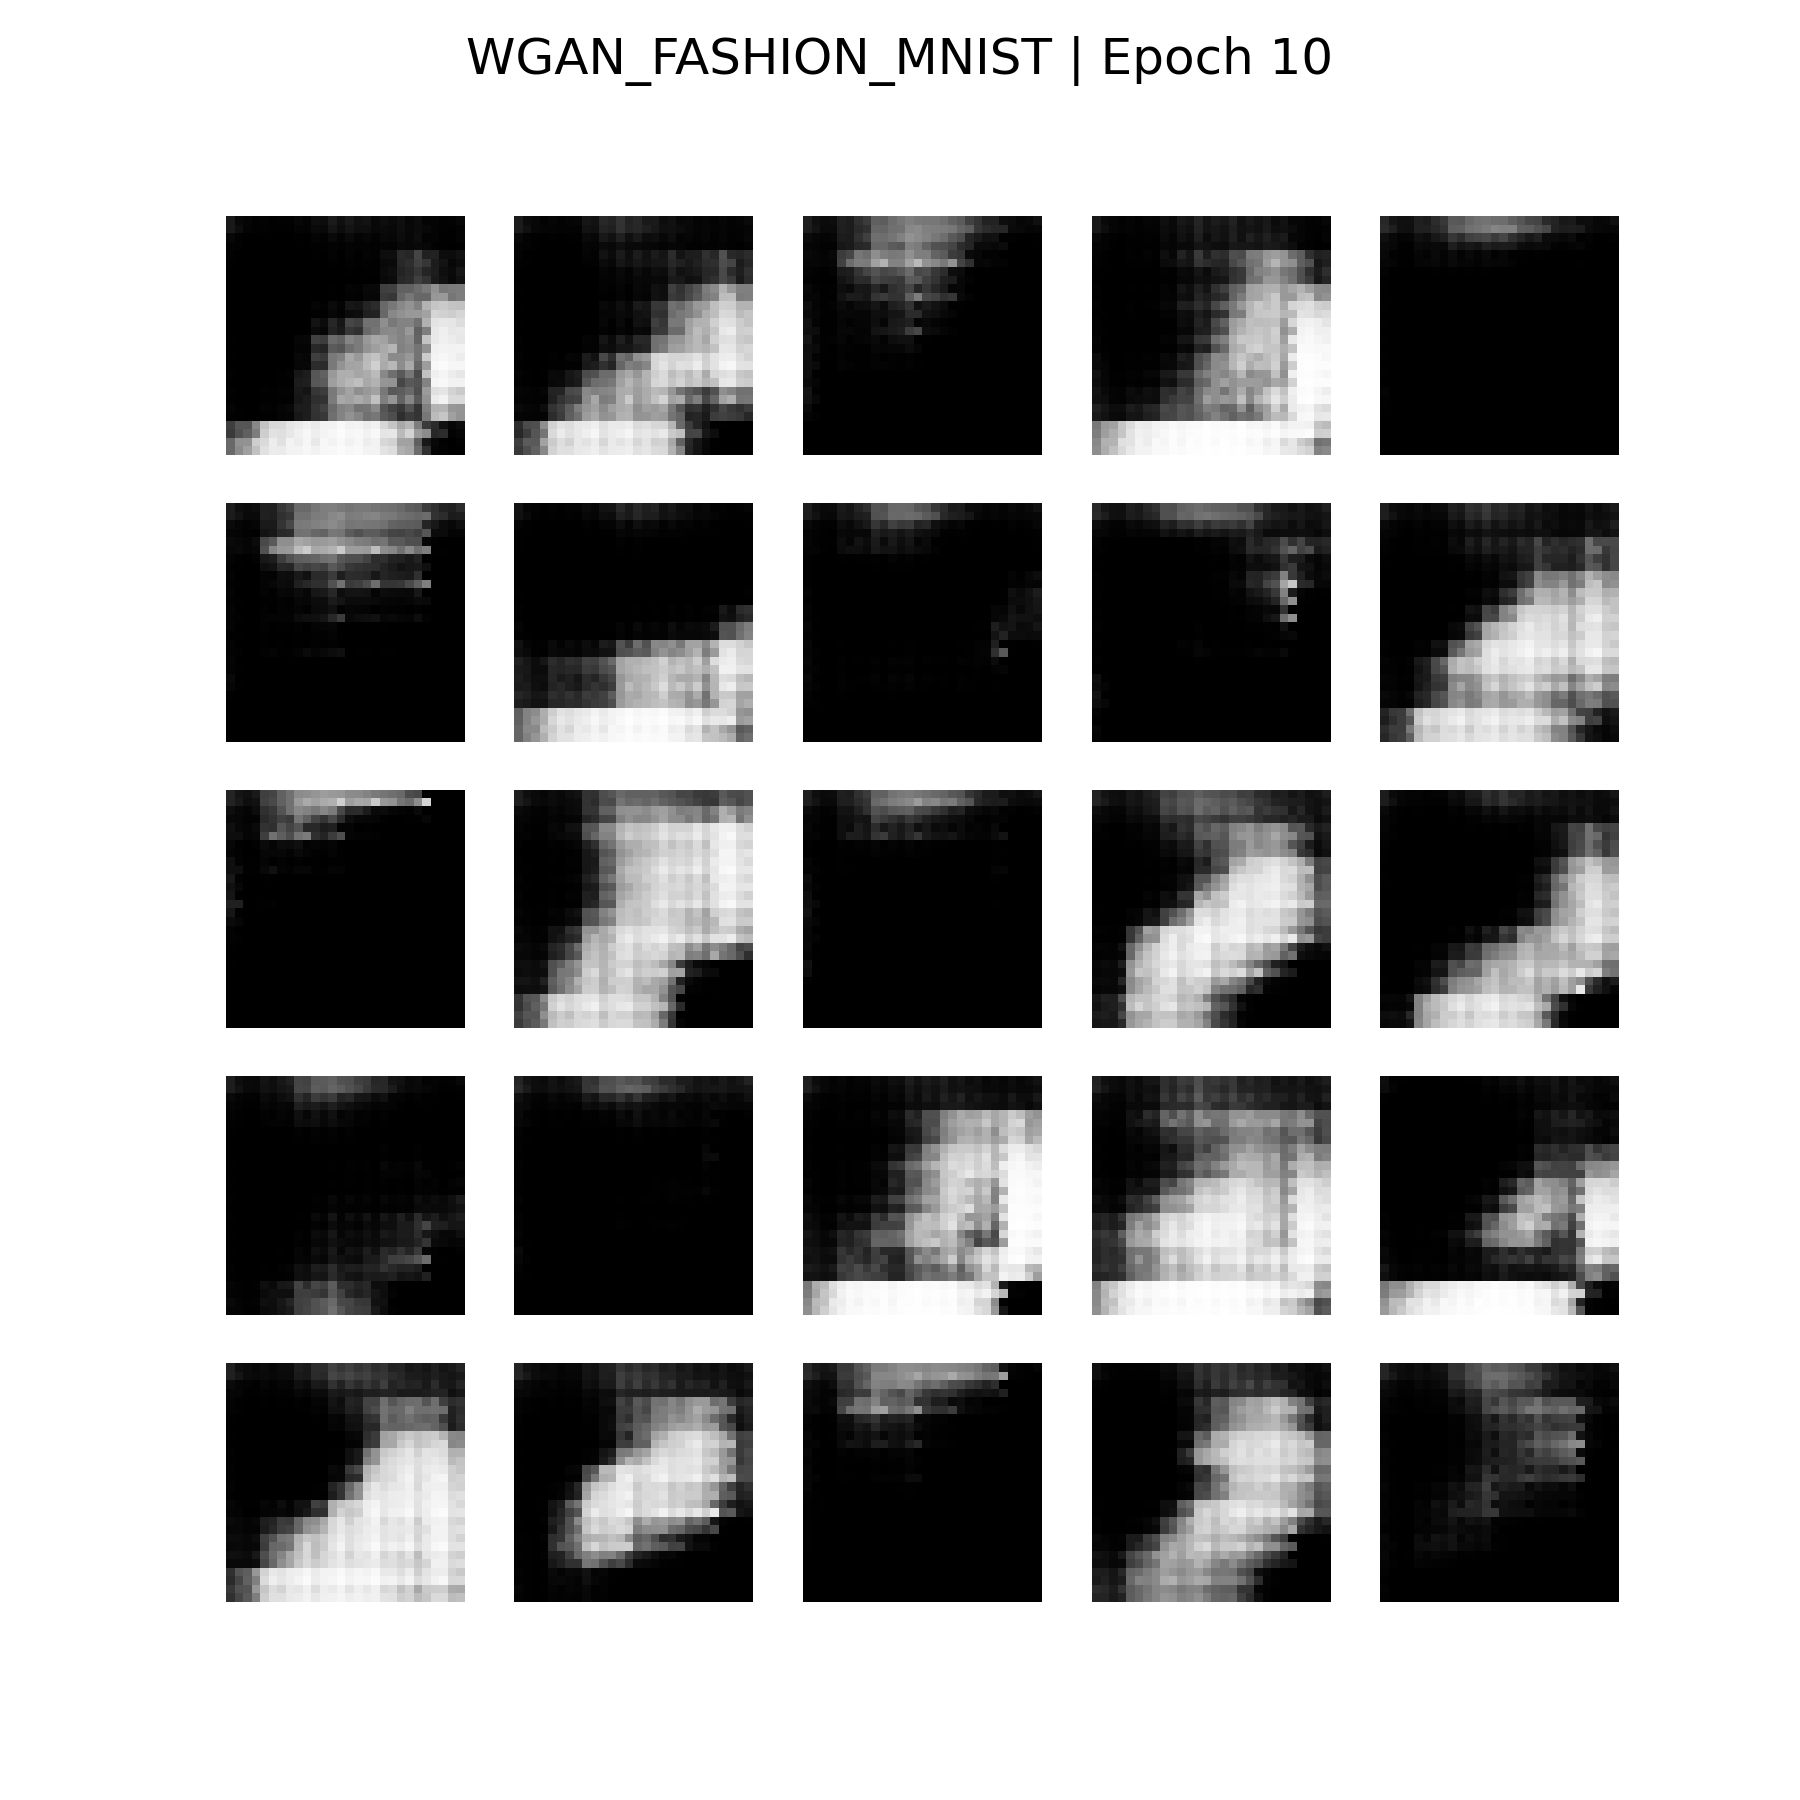
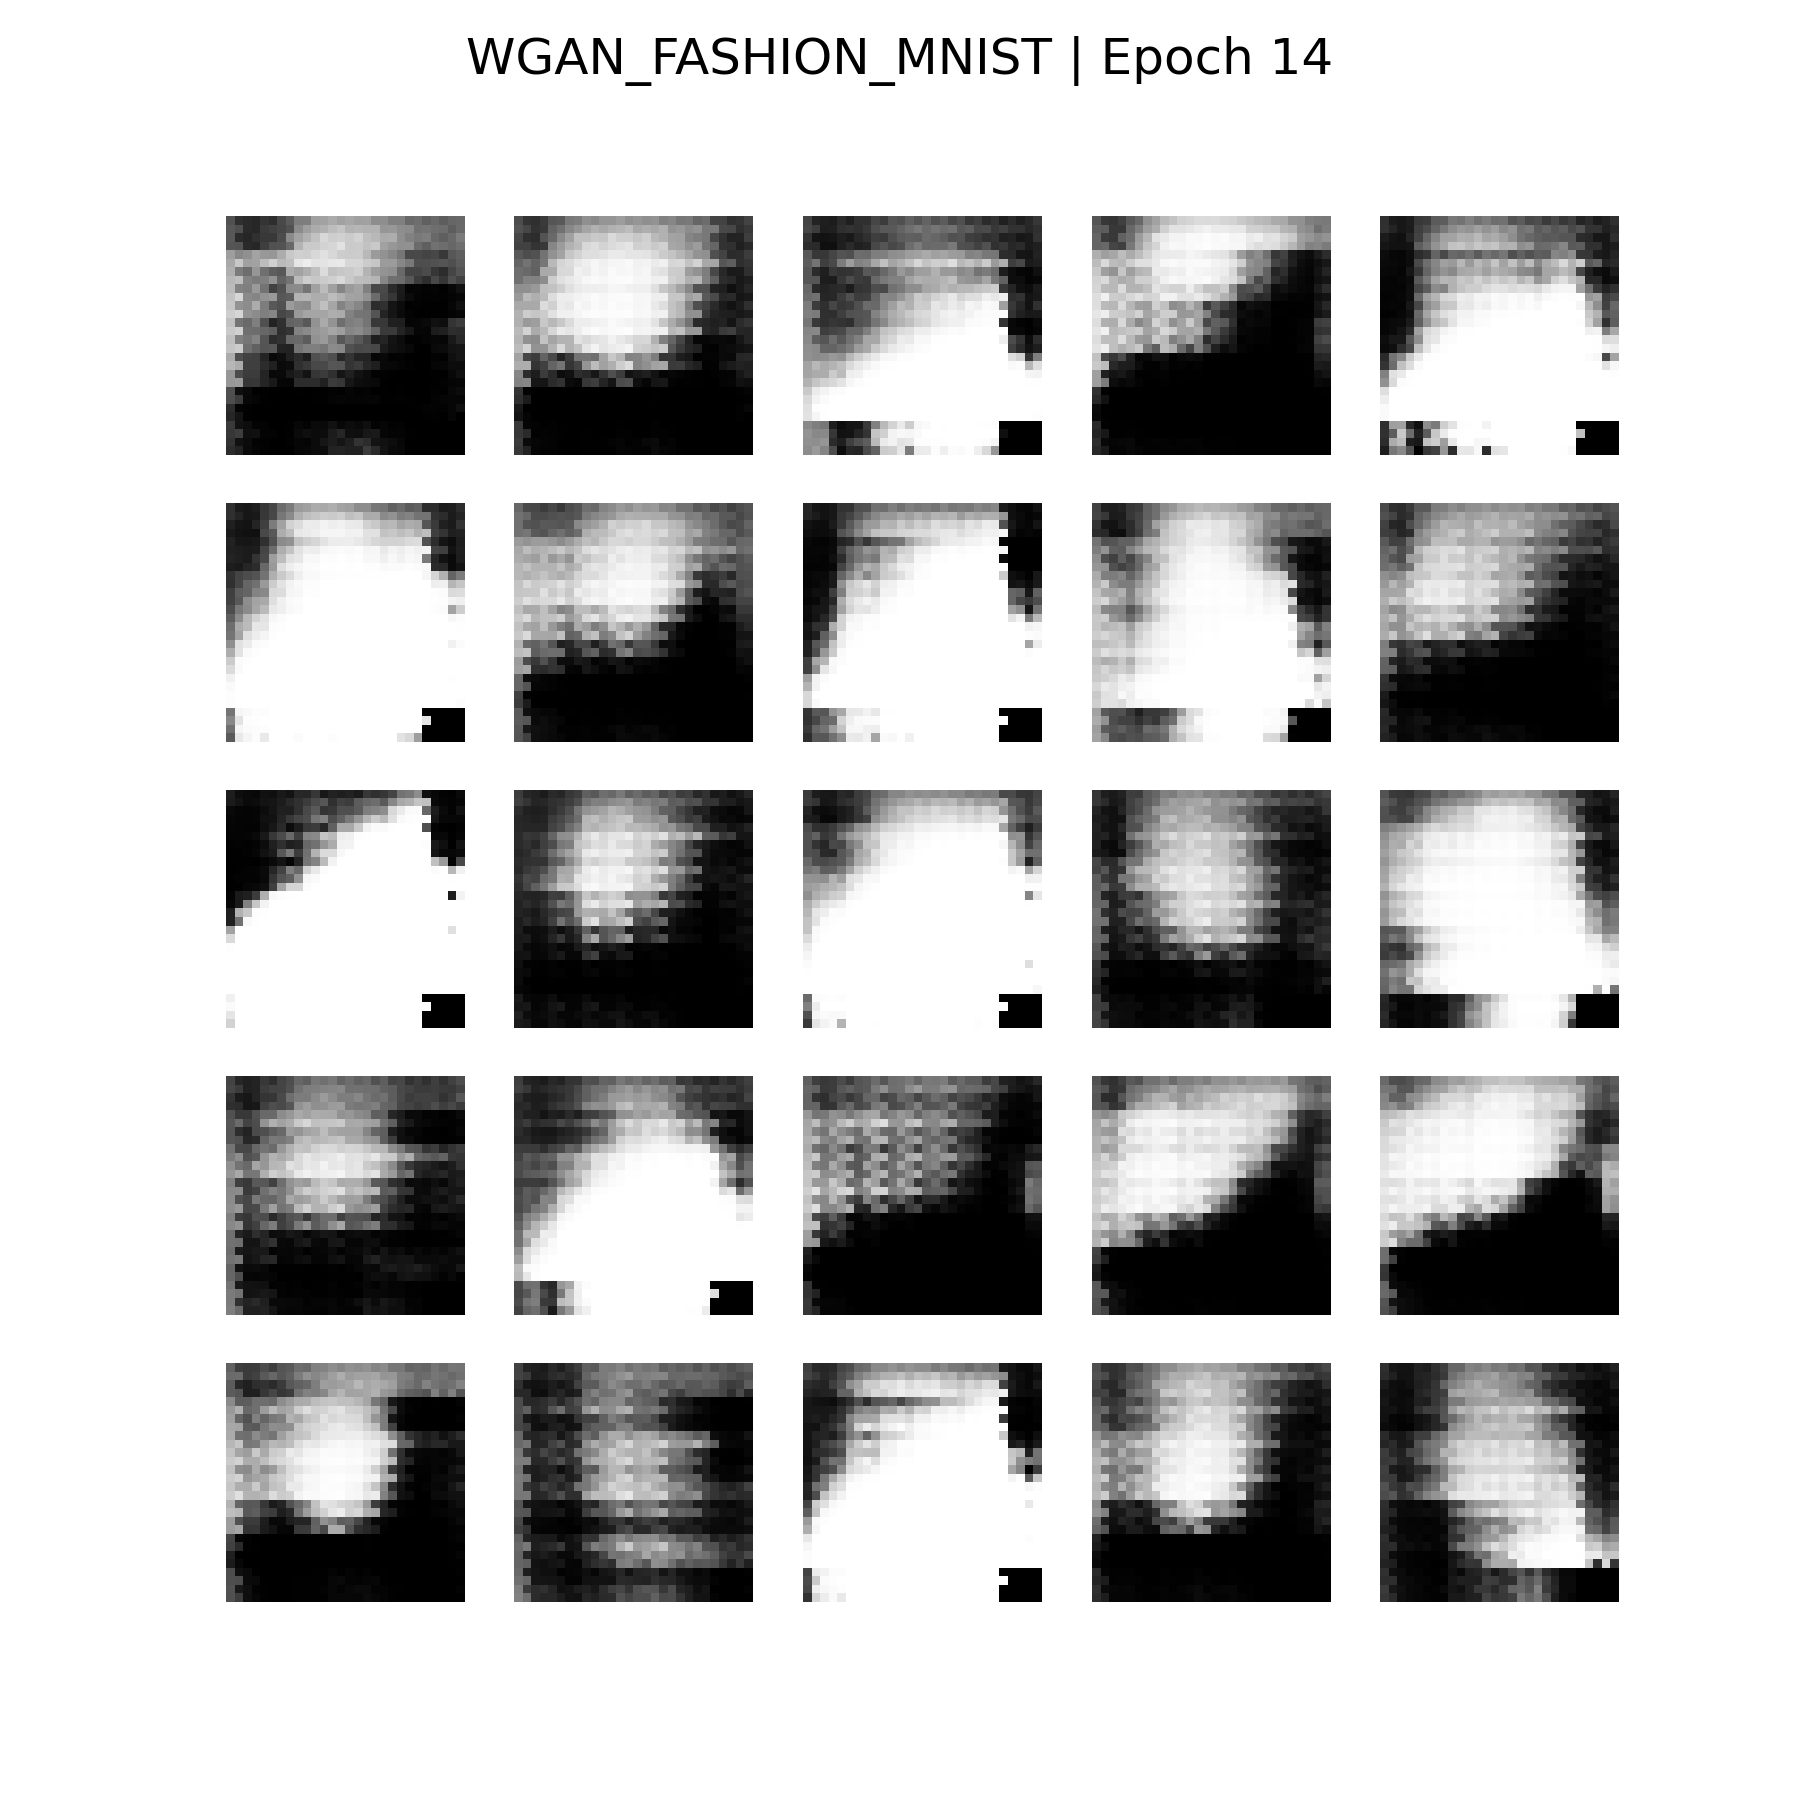
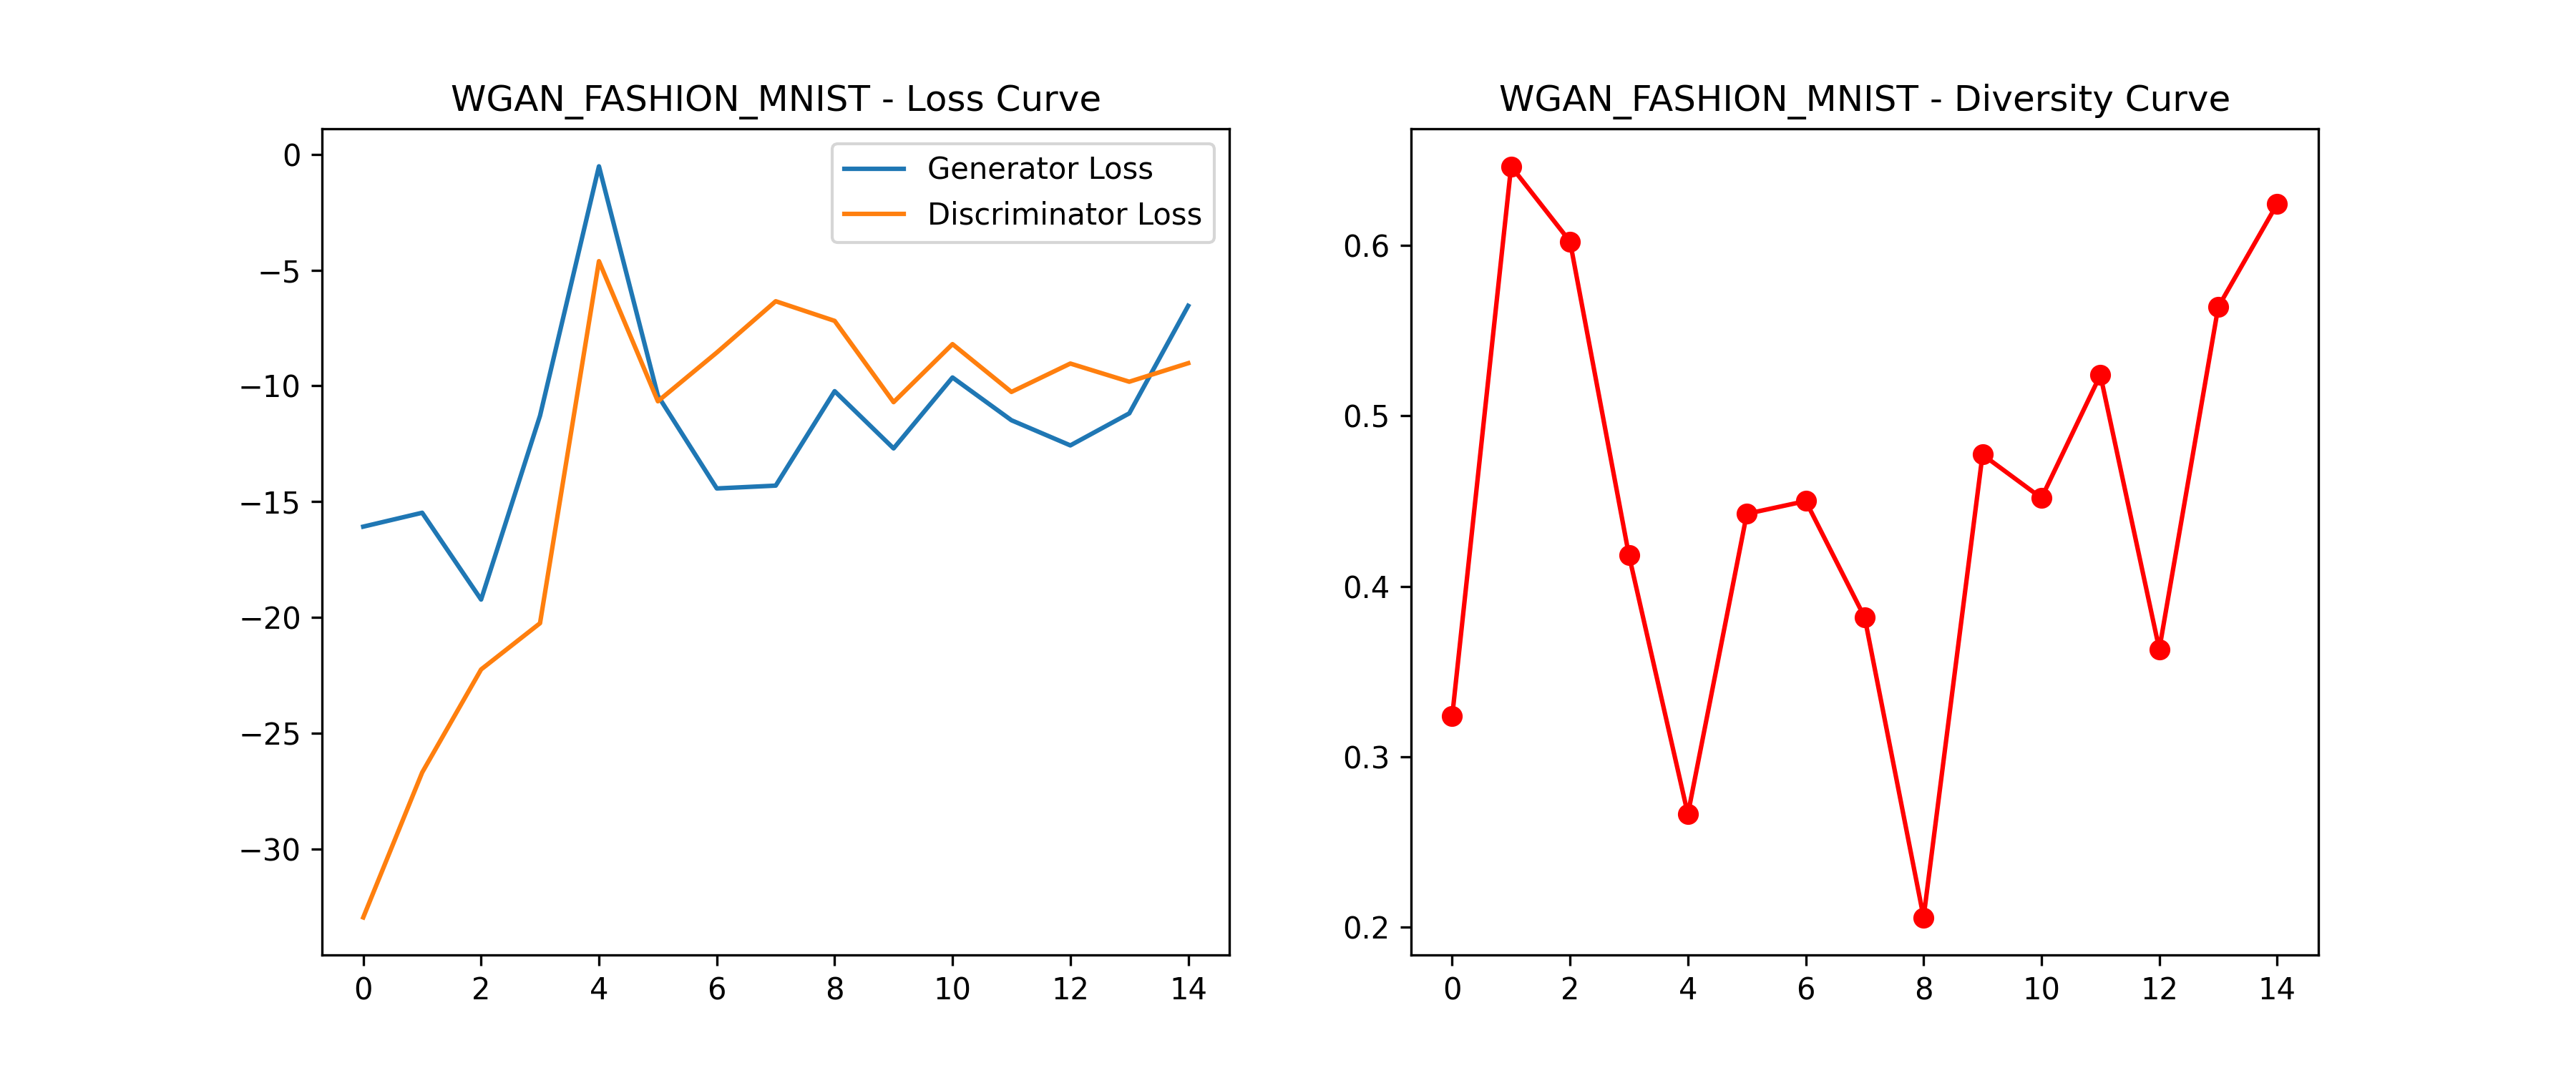
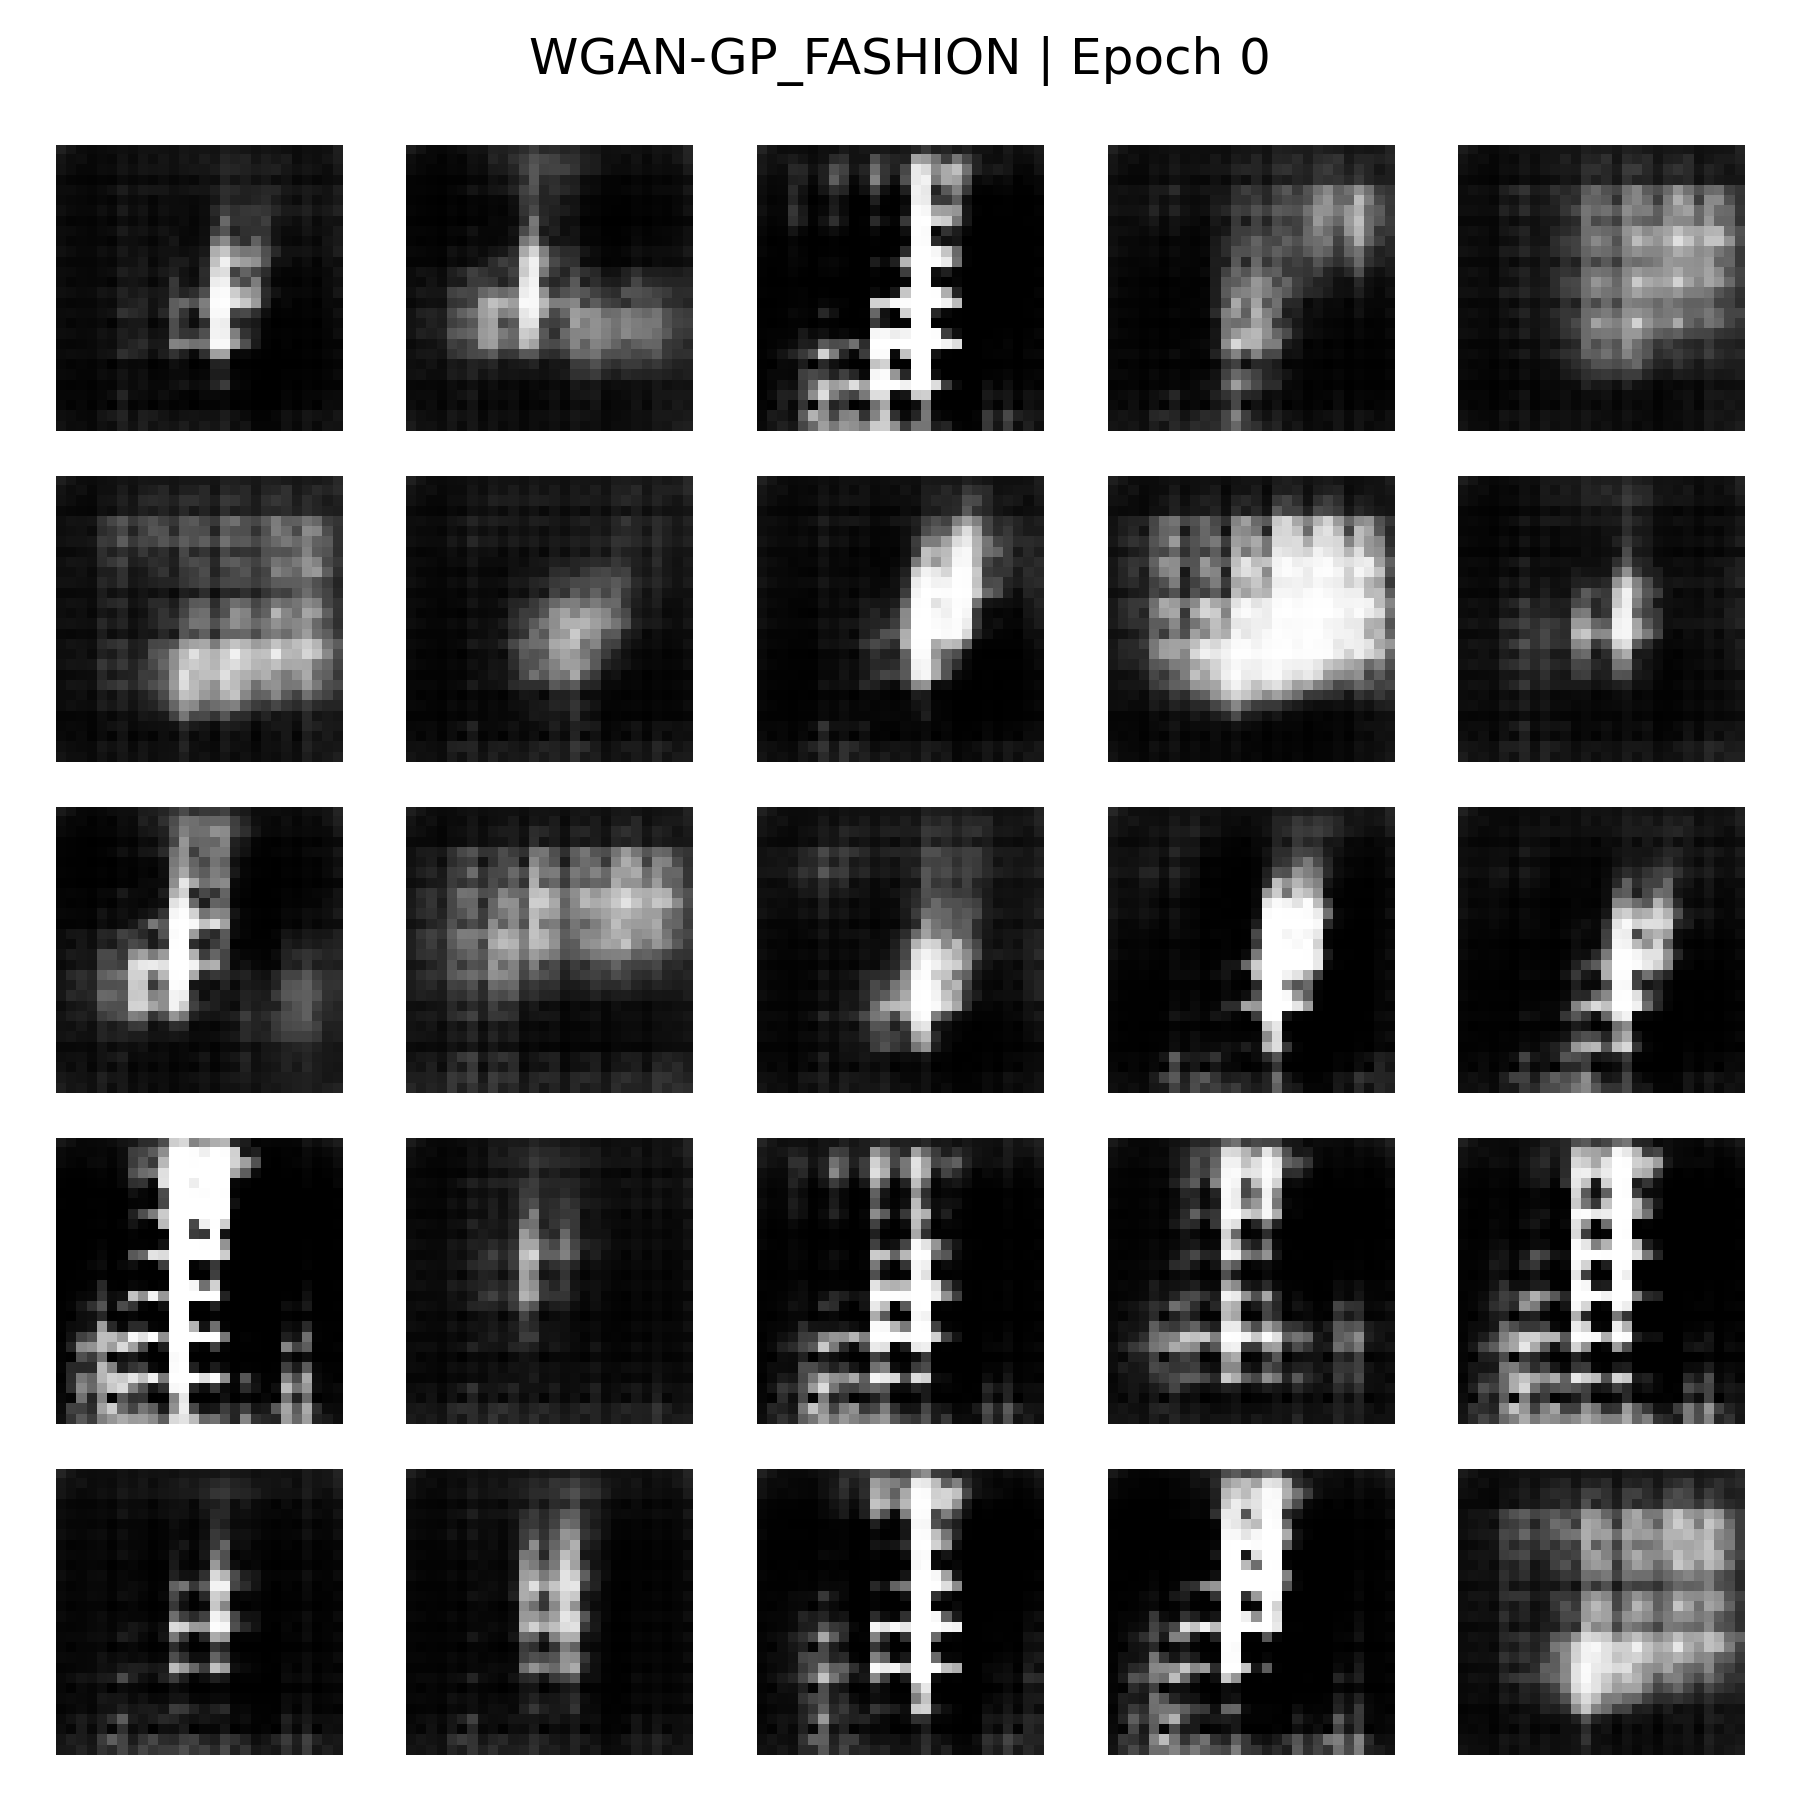
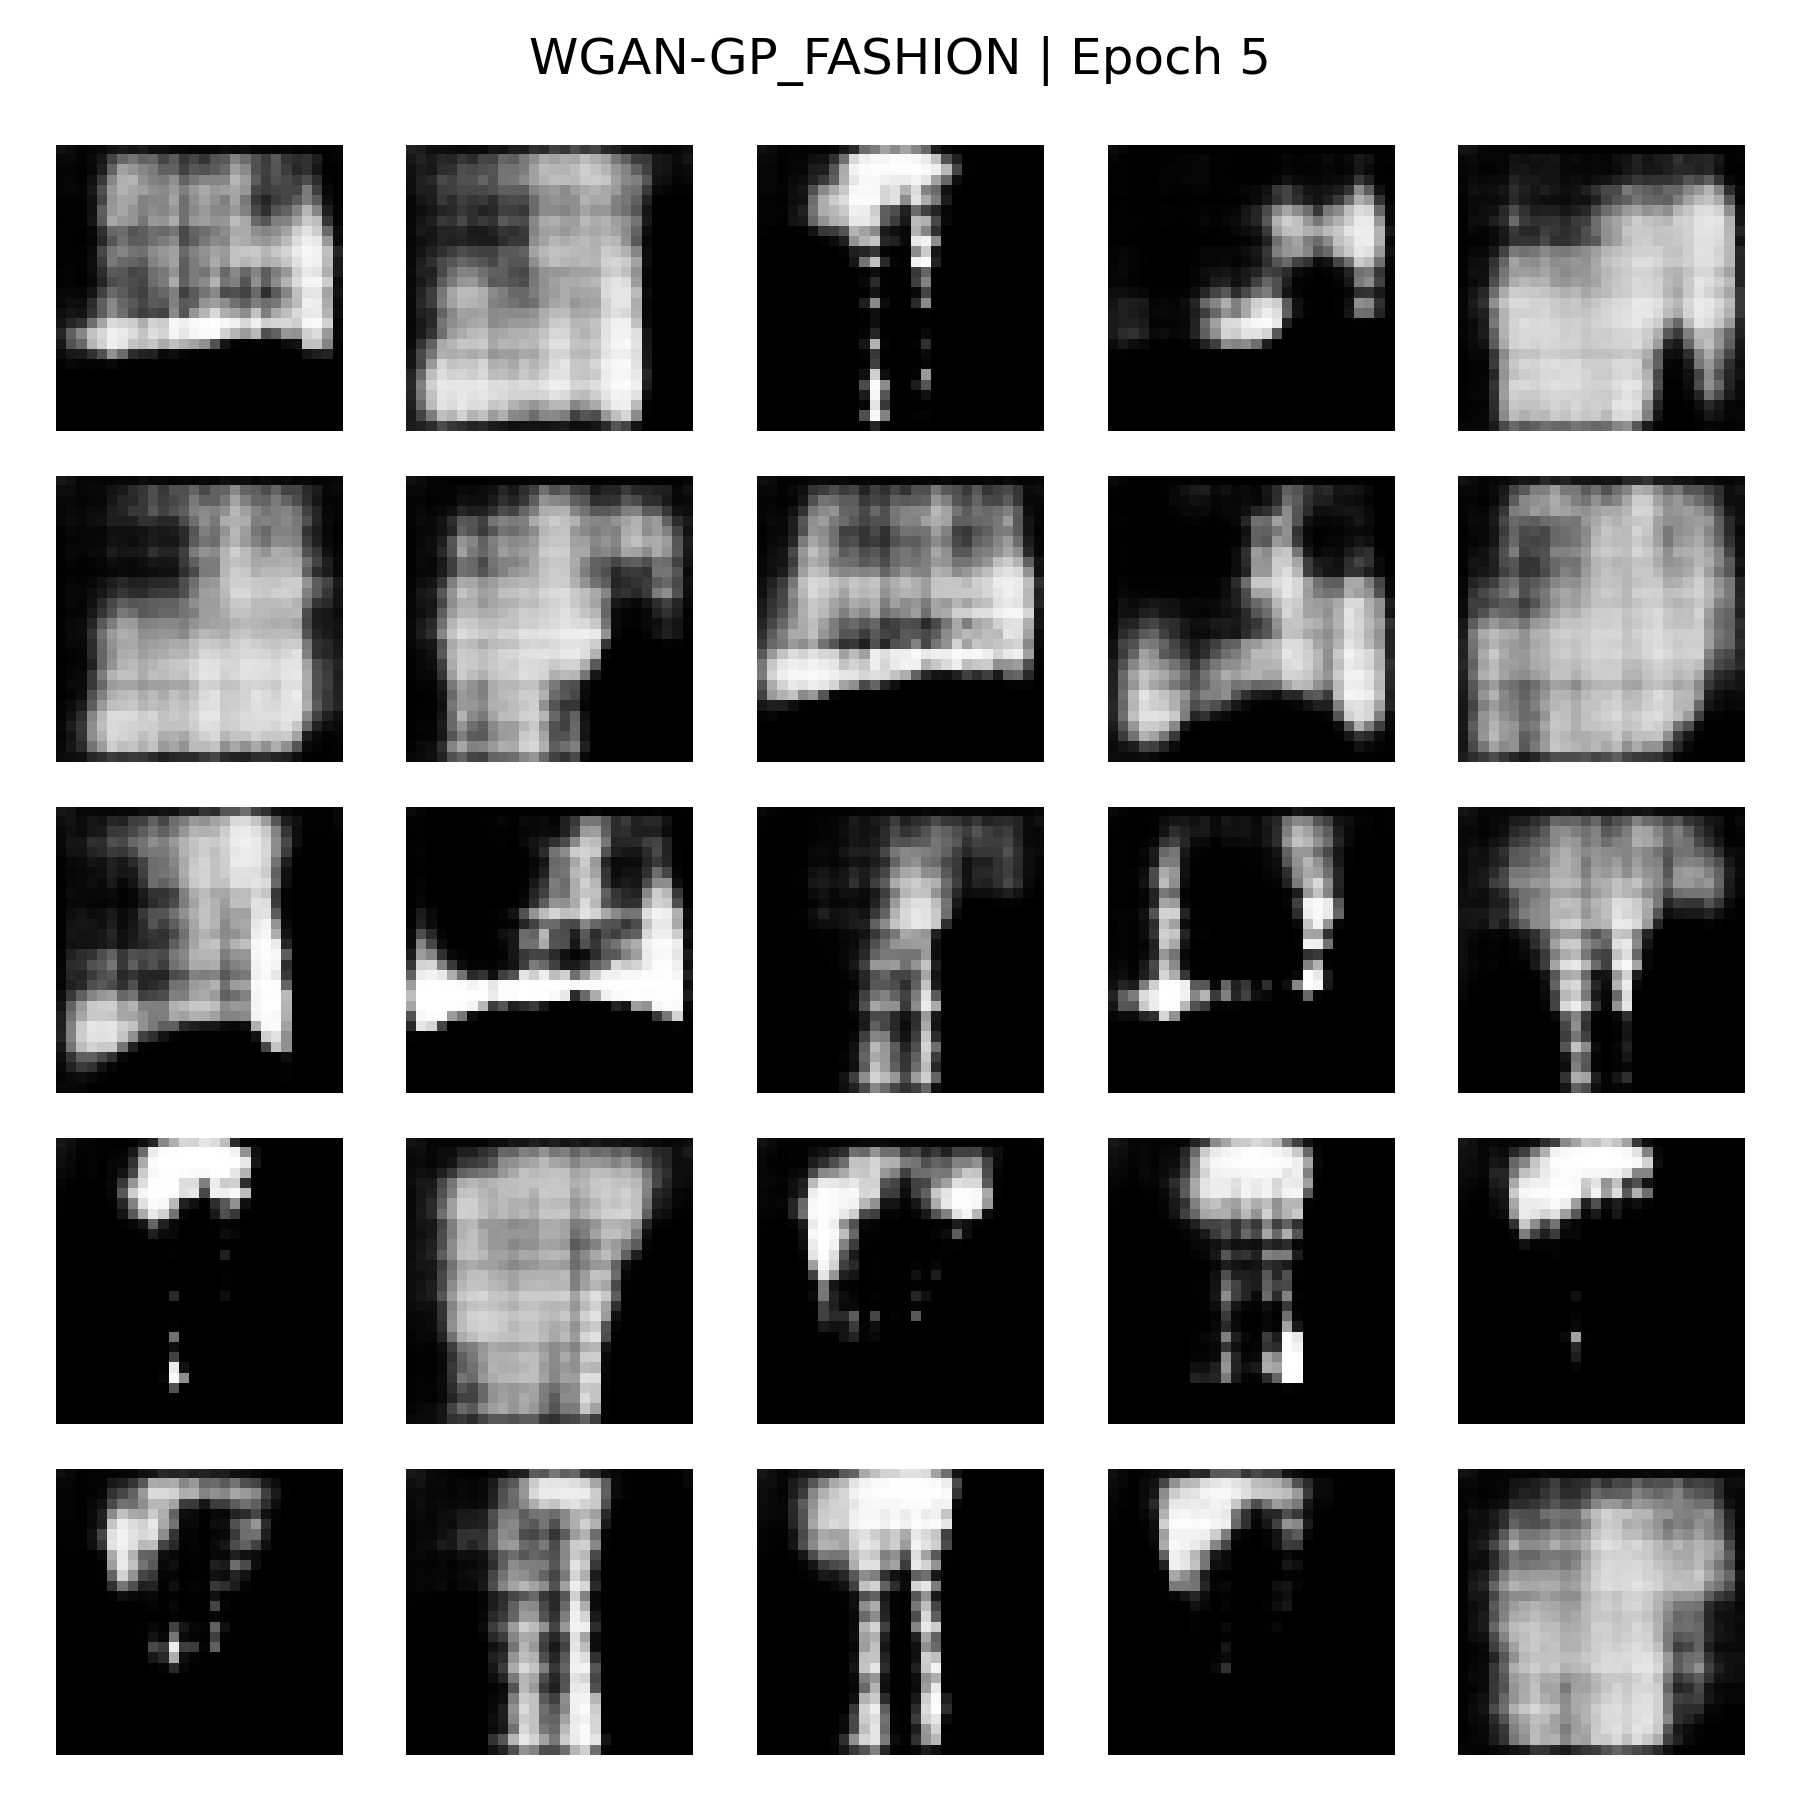
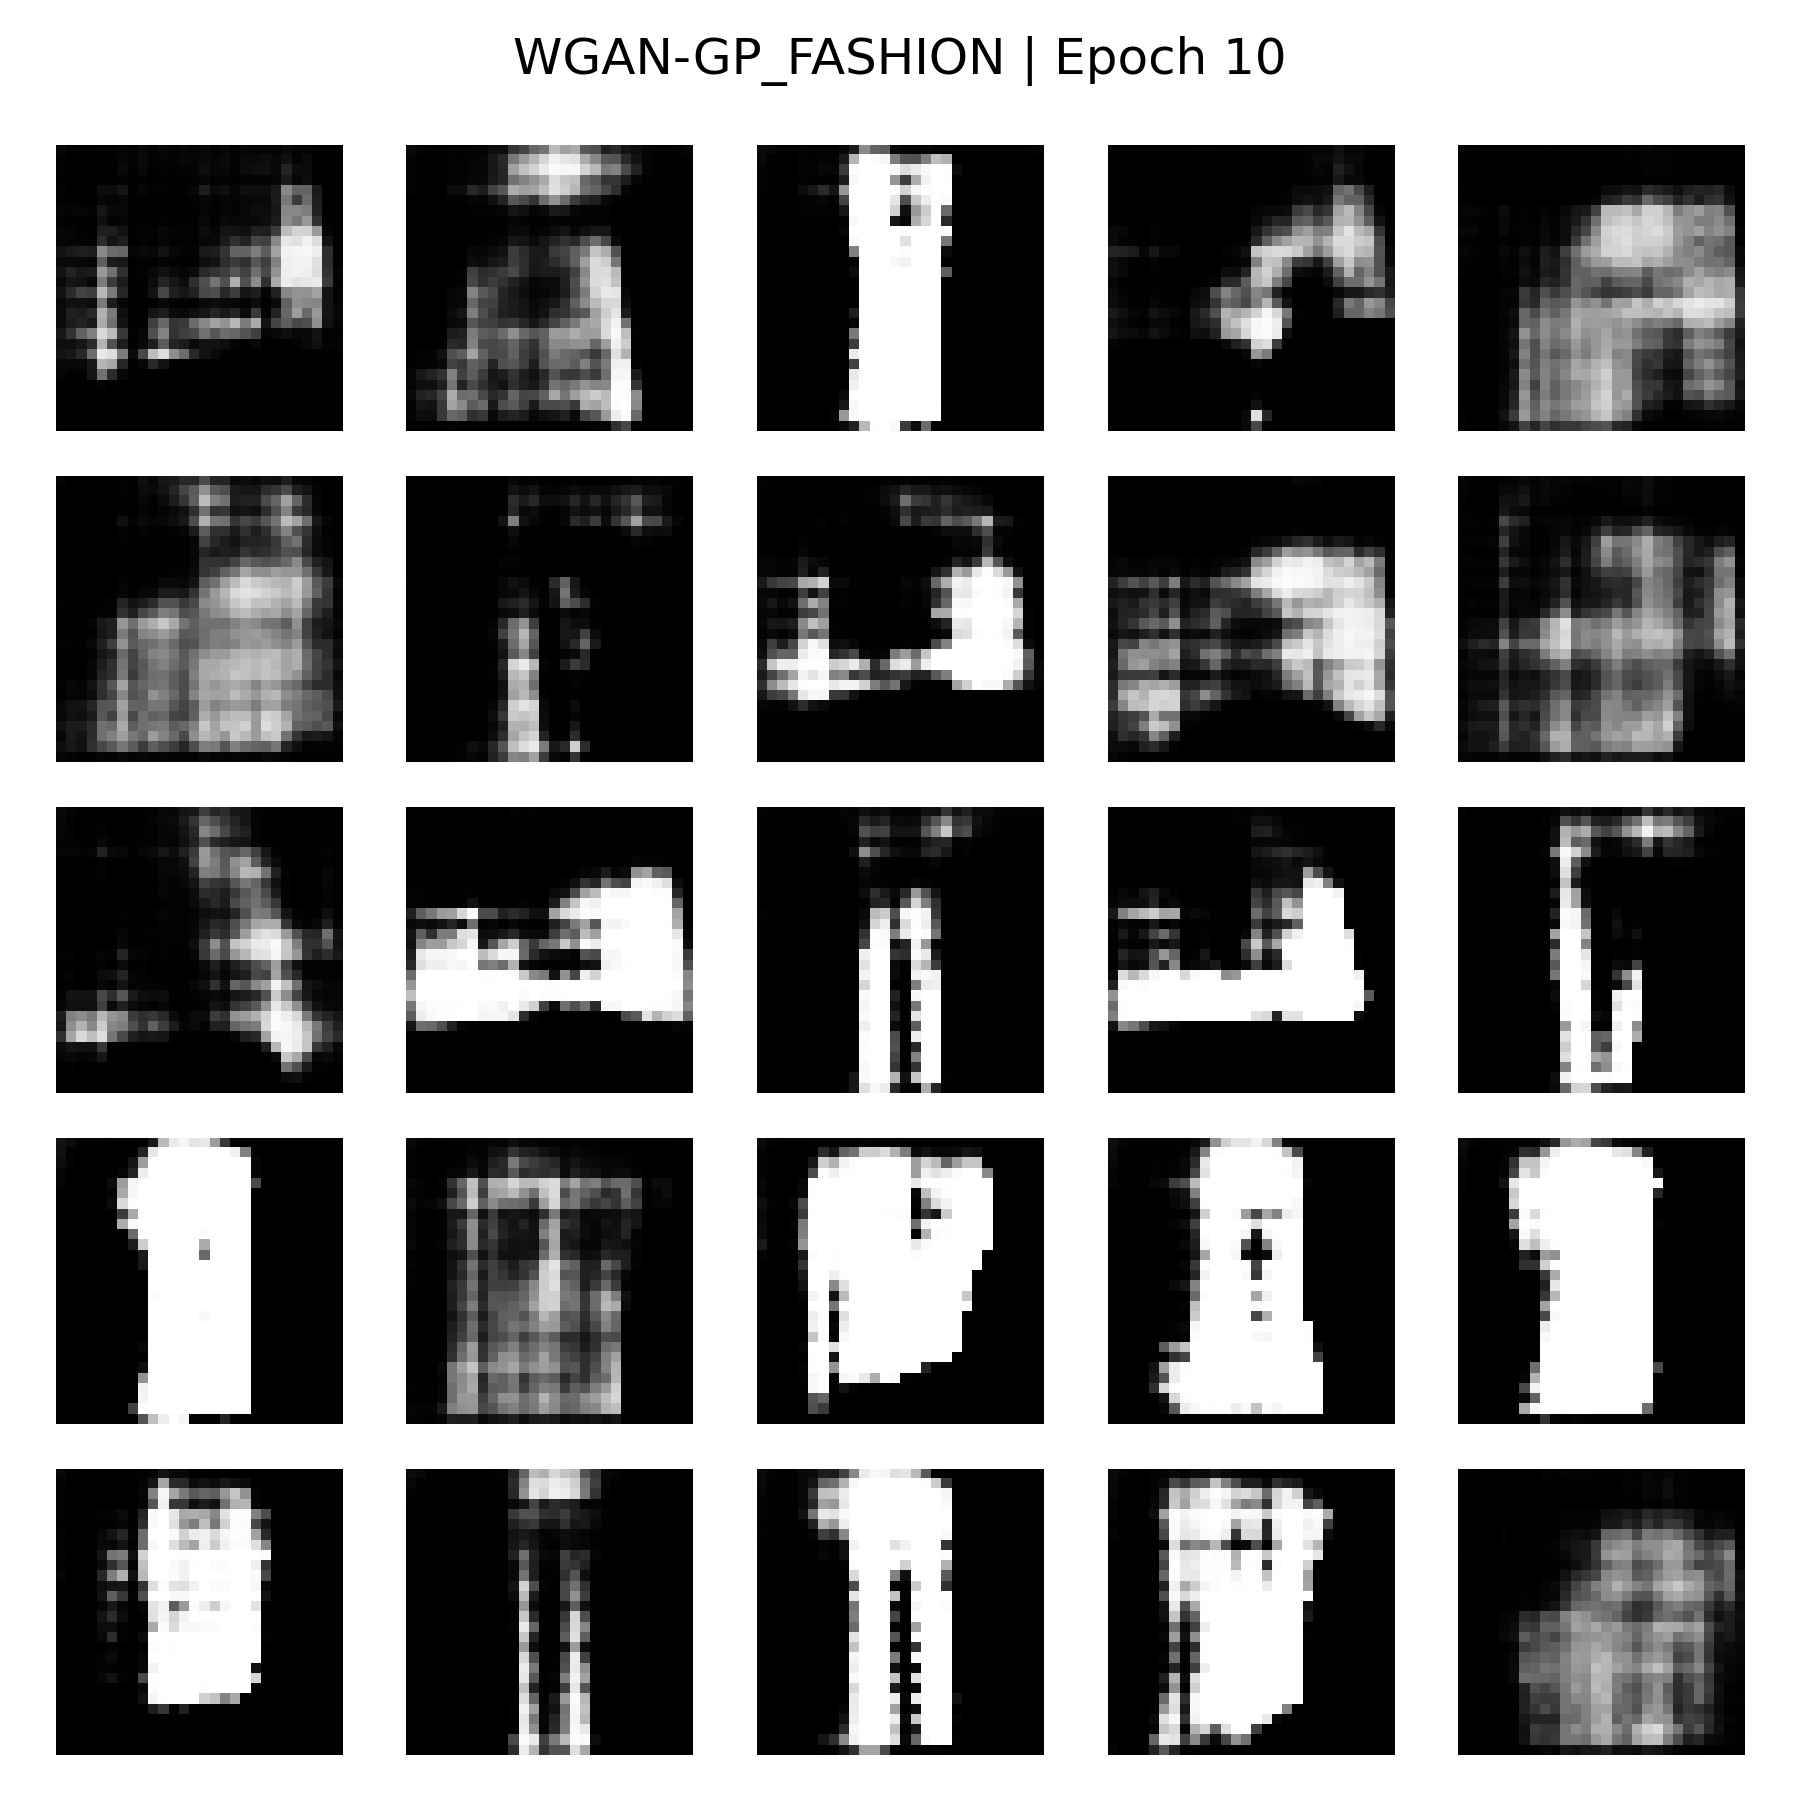
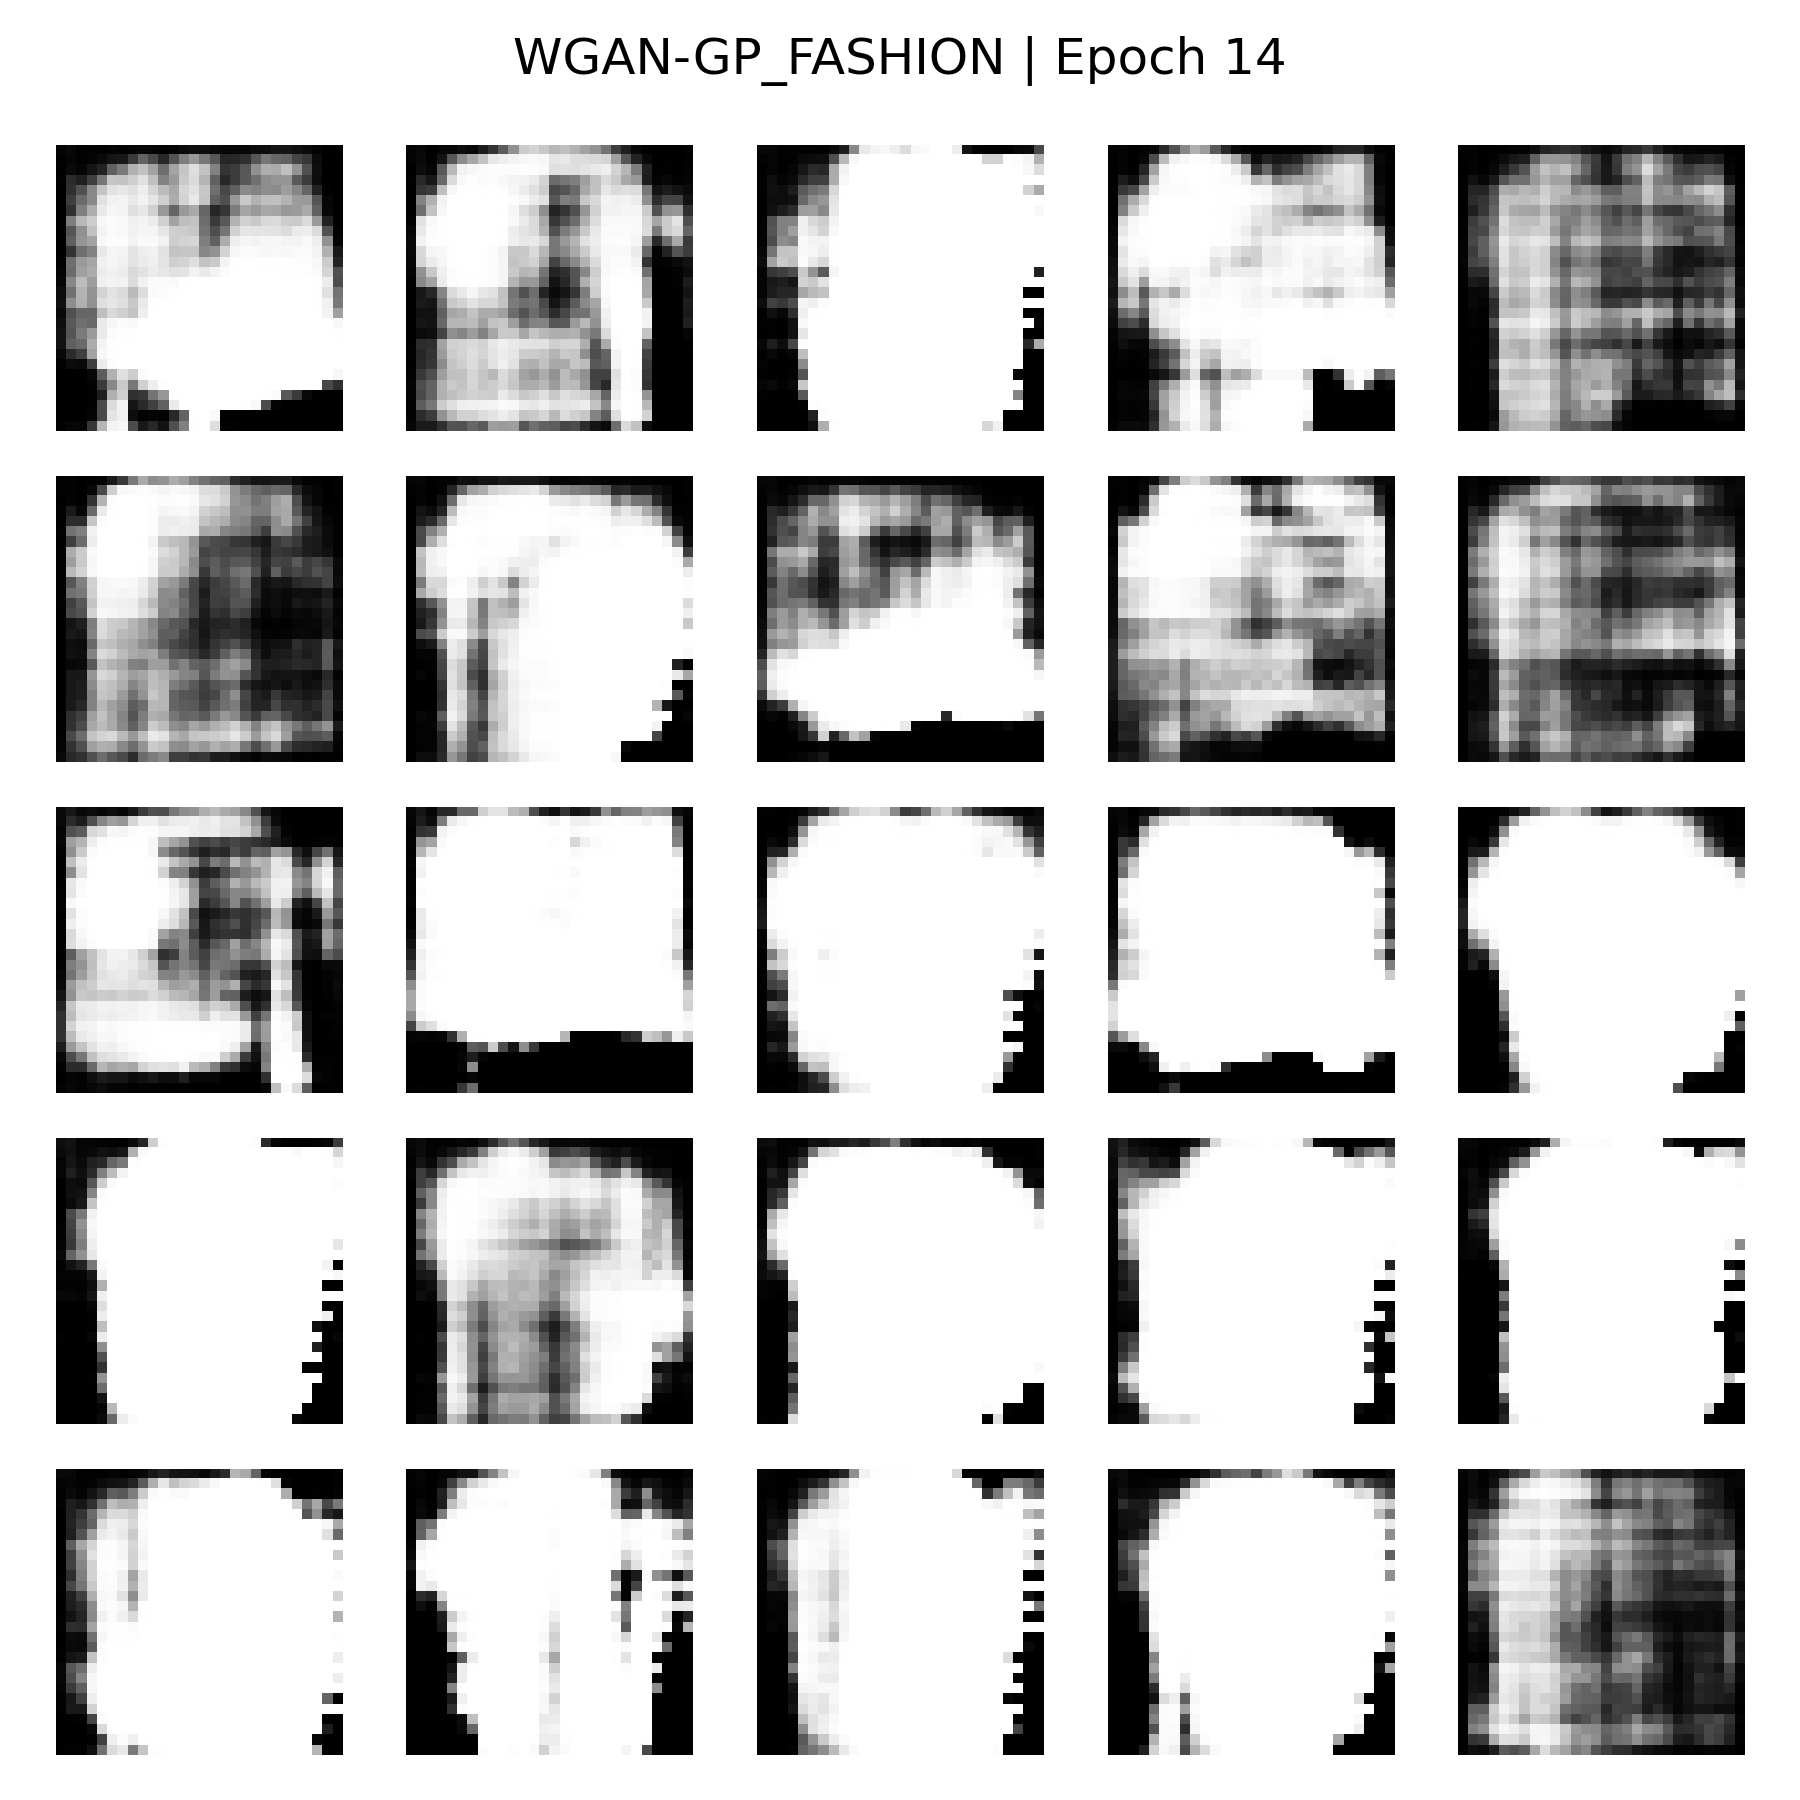
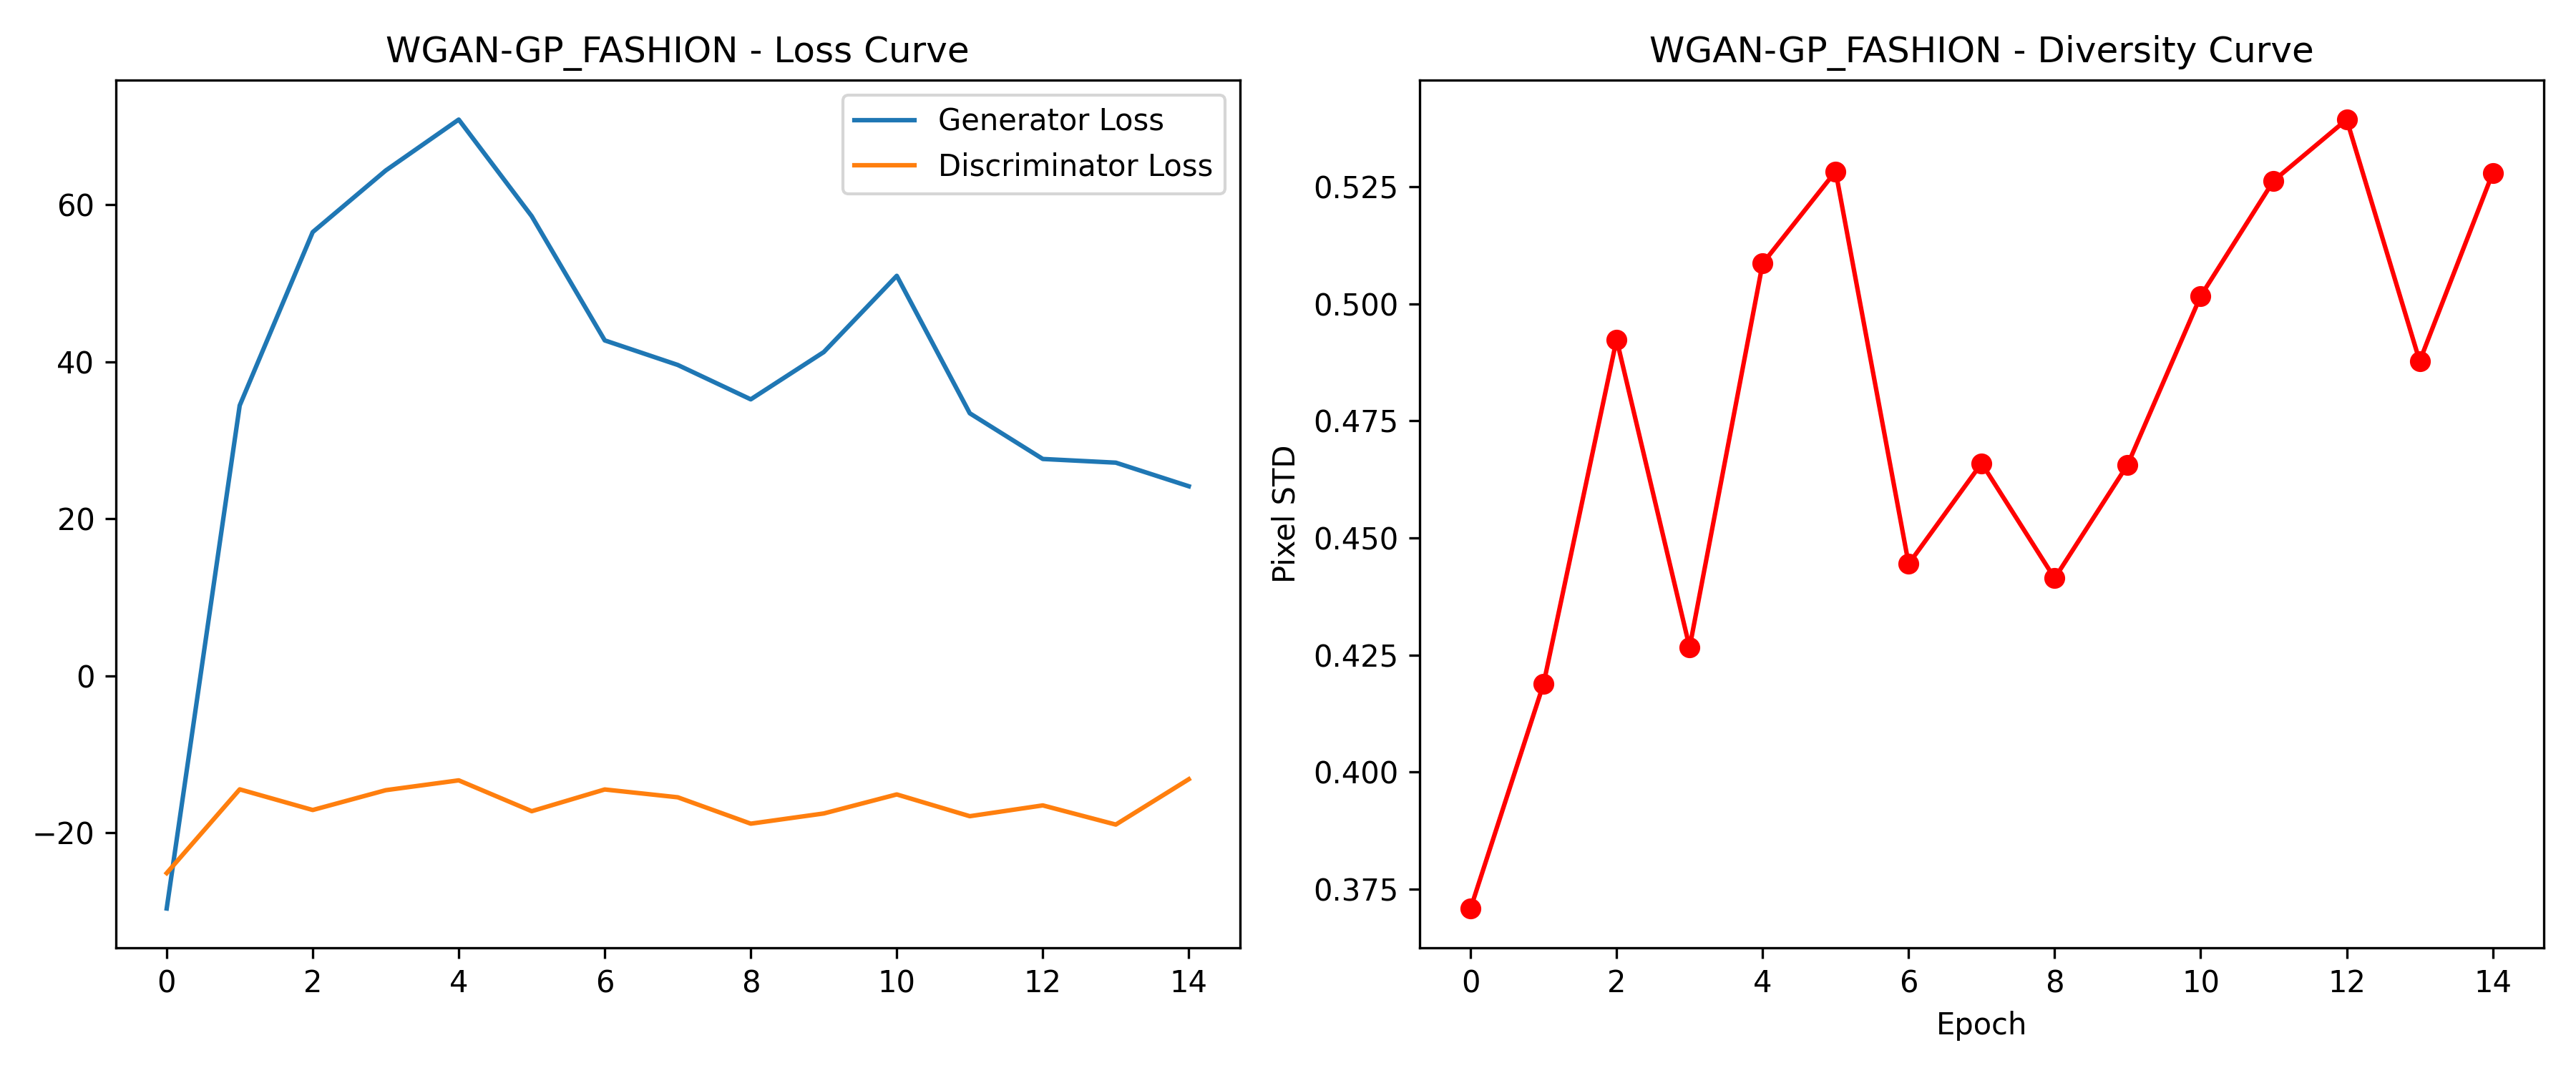

In [ ]:
import base64
from IPython.display import HTML, display
import os
import glob
import re

# Define six directory paths
dir_paths = [
    r"D:\Users\11246\Desktop\05 deep learning\03 final project\outputs\GAN\mnist",
    r"D:\Users\11246\Desktop\05 deep learning\03 final project\outputs\WGAN\mnist",
    r"D:\Users\11246\Desktop\05 deep learning\03 final project\outputs\WGAN-GP\mnist",
    r"D:\Users\11246\Desktop\05 deep learning\03 final project\outputs\GAN\fashion-mnist",
    r"D:\Users\11246\Desktop\05 deep learning\03 final project\outputs\WGAN\fashion-mnist",
    r"D:\Users\11246\Desktop\05 deep learning\03 final project\outputs\WGAN-GP\fashion-mnist"
]

# Names for each directory (for titles)
dir_names = [
    "GAN (MNIST)",
    "WGAN (MNIST)",
    "WGAN-GP (MNIST)",
    "GAN (Fashion-MNIST)",
    "WGAN (Fashion-MNIST)",
    "WGAN-GP (Fashion-MNIST)"
]

all_groups_html = []

# Process each directory
for dir_path, dir_name in zip(dir_paths, dir_names):
    if not os.path.exists(dir_path):
        continue

    # Find all image files in the directory
    image_files = []
    for ext in ['*.png', '*.jpg', '*.jpeg']:
        image_files.extend(glob.glob(os.path.join(dir_path, ext)))

    if not image_files:
        continue

    # Separate square images and wide images
    square_images = []
    wide_images = []

    for img_file in image_files:
        filename = os.path.basename(img_file).lower()
        if any(term in filename for term in ['final', 'report', 'summary']):
            wide_images.append(img_file)
        else:
            square_images.append(img_file)

    # Sort square images by epoch number
    def extract_epoch_number(filename):
        match = re.search(r'epoch(\d+)', filename.lower())
        if match:
            return int(match.group(1))
        return float('inf')

    square_images.sort(key=lambda x: extract_epoch_number(os.path.basename(x)))

    # Limit square images to 4 (epoch 0, 5, 10, 14)
    if len(square_images) > 4:
        # Try to find specific epochs
        epoch_files = {}
        for img_file in square_images:
            filename = os.path.basename(img_file)
            epoch_num = extract_epoch_number(filename)
            if epoch_num in [0, 5, 10, 14]:
                epoch_files[epoch_num] = img_file

        # Use specific epochs if found, otherwise take first 4
        if len(epoch_files) >= 4:
            square_images = [epoch_files[0], epoch_files[5], epoch_files[10], epoch_files[14]]
        else:
            square_images = square_images[:4]

    # Generate HTML for this directory
    square_html_parts = []

    # Square images grid - centered
    for img_file in square_images:
        try:
            with open(img_file, "rb") as f:
                b64 = base64.b64encode(f.read()).decode()

            filename = os.path.basename(img_file)
            # Extract epoch number for display
            epoch_num = extract_epoch_number(filename)
            if epoch_num != float('inf'):
                display_name = f"Epoch {epoch_num}"
            else:
                display_name = filename.replace('.png', '').replace('.jpg', '').replace('_', ' ')

            square_html_parts.append(f'''
            <div class="square-img">
                <div class="img-title">{display_name}</div>
                <img src="data:image/png;base64,{b64}" class="square">
            </div>
            ''')
        except:
            continue

    # Wide image (if exists)
    wide_html = ""
    if wide_images:
        try:
            img_file = wide_images[0]
            with open(img_file, "rb") as f:
                b64 = base64.b64encode(f.read()).decode()

            filename = os.path.basename(img_file)
            display_name = filename.replace('.png', '').replace('.jpg', '').replace('_', ' ')

            wide_html = f'''
            <div class="wide-img">
                <div class="img-title">{display_name}</div>
                <img src="data:image/png;base64,{b64}" class="wide">
            </div>
            '''
        except:
            pass

    # Complete HTML for this directory
    dir_html = f'''
    <div class="model-group">
        <h4 class="model-title">{dir_name}</h4>
        <div class="square-grid">
            {''.join(square_html_parts)}
        </div>
        {wide_html}
    </div>
    '''

    all_groups_html.append(dir_html)

# Generate final HTML
html = f'''
<style>
.container {{
    max-width: 1400px;
    margin: 0 auto;
    padding: 20px;
}}
.model-group {{
    margin-bottom: 40px;
    padding: 20px;
    background: #f8f9fa;
    border-radius: 12px;
    box-shadow: 0 4px 12px rgba(0,0,0,0.05);
}}
.model-title {{
    color: #2c3e50;
    text-align: center;
    border-bottom: 2px solid #3498db;
    padding-bottom: 10px;
    margin-bottom: 20px;
    font-size: 20px;
}}
.square-grid {{
    display: flex;
    justify-content: center;
    flex-wrap: wrap;
    gap: 20px;
    margin-bottom: 20px;
}}
.square-img {{
    text-align: center;
    background: white;
    padding: 15px;
    border-radius: 8px;
    box-shadow: 0 2px 6px rgba(0,0,0,0.08);
    width: 240px; /* Increased size */
}}
.img-title {{
    font-weight: 600;
    margin-bottom: 12px;
    color: #2c3e50;
    font-size: 15px;
    text-align: center;
}}
.square {{
    width: 100%;
    height: 220px; /* Increased height */
    object-fit: contain;
    border: 1px solid #e0e0e0;
    border-radius: 4px;
}}
.wide-img {{
    margin-top: 15px;
    text-align: center;
}}
.wide {{
    width: 90%;
    max-width: 1000px;
    height: 300px;
    object-fit: contain;
    border: 1px solid #e0e0e0;
    border-radius: 6px;
}}
.wide-img .img-title {{
    font-size: 16px;
    color: #2c3e50;
    margin-bottom: 12px;
    text-align: center;
}}
</style>

<div class="container">
    <h2 style="color: #2c3e50; text-align: center; margin-bottom: 30px;">GAN Models Comparison</h2>

    {''.join(all_groups_html)}
</div>
'''

display(HTML(html))

TODO: Write up your analysis

Project Summary & Critical Reflection
Our experiments were successful on a basic level: all three models—the original GAN, WGAN, and WGAN-GP—produced visually convincing samples of handwritten digits and fashion items. This means the core objective of getting generative models to run and output recognizable images was definitely achieved.

While the original GAN’s outputs often looked the sharpest to our eyes, we don’t think that alone proves it’s the best model. GANs are notoriously unstable in training, and we might have just saved a particularly good checkpoint—a single “lucky” snapshot doesn’t mean it truly learned the full diversity of the data, as it could be prone to mode collapse. The WGAN and WGAN-GP models, while designed to be more stable, brought their own challenges. They are sensitive to implementation details and hyperparameters, like how many times to train the critic or how strong the gradient penalty should be. It’s very possible that with more time for tuning, their results could have matched or surpassed the standard GAN. Also, because we used relatively simple datasets like MNIST and Fashion-MNIST, visual sharpness can become an easy but misleading metric for comparison.

To move from a visual impression to a solid conclusion, our project would need a more rigorous evaluation phase. This would involve running each model multiple times under controlled conditions and using quantitative metrics like FID or Inception Score to compare them objectively. We’d also monitor the training process more closely, logging losses and gradients to understand stability, and spend more time verifying our WGAN-GP implementation and tuning its key parameters. Ultimately, this experience taught us that in machine learning, a good-looking result is just the beginning—the real insight comes from careful, critical analysis of why we got those results and how reliable they truly are.

